# Many-cell trajectory measurement


Designed to measure a series of time-dependent single-cell fluorescent/holographic intensities over the course of a time-lapse microscopy data set


```
Author: 
- Nathan J. Day (nathan.day.16@ucl.ac.uk)
```


### STEPS
1. Directory organisation
2. Load image information
3. Load the xyt data of each cell from HDF5 tracking file (see Arboretum tracker @quantumjot github)
4. Meta-analysis of tracks with optional filtering of anomalous tracks
5. Measure cellular properties across all images, all cells
6. Save information out as pandas df and .csv

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import ndimage
from skimage import io #used to be from skimage import io
from skimage.io import imshow
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
import btrack
from btrack.utils import import_HDF, import_JSON
from tqdm.notebook import tnrange, tqdm
from time import sleep

## Measure 

Read cell mask information (location & area) and obtain fluorescent and phase stats. If the data already exists in a .csv and just needs to be plotted then skip to the plotter section.

#### Raw data (image) location

The image data needs to be organised inside the ```root_dir``` as follows:

```
phase/
    0000_phase.tif
    0001_phase.tif
    ...
gfp/
    0000_gfp.tif
    0001_gfp.tif
    ...
rfp/
    0000_rfp.tif
    0001_rfp.tif
    ...
labels/
    0000_mask.tif
    0001_mask.tif
    ...    
```

In [8]:
root_path = "/home/nathan/data/fucci/fucci1_171201/"

gfp_dir = os.path.join(root_path, "gfp")
rfp_dir = os.path.join(root_path, "rfp")
phase_dir = os.path.join(root_path, "phase")
mask_dir = os.path.join(root_path, "labels")

gfp_list = natsorted([m for m in os.listdir(gfp_dir) if m.endswith('.tif')])
rfp_list = natsorted([m for m in os.listdir(rfp_dir) if m.endswith('.tif')])
phase_list = natsorted([m for m in os.listdir(phase_dir) if m.endswith('.tif')])
mask_list = natsorted([m for m in os.listdir(mask_dir) if m.endswith('.tif')])

### Load the tracking information to obtain xyt of cells

Load tracks directly from hdf5

In [9]:
filename ='/home/nathan/data/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5'
with btrack.dataio.HDF5FileHandler(filename, 'r') as h:
    tracks = h.tracks
tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/07/24 04:41:47 PM] Opening HDF file: /home/nathan/data/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5
[INFO][2020/07/24 04:41:47 PM] Loading tracks: obj_type_1...
[INFO][2020/07/24 04:41:47 PM] Loading obj_type_1 (160396, 5) (160396 filtered: None)...
[INFO][2020/07/24 04:41:49 PM] Closing HDF file: /home/nathan/data/fucci/fucci1_171201/tracks/tracks_cellpose/cellpose_nuclear.h5


Track information loaded


## Meta-analysis of tracks

List of track lengths

In [225]:
### length of tracks 
for i in range(len(tracks)):
    print("track ID.", tracks[i].ID,"length=", len(tracks[i]))

track ID. 65 length= 133
track ID. 77 length= 69
track ID. 76 length= 22
track ID. 75 length= 5
track ID. 74 length= 107
track ID. 73 length= 64
track ID. 72 length= 1091
track ID. 71 length= 2
track ID. 70 length= 386
track ID. 69 length= 55
track ID. 68 length= 349
track ID. 67 length= 23
track ID. 66 length= 75
track ID. 78 length= 178
track ID. 64 length= 629
track ID. 63 length= 52
track ID. 62 length= 57
track ID. 61 length= 96
track ID. 60 length= 21
track ID. 59 length= 7
track ID. 58 length= 94
track ID. 57 length= 865
track ID. 56 length= 86
track ID. 55 length= 25
track ID. 54 length= 602
track ID. 53 length= 37
track ID. 91 length= 160
track ID. 1 length= 12
track ID. 102 length= 1
track ID. 101 length= 558
track ID. 100 length= 23
track ID. 99 length= 128
track ID. 98 length= 12
track ID. 97 length= 111
track ID. 96 length= 25
track ID. 95 length= 58
track ID. 94 length= 609
track ID. 93 length= 49
track ID. 92 length= 59
track ID. 2 length= 591
track ID. 90 length= 22
tra

track ID. 607 length= 1
track ID. 608 length= 11
track ID. 610 length= 6
track ID. 615 length= 408
track ID. 616 length= 1
track ID. 614 length= 2
track ID. 617 length= 1
track ID. 618 length= 1
track ID. 619 length= 1
track ID. 621 length= 2
track ID. 622 length= 3
track ID. 623 length= 1
track ID. 624 length= 5
track ID. 625 length= 1
track ID. 626 length= 480
track ID. 633 length= 36
track ID. 632 length= 324
track ID. 631 length= 29
track ID. 629 length= 1
track ID. 628 length= 227
track ID. 627 length= 3
track ID. 630 length= 1
track ID. 634 length= 1
track ID. 635 length= 2
track ID. 636 length= 15
track ID. 637 length= 191
track ID. 638 length= 1
track ID. 640 length= 846
track ID. 641 length= 1
track ID. 642 length= 1
track ID. 643 length= 1
track ID. 644 length= 33
track ID. 645 length= 1
track ID. 646 length= 6
track ID. 647 length= 4
track ID. 648 length= 13
track ID. 650 length= 1
track ID. 649 length= 30
track ID. 651 length= 8
track ID. 653 length= 5
track ID. 652 length=

track ID. 1140 length= 158
track ID. 1141 length= 3
track ID. 1145 length= 1
track ID. 1146 length= 1
track ID. 1147 length= 5
track ID. 1149 length= 1
track ID. 1150 length= 3
track ID. 1151 length= 13
track ID. 1152 length= 1
track ID. 1153 length= 113
track ID. 1154 length= 111
track ID. 1158 length= 2
track ID. 1159 length= 2
track ID. 1155 length= 23
track ID. 1157 length= 3
track ID. 1162 length= 2
track ID. 1165 length= 3
track ID. 1168 length= 7
track ID. 1167 length= 1
track ID. 1169 length= 2
track ID. 1170 length= 9
track ID. 1171 length= 1
track ID. 1172 length= 3
track ID. 1173 length= 2
track ID. 1174 length= 12
track ID. 1175 length= 3
track ID. 1176 length= 1
track ID. 1177 length= 118
track ID. 1178 length= 1
track ID. 1180 length= 1
track ID. 1181 length= 1
track ID. 1182 length= 1
track ID. 1183 length= 4
track ID. 1184 length= 1
track ID. 1185 length= 14
track ID. 1186 length= 92
track ID. 1187 length= 3
track ID. 1188 length= 1
track ID. 1189 length= 1
track ID. 11

track ID. 1610 length= 1
track ID. 1609 length= 1
track ID. 1611 length= 328
track ID. 1612 length= 1
track ID. 1613 length= 7
track ID. 1614 length= 1
track ID. 1615 length= 6
track ID. 1616 length= 1
track ID. 1617 length= 6
track ID. 1618 length= 52
track ID. 1619 length= 302
track ID. 1620 length= 1
track ID. 1622 length= 11
track ID. 1623 length= 1
track ID. 1625 length= 2
track ID. 1628 length= 1
track ID. 1627 length= 1
track ID. 1624 length= 11
track ID. 1626 length= 1
track ID. 1629 length= 1
track ID. 1630 length= 7
track ID. 1631 length= 16
track ID. 1632 length= 53
track ID. 1633 length= 1
track ID. 1634 length= 1
track ID. 1635 length= 2
track ID. 1636 length= 1
track ID. 1637 length= 1
track ID. 1638 length= 2
track ID. 1639 length= 10
track ID. 1640 length= 7
track ID. 1641 length= 2
track ID. 1643 length= 1
track ID. 1642 length= 1
track ID. 1644 length= 318
track ID. 1645 length= 1
track ID. 1646 length= 318
track ID. 1647 length= 317
track ID. 1649 length= 1
track ID.

track ID. 2030 length= 1
track ID. 2032 length= 1
track ID. 2034 length= 174
track ID. 2035 length= 1
track ID. 2036 length= 1
track ID. 2037 length= 172
track ID. 2039 length= 2
track ID. 2040 length= 1
track ID. 2041 length= 1
track ID. 2042 length= 1
track ID. 2044 length= 4
track ID. 2046 length= 3
track ID. 2047 length= 1
track ID. 2048 length= 162
track ID. 2049 length= 3
track ID. 2050 length= 3
track ID. 2051 length= 4
track ID. 2052 length= 26
track ID. 2053 length= 7
track ID. 2054 length= 4
track ID. 2055 length= 8
track ID. 2056 length= 9
track ID. 2057 length= 1
track ID. 2058 length= 7
track ID. 2059 length= 155
track ID. 2061 length= 1
track ID. 2063 length= 110
track ID. 2064 length= 2
track ID. 2066 length= 1
track ID. 2068 length= 12
track ID. 2071 length= 43
track ID. 2069 length= 1
track ID. 2072 length= 13
track ID. 2073 length= 3
track ID. 2075 length= 2
track ID. 2076 length= 18
track ID. 2077 length= 1
track ID. 2078 length= 1
track ID. 2079 length= 1
track ID. 

Histogram of track lengths

1092


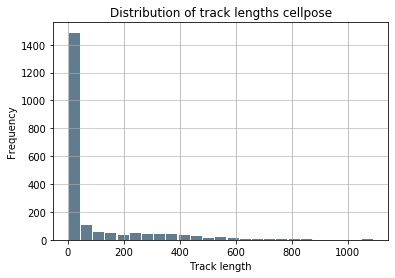

In [227]:
#size, scale = 1000, 10
track_lengths = [len(track) for track in tracks] 
tracks_df = pd.Series(track_lengths)
print(max(tracks_df))

tracks_df.plot.hist(grid=True, bins=25, rwidth=0.9,
                   color='#607c8e')
title = 'Distribution of track lengths cellpose'
plt.title(title)
plt.xlabel('Track length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

### Filter track lengths if desired

In [10]:
filtered_tracks = [track for track in tracks if len(track) > 200] #excludes track lengths below 1000 frames
track_lengths = [len(track) for track in filtered_tracks] 
track_IDs = [track.ID for track in filtered_tracks] 

for i in range(len(track_lengths)):
    print("ID = ", track_IDs[i], "/ Length = ", track_lengths[i])

ID =  72 / Length =  1091
ID =  70 / Length =  386
ID =  68 / Length =  349
ID =  64 / Length =  629
ID =  57 / Length =  865
ID =  54 / Length =  602
ID =  101 / Length =  558
ID =  94 / Length =  609
ID =  2 / Length =  591
ID =  86 / Length =  201
ID =  85 / Length =  682
ID =  20 / Length =  719
ID =  18 / Length =  379
ID =  16 / Length =  803
ID =  10 / Length =  227
ID =  7 / Length =  534
ID =  5 / Length =  756
ID =  28 / Length =  664
ID =  50 / Length =  425
ID =  49 / Length =  554
ID =  48 / Length =  239
ID =  46 / Length =  1092
ID =  43 / Length =  575
ID =  115 / Length =  340
ID =  146 / Length =  243
ID =  161 / Length =  581
ID =  164 / Length =  762
ID =  167 / Length =  495
ID =  172 / Length =  682
ID =  173 / Length =  573
ID =  180 / Length =  331
ID =  182 / Length =  1062
ID =  189 / Length =  612
ID =  197 / Length =  528
ID =  221 / Length =  246
ID =  229 / Length =  495
ID =  234 / Length =  498
ID =  239 / Length =  1030
ID =  241 / Length =  399
ID =  2

# The _NUMBER CRUNCH_ zone

#### Data output directory creation 

In [11]:
mask_type = "cellpose_nuclear" # important to specify the origin of the masks so that results are printed correctly

In [12]:
### DIRECTORY CREATION ###
stats_dir = os.path.join(root_path, 'stats') 
try:
# Create target Directory
    os.mkdir(stats_dir)
    print("Directory " , stats_dir ,  " Created ") 
except FileExistsError:
    print("Directory " , stats_dir ,  " already exists")
mask_type_stats_dir = os.path.join(stats_dir, mask_type) 
try:
# Create target Directory
    os.mkdir(mask_type_stats_dir)
    print("Directory " , mask_type_stats_dir ,  " Created ") 
except FileExistsError:
    print("Directory " , mask_type_stats_dir ,  " already exists")    

Directory  /home/nathan/data/fucci/fucci1_171201/stats  already exists
Directory  /home/nathan/data/fucci/fucci1_171201/stats/cellpose_nuclear  already exists


## Calculations

In [49]:
print('Total calculation progress bar below (n/N cells):')
for j, cell in enumerate(tqdm(filtered_tracks)):
    ID = str(filtered_tracks[j].ID)
    print('cell ID = ',ID, 'progress bar below: (n/N frames):')## add to df
    frames = filtered_tracks[j].t
    x = filtered_tracks[j].x 
    y = filtered_tracks[j].y

    fn = "cell_ID_" + ID + ".csv"
    stat_file = os.path.normpath(os.path.join(mask_type_stats_dir, fn))

    df = pd.DataFrame([], columns=['Cell ID', 'Frame', 'GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y', 'mask_fn']) #is this assignment of df correct? or does it overwrite "count_cells" above

    new_mask_list = [] #this creates a new mask list of only the necessary frames
    new_gfp_list = []
    new_rfp_list = []
    new_phase_list = []
    for k in frames:
        new_mask_list.append(mask_list[k]) 
        new_gfp_list.append(gfp_list[k])
        new_rfp_list.append(rfp_list[k])
        new_phase_list.append(phase_list[k])

    # below opens a mask image, uses xy coords to select specific mask, then uses that specific mask to measure other images
    for i, mask_name in enumerate(tqdm(new_mask_list)):
        #print(i, frames[i], mask_name, new_gfp_list[i], new_rfp_list[i], new_phase_list[i]) #sanity check to ensure correct images are being loaded+measured

        mask = io.imread(os.path.normpath(os.path.join(mask_dir, mask_name))) #load mask
        xi = int(x[i])
        yi = int(y[i]) #x and y coords
        labelled, n_labels = ndimage.label(mask) 
        #this block returns 0-value measurements if the cell_mask is unavailable at this frame, due to tracker-interpolation
        if (labelled[xi,yi] == 0):
            cell_mask = 0
            area = 0
        else:
            cell_mask = labelled == labelled[xi,yi] #creating a new mask only including cell of interest
            area = ndimage.sum(cell_mask)

        #load images and measure
        gfp = io.imread(os.path.join(gfp_dir,new_gfp_list[i])) #load gfp image
        gfp_pix_value = ndimage.sum(gfp, cell_mask, 1) #measure cell_mask area of gfp image

        rfp = io.imread(os.path.join(rfp_dir,new_rfp_list[i]))
        rfp_pix_value = ndimage.sum(rfp, cell_mask, 1)

        phase = io.imread(os.path.join(phase_dir,new_phase_list[i]))
        phase_pix_value = ndimage.sum(phase, cell_mask, 1)

        #store measurements in pandas df
        df.loc[i, 'Cell ID'] = ID
        df.loc[i, 'Frame'] = frames[i]
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i,'Phase Intensity'] = phase_pix_value 
        df.loc[i,'Area'] = area
        df.loc[i, 'mask_fn'] = mask_name
        df.loc[i,'x'] = xi
        df.loc[i,'y'] = yi

    df.to_csv(stat_file, index=False)  
    print(df)
print("FINISHHHHEEEEDDDDD")
os.system('spd-say "Master Nathan, your program has finished. I love you."')

Total calculation progress bar below (n/N cells):


cell ID =  72 progress bar below: (n/N frames):



     Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0         72     0        296584        311323        21040923  1438  55  322   
1         72     1        151499        164182        11438713   725  49  318   
2         72     2        379368        393059        25157225  1769  45  316   
3         72     3        273897        299168        17484164  1287  38  313   
4         72     4        313723        332988        20291385  1452  33  316   
...      ...   ...           ...           ...             ...   ...  ..  ...   
1086      72  1087       1535180       4354609        50560414  4303  62  523   
1087      72  1088       1525943       4244277        51565350  4290  60  523   
1088      72  1089       1516569       4371062        51917161  4288  60  525   
1089      72  1090       1502093       4247825        49146113  4161  60  525   
1090      72  1091       1562903       4384909        49148637  4295  60  525   

                          


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0        70     0        359938        393427        24926544  1606  73  536   
1        70     1        369932        414124        26649463  1593  70  533   
2        70     2        434965        457531        28061373  1852  63  533   
3        70     3        423687        459789        26224623  1814  57  534   
4        70     4        434342        461036        28216915  1850  52  540   
..      ...   ...           ...           ...             ...   ...  ..  ...   
381      70   381       1713883        374963       104983497  3529  29  600   
382      70   382       1682156        373016       107811538  3475  27  600   
383      70   383       1505319        341891        96670785  3175  25  602   
384      70   384       1164373        266229        78590431  2502  24  603   
385      70   385        525872        145244        40188427  1363  40  605   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0        68     0        236908        216817        21770889  980  91  860   
1        68     1        166641        154566        15638543  684  89  853   
2        68     2        239171        216984        22522371  934  85  853   
3        68     3        171675        161218        16050145  678  80  849   
4        68     4        178249        172571        17588745  693  78  850   
..      ...   ...           ...           ...             ...  ...  ..  ...   
344      68   344         42690         40380         5066240  158   4  761   
345      68   345         48200         48102         5232062  171   4  759   
346      68   346             0             0               0    0   3  758   
347      68   347             0             0               0    0   2  757   
348      68   348         42573         43005         4969631  149   3  760   

                         mask_fn  
0    s_0001_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0        64     0        207231        182471        15848996  782  116  667   
1        64     1        177363        161881        13710659  658  112  668   
2        64     2        201899        178198        14568588  727  106  665   
3        64     3        193902        180932        14196546  709  100  662   
4        64     4        198305        185955        15415180  717   96  663   
..      ...   ...           ...           ...             ...  ...  ...  ...   
624      64   624        168401        173653        19977682  868   43  724   
625      64   625        164904        162829        19535820  848   42  724   
626      64   626        141878        144643        16794747  727   42  726   
627      64   627        175729        171727        23624494  879   39  730   
628      64   628        146959        135112        22587268  730   44  735   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        57     0        230845        237428        22690326  1119  206  471   
1        57     1        174617        178520        16322405   825  206  473   
2        57     2        242701        252367        20791922  1129  203  478   
3        57     3        222711        227521        19480499  1058  200  481   
4        57     4        226837        243433        19849968  1068  199  485   
..      ...   ...           ...           ...             ...   ...  ...  ...   
860      57   860       3127487        529491       140248472  4818  320  820   
861      57   861       2717427        480163       130306427  4380  321  822   
862      57   862       2692970        498690       133947327  4474  322  821   
863      57   863       2527593        474393       128831243  4310  320  820   
864      57   864       1950585        375514       107331902  3434  322  821   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        54     0        244745        254986        24127638  1240  233  613   
1        54     1        238030        251082        24672161  1190  233  614   
2        54     2        272704        282905        25729791  1319  232  617   
3        54     3             0             0               0     0  231  619   
4        54     4        288515        300539        28118133  1397  229  624   
..      ...   ...           ...           ...             ...   ...  ...  ...   
597      54   597       2127716        409956        88946742  3911  167  798   
598      54   598       1822802        337169        78902538  3201  170  805   
599      54   599       2127106        384000        99712380  3633  178  814   
600      54   600       1793834        310546        87107264  2945  181  815   
601      54   601       1769729        285939        83945792  2708  186  821   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       101     0         77739         96710        13583669   342  305  208   
1       101     1         64689         81784         9705163   277  303  207   
2       101     2         90311        109797        12473183   374  304  205   
3       101     3         83607        100206        11057253   356  301  205   
4       101     4         87675        109499        10478448   372  299  207   
..      ...   ...           ...           ...             ...   ...  ...  ...   
553     101   553       2322854        382491        97754341  3555  241  375   
554     101   554       2345921        397163       101664225  3668  241  373   
555     101   555       2377293        393292       104120376  3673  241  377   
556     101   556       2334266        405680       105584997  3769  239  375   
557     101   557       1878198        351980        92736531  3270  240  378   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        94     0        209967        230513        16422698  1035  265  313   
1        94     1             0             0               0     0  265  313   
2        94     2        254368        269759        17725970  1200  266  300   
3        94     3        214488        228453        15313836  1023  265  296   
4        94     4        207907        227157        15117746   978  265  295   
..      ...   ...           ...           ...             ...   ...  ...  ...   
604      94   604       2571333        377544       102904820  3473  269  436   
605      94   605       2606107        388301       107290172  3551  269  435   
606      94   606       2273048        340254        96202492  3134  268  436   
607      94   607       1879478        304295        84660275  2791  268  431   
608      94   608       1889620        333847        91531340  3056  267  436   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0         2     0        514980       1066441        70222177  1690  810  655   
1         2     1        442199        932561        57451633  1388  803  645   
2         2     2        601363       1366591        66564134  1542  800  643   
3         2     3        512566       1141868        57836276  1395  798  642   
4         2     4        537675       1184183        57150898  1447  795  647   
..      ...   ...           ...           ...             ...   ...  ...  ...   
586       2   586       4879349        619874       176772642  5742  674  807   
587       2   587       5190709        658228       193707047  6108  674  808   
588       2   588       4767944        603726       179647941  5597  676  808   
589       2   589       4731995        604976       182900830  5574  676  807   
590       2   590       4422086        597429       179587501  5507  678  807   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        86     0        556265        427200        33746512  2012  436  489   
1        86     1        559012        415684        33619878  1963  434  487   
2        86     2        628191        473503        35973349  2187  432  486   
3        86     3        601616        452195        35172500  2096  429  486   
4        86     4        628199        467173        36987866  2159  427  489   
..      ...   ...           ...           ...             ...   ...  ...  ...   
196      86   196       1087013        263330        44145395  2514  481  765   
197      86   197       1137557        277683        44319295  2651  477  767   
198      86   198       1092026        279815        46549874  2684  474  768   
199      86   199       1060837        273105        46345142  2606  470  768   
200      86   200       1011070        264734        43018027  2532  466  768   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        85     0        174781        147718        13445166   695  455  337   
1        85     1             0             0               0     0  455  337   
2        85     2        184263        162324        12287317   715  456  338   
3        85     3             0             0               0     0  456  338   
4        85     4        332989        257168        20673512  1187  450  340   
..      ...   ...           ...           ...             ...   ...  ...  ...   
677      85   677        275383        239070        26064781  1223  379  525   
678      85   678        214738        188998        21850711   949  376  524   
679      85   679        251856        211575        31311244   968  374  524   
680      85   680        253543        209759        32397403   949  375  522   
681      85   681        189007        161986        25961927   711  375  521   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0        20     0        107565         78950         9954064  324  625  386   
1        20     1             0             0               0    0  625  386   
2        20     2        218103        160162        18792580  693  627  383   
3        20     3             0             0               0    0  628  380   
4        20     4        158778        130640        13040433  550  628  384   
..      ...   ...           ...           ...             ...  ...  ...  ...   
714      20   714        125510        123982        12856495  661  716  554   
715      20   715        132706        129348        13278621  699  716  554   
716      20   716        131235        129588        12934185  693  717  554   
717      20   717             0             0               0    0  717  554   
718      20   718        147550        141283        14490757  766  718  553   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0        18     0        155235        141593        14506584  653  641  692   
1        18     1        130233        119061        11286512  543  642  689   
2        18     2        217796        192806        19328022  895  644  689   
3        18     3        198092        176779        17759765  825  641  690   
4        18     4        158143        133254        15339562  625  637  696   
..      ...   ...           ...           ...             ...  ...  ...  ...   
374      18   374             0             0               0    0  593  928   
375      18   375        145605        135474        18637233  819  591  926   
376      18   376        151652        137404        22855891  761  589  926   
377      18   377        131221        107806        22080144  603  591  934   
378      18   378        105501         74752        19275934  448  606  940   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        16     0        272892        372229        21957446  1213  667  187   
1        16     1        294934        408941        21468419  1298  654  185   
2        16     2        334327        442635        23499863  1440  640  185   
3        16     3        357858        490270        23185368  1473  631  185   
4        16     4        382107        538063        24037193  1569  624  188   
..      ...   ...           ...           ...             ...   ...  ...  ...   
798      16   798        459599        318093        37823545  1975  641  464   
799      16   799        441209        310324        37106394  1926  640  465   
800      16   800        413889        310348        37957204  1880  640  464   
801      16   801        362393        283991        33407938  1691  640  464   
802      16   802        349196        278538        34291410  1641  640  464   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        10     0        681374        721807        28280074  1482  719  845   
1        10     1        702496        726912        28761265  1502  717  844   
2        10     2        697723        710795        30366996  1530  713  843   
3        10     3        681093        710602        31069063  1522  708  842   
4        10     4        699151        728999        32053494  1569  703  843   
..      ...   ...           ...           ...             ...   ...  ...  ...   
222      10   222        847539        221177        44635717  2112  643  967   
223      10   223        833108        226486        44854590  2171  641  969   
224      10   224        805861        220744        44715540  2103  642  971   
225      10   225        742659        216497        42678390  2072  641  972   
226      10   226        659118        212297        42344149  2028  641  976   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0         7     0        329049        471258        27474750  1210  750  144   
1         7     1        332528        477301        27206839  1225  753  145   
2         7     2        378134        537253        30861036  1356  748  146   
3         7     3        374184        489418        29481165  1390  738  144   
4         7     4        388559        550496        28158769  1432  730  146   
..      ...   ...           ...           ...             ...   ...  ...  ...   
529       7   529       2752912        377006       109945538  3474  657  372   
530       7   530       2708827        382906       111715563  3483  657  372   
531       7   531       2378185        384527       109873755  3463  657  372   
532       7   532        834399        192254        46877770  1551  684  374   
533       7   533        458177        104658        27657221   894  686  377   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0         5     0        244276        227076        23925054  1055  750   74   
1         5     1        233735        212673        22134177   992  751   73   
2         5     2        268815        250834        23016277  1115  749   74   
3         5     3        285561        259747        23863693  1228  744   73   
4         5     4        296024        274639        23609396  1260  743   76   
..      ...   ...           ...           ...             ...   ...  ...  ...   
751       5   751        269723        202290        34380531  1171  797  158   
752       5   752        272718        197871        34320609  1185  801  161   
753       5   753        132068         95314        17542940   531  802  162   
754       5   754        191873        122137        26259457   661  807  167   
755       5   755        138353         88830        20788077   439  803  170   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        28     0        271341        796782        20415132   730   11   16   
1        28     1        312317        931514        22967370   822   12   16   
2        28     2        399788       1130020        27673483  1072   14   18   
3        28     3        443913       1287326        27137203  1129   15   18   
4        28     4        468969       1397816        27918007  1222   14   21   
..      ...   ...           ...           ...             ...   ...  ...  ...   
659      28   659        774647       1942871        33351450  1241  119  316   
660      28   660        736744       2020520        36842277  1283  118  315   
661      28   661        931355       2327141        43119901  1459  114  313   
662      28   662       1369619       3555310        72244221  2491  103  306   
663      28   663        468029       1248445        26004651   934   86  296   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        50     0        296578        259955        27052124  1067  844   69   
1        50     1        289636        256429        23444575  1024  845   66   
2        50     2        311840        276902        23824850  1070  844   67   
3        50     3        301701        259276        24193128  1049  841   68   
4        50     4        309954        271291        23859158  1095  837   73   
..      ...   ...           ...           ...             ...   ...  ...  ...   
420      50   420        222470        167782        24564336   831  833  144   
421      50   421        245441        182315        27265395   928  832  146   
422      50   422       1135808        443599        72138411  3149  832  146   
423      50   423       1110476        422658        71466560  3056  832  146   
424      50   424        257290        189462        28981570   958  833  147   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        49     0        164154        135716        17025353   643  844  783   
1        49     1        137906        114215        14075135   506  842  780   
2        49     2        179851        148486        17577232   642  841  777   
3        49     3        132061        112569        13777165   483  837  777   
4        49     4        199143        165263        20665308   719  834  779   
..      ...   ...           ...           ...             ...   ...  ...  ...   
549      49   549        185866        184704        24916441   939  655  950   
550      49   550        201872        197807        25472012  1020  656  948   
551      49   551        171088        172077        22149970   850  655  950   
552      49   552             0             0               0     0  655  950   
553      49   553        118771        121291        15616027   587  654  951   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        48     0        144862        185807        19201436   767  853  882   
1        48     1        120093        157706        16808154   622  854  883   
2        48     2        171785        217639        23647813   876  853  887   
3        48     3        141794        175259        20047568   726  850  891   
4        48     4        169353        211948        23953628   881  848  896   
..      ...   ...           ...           ...             ...   ...  ...  ...   
234      48   234        524176        202182        42747432  1967  849  972   
235      48   235             0             0               0     0  850  975   
236      48   236             0             0               0     0  851  979   
237      48   237             0             0               0     0  852  982   
238      48   238        146427         65968        14389749   644  859  983   

                         m


     Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x  \
0         46     0         78707         87298         6620254   423  865   
1         46     1             0             0               0     0  865   
2         46     2        204406        218400        15675091  1057  861   
3         46     3        130163        139075         9873981   671  857   
4         46     4        142130        154062        10899781   732  856   
...      ...   ...           ...           ...             ...   ...  ...   
1087      46  1087       1972086        284633        44634013  2623  913   
1088      46  1088       1922281        273641        43459814  2536  912   
1089      46  1089       1966718        278559        42859450  2588  914   
1090      46  1090       1987908        285312        45414323  2643  913   
1091      46  1091       1970932        284619        44802783  2626  914   

        y                      mask_fn  
0     322  s_0001_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0        43     0        529954       1152616        49734197  1484  920  133   
1        43     1        610828       1380911        49227315  1506  918  126   
2        43     2        745334       1719113        54551350  1710  916  124   
3        43     3        739969       1608859        55168160  1865  913  122   
4        43     4        760975       1645435        48803684  1944  910  127   
..      ...   ...           ...           ...             ...   ...  ...  ...   
570      43   571        301536        232855        13041764   654  861  236   
571      43   572        286663        220366        12757703   626  861  237   
572      43   573        260781        198032        11725280   583  863  237   
573      43   574             0             0               0     0  863  237   
574      43   575        268007        208868        12103664   608  859  238   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       115     4        155608        110138        11941289   595  778  384   
1       115     5             0             0               0     0  778  384   
2       115     6        237232        170306        18049859   925  779  395   
3       115     7        132041         94100         9795252   509  774  404   
4       115     8        302136        220878        24337497  1218  780  399   
..      ...   ...           ...           ...             ...   ...  ...  ...   
335     115   339       1707249        635411       108626605  3786  927  480   
336     115   340       1552884        566897       102810231  3433  927  480   
337     115   341       1499169        536432       103128133  3330  930  480   
338     115   342       1506071        553678       108791670  3476  929  481   
339     115   343       1406609        511019       108358546  3512  928  480   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       146    17        282266        160463        17437590  1004  698  708   
1       146    18        253808        133229        16662173   922  697  707   
2       146    19        289784        160177        18048310  1008  698  708   
3       146    20        406373        231292        25244690  1466  696  703   
4       146    21        353541        194711        21623372  1243  695  700   
..      ...   ...           ...           ...             ...   ...  ...  ...   
238     146   255       1436663        346876        98446512  3233  686  663   
239     146   256       1426871        340285        98069331  3161  686  663   
240     146   257       1255970        292512        89182864  2726  685  665   
241     146   258       1292909        318388        96584614  2978  686  664   
242     146   259       1029337        259141        78797915  2426  685  663   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       161    20        104732        111754        10956317   508  104    8   
1       161    21        193319        207303        20990678   946  104   12   
2       161    22        136585        152283        20783496   950  103   14   
3       161    23        146338        164878        22058364  1002  106   15   
4       161    24        156830        181134        23746643  1068  110   19   
..      ...   ...           ...           ...             ...   ...  ...  ...   
576     161   596       1616526        350879        84815868  2747  173  199   
577     161   597       1374243        280713        71910686  2217  174  200   
578     161   598       1641494        375864        92513005  2970  172  199   
579     161   599        531894        115306        32212826   872  180  203   
580     161   600       1205214        292094        74979374  2179  176  203   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       164    22        125268        121711        15333392   847  658  420   
1       164    23        139286        135453        16648499   950  662  423   
2       164    24        143958        143011        16944908   998  664  425   
3       164    25             0             0               0     0  666  427   
4       164    26        105536        106348        12546194   719  665  426   
..      ...   ...           ...           ...             ...   ...  ...  ...   
757     164   779       1067707        121481        16773183  1087  579  623   
758     164   780       3080656        546863        74506876  4555  576  620   
759     164   781             0             0               0     0  573  617   
760     164   782       3129029        589611        87352903  5096  571  615   
761     164   783       2858583        507312        85778797  4288  575  638   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       167    24        157186        152034        16443541  1079  567  325   
1       167    25             0             0               0     0  567  325   
2       167    26        206927        195887        21272888  1397  558  324   
3       167    27             0             0               0     0  549  322   
4       167    28        151124        144198        15526994  1011  554  321   
..      ...   ...           ...           ...             ...   ...  ...  ...   
490     167   514       1729629        430757       114459515  4108  759  515   
491     167   515       1592511        381204       104068727  3623  759  514   
492     167   516       1440096        347114       101421648  3301  752  515   
493     167   517             0             0               0     0  747  514   
494     167   518       1147066        262800        83357896  2497  755  516   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       172    25         77112         81573        12837953   540  896  14   
1       172    26         94464        103191        15241561   650  898  16   
2       172    27        114911        125152        19104398   800  899  14   
3       172    28        110728        119031        16993511   782  900  13   
4       172    29             0             0               0     0  901  11   
..      ...   ...           ...           ...             ...   ...  ...  ..   
677     172   702       1403050        318079        91163915  2981  937  79   
678     172   703       1393868        316726        92726235  2966  939  79   
679     172   704       1409493        328283        94237769  3074  938  80   
680     172   705       1265137        313253        89591138  2924  936  79   
681     172   706       1100208        289948        83154493  2698  936  80   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       173    25        184410        211210        21640496  1323  145  825   
1       173    26             0             0               0     0  145  825   
2       173    27             0             0               0     0  145  825   
3       173    28        174162        207762        22930138  1233  134  827   
4       173    29        188952        233101        23370334  1331  134  827   
..      ...   ...           ...           ...             ...   ...  ...  ...   
568     173   593       2292017        447053       105254711  4173   87  787   
569     173   594       2238986        437197       106798389  4079   88  789   
570     173   595       2197992        429956       104026101  3976   86  789   
571     173   596       2146941        432488       102599561  4033   89  790   
572     173   597       1909257        403655       102111352  3772   90  787   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       180    29         10081          6269         1093096   57  157    2   
1       180    30         46308         19400         3336172  176  158    3   
2       180    31         99480         40124         7239931  367  160    5   
3       180    32        186159         69265        11989664  631  162    8   
4       180    33        263128         85519        16029490  782  163    9   
..      ...   ...           ...           ...             ...  ...  ...  ...   
326     180   355             0             0               0    0  152  101   
327     180   356        188838        178152        16436258  779  150  100   
328     180   357             0             0               0    0  149   99   
329     180   358        195863        189304        16549405  845  148   95   
330     180   359        216528        214653        18092447  902  147   95   

                         mask_fn  
0  


     Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0        182    29          5229          4908          795184   33  359    1   
1        182    30         17502         25820         2189651   90  356    2   
2        182    31         41109         60000         4761318  200  354    4   
3        182    32         60975         97516         5893377  236  347    4   
4        182    33         78461        123178         7719622  313  343    5   
...      ...   ...           ...           ...             ...  ...  ...  ...   
1057     182  1087        606674        376183        23215734  897  343  237   
1058     182  1088        621397        383609        25315518  896  343  238   
1059     182  1089        717772        398254        34168967  933  345  238   
1060     182  1090        717178        405286        32432361  922  344  238   
1061     182  1091        701898        391096        32759738  914  344  238   

                          


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       189    32        113552        113395        16818349   816  796  549   
1       189    33             0             0               0     0  796  549   
2       189    34        113551        110963        16911600   811  803  544   
3       189    35         86001         85926        12825371   613  805  541   
4       189    36             0             0               0     0  807  537   
..      ...   ...           ...           ...             ...   ...  ...  ...   
607     189   639       1558395        318380        97395072  3037  761  695   
608     189   640        981680        186395        60838728  1771  763  690   
609     189   641       1190992        228270        74700827  2174  763  692   
610     189   642       1473652        302157        95351002  2869  759  693   
611     189   643       1196156        243352        79099527  2314  762  692   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       197    35        138884        110327        21366033  599  299  100   
1       197    36        102413         84442        13475185  466  306   98   
2       197    37        144241        114692        19740705  633  305  100   
3       197    38        132822        107097        19412305  581  303   98   
4       197    39        120012         99302        16338391  540  306   96   
..      ...   ...           ...           ...             ...  ...  ...  ...   
523     197   558        152844        133519        15221455  676  282  328   
524     197   559        163262        135179        16717290  678  279  328   
525     197   560        142296        129347        14315709  596  279  329   
526     197   561        162727        147557        17171370  715  279  329   
527     197   562        139290        121075        14916323  607  278  330   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       221    54        332380        157890        22788895  1503  455  255   
1       221    55             0             0               0     0  455  255   
2       221    56        272356        130254        18870960  1234  454  252   
3       221    57        333716        162693        22378661  1550  455  255   
4       221    58             0             0               0     0  456  257   
..      ...   ...           ...           ...             ...   ...  ...  ...   
241     221   295       1966214        633020       111073038  4091  566  415   
242     221   296       1989189        615582       111417578  3973  565  414   
243     221   297       1987655        603718       117630359  3895  566  413   
244     221   298       1789452        535613       107159397  3457  570  416   
245     221   299       1414782        432519        90921602  2779  573  415   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       229    57         73634         51131         8852460   386  409    4   
1       229    58        127077         84626        13265789   566  410    6   
2       229    59        192262        126546        19816424   840  407    8   
3       229    60        250031        162377        24440279  1057  408   10   
4       229    61        323050        195960        28746502  1234  409   13   
..      ...   ...           ...           ...             ...   ...  ...  ...   
490     229   547       2523297        361868       110052281  3422  491  210   
491     229   548       2449173        356879       108045502  3366  493  210   
492     229   549       2322952        355920       108083861  3374  491  210   
493     229   550       2185551        361424       106962115  3406  494  210   
494     229   551       1071948        215488        58381994  2027  513  207   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0       234    59        118191        106947        19114182   546  54  140   
1       234    60         90762         82476        14222249   413  56  142   
2       234    61        125945        110969        19125232   562  60  138   
3       234    62             0             0               0     0  63  134   
4       234    63             0             0               0     0  67  131   
..      ...   ...           ...           ...             ...   ...  ..  ...   
493     234   552       1624060        413139        88438416  3511  31  338   
494     234   553       1080097        253554        62708977  2231  38  338   
495     234   554       1401167        366243        83721706  3171  30  336   
496     234   555       1608069        353718        86438935  3135  28  337   
497     234   556       1545650        369877        88536551  3225  30  336   

                         mask_fn  
0  


     Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x  \
0        239    62        136221        143124        16075673   926  892   
1        239    63        132199        144860        15944379   917  894   
2        239    64        152692        164225        17881940  1049  895   
3        239    65        153652        165058        17889545  1048  894   
4        239    66        151921        163058        18583259  1037  891   
...      ...   ...           ...           ...             ...   ...  ...   
1025     239  1087       2235161        313607        68928665  2901  822   
1026     239  1088       2180435        301931        67800147  2798  821   
1027     239  1089       2205643        300904        66721207  2806  823   
1028     239  1090       2233577        306874        68054700  2837  822   
1029     239  1091       2268067        313158        70925631  2895  822   

        y                      mask_fn  
0     432  s_0063_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0       241    63         15607         15610         1905663   97  58  886   
1       241    64             0             0               0    0  58  886   
2       241    65             0             0               0    0  58  886   
3       241    66         88733        100831        10551984  543  46  885   
4       241    67             0             0               0    0  34  883   
..      ...   ...           ...           ...             ...  ...  ..  ...   
394     241   457        116698        109097        14777251  474  24  757   
395     241   458        145689        128349        18026026  558  24  757   
396     241   459             0             0               0    0  23  757   
397     241   460             0             0               0    0  23  757   
398     241   461        106006         90506        14331890  404  28  755   

                         mask_fn  
0    s_0064_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       244    64         71124         30683         6700570   281  543    4   
1       244    65        123203         53034        11771818   491  538    6   
2       244    66        179429         73686        15727915   682  532    7   
3       244    67        239492         97809        21003632   915  524    9   
4       244    68        331389        116924        26183768  1084  523   10   
..      ...   ...           ...           ...             ...   ...  ...  ...   
289     244   353       1637096        329047        44651027  2115  597  175   
290     244   354       1465148        302160        42601703  1950  596  176   
291     244   355             0             0               0     0  595  176   
292     244   356             0             0               0     0  595  176   
293     244   357        786723        232628        35156798  1588  554  186   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0       245    66         21111         21711         2389275  127   3  829   
1       245    67         17945         19533         1956201  107   3  827   
2       245    68             0             0               0    0   2  825   
3       245    69         56784         61640         5977597  333   8  824   
4       245    70         73457         79918         8067649  425   9  821   
..      ...   ...           ...           ...             ...  ...  ..  ...   
447     245   514             0             0               0    0  18  777   
448     245   515         97022        123158        12496877  397  29  773   
449     245   516             0             0               0    0  30  773   
450     245   517             0             0               0    0  32  773   
451     245   518        142344        167198        17319129  602  27  773   

                         mask_fn  
0    s_0067_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0       247    68        160855        153363        14184482  837  65  670   
1       247    69        152242        146120        13212596  798  61  668   
2       247    70        109502        104442         9151141  568  59  665   
3       247    71        171399        157998        14848783  890  60  662   
4       247    72        166408        153658        14233661  864  61  663   
..      ...   ...           ...           ...             ...  ...  ..  ...   
381     247   449         93291         87157         9228539  406   8  720   
382     247   450         89206         83096         8716817  399   8  721   
383     247   451         46824         45523         5504837  189   5  724   
384     247   452             0             0               0    0   4  724   
385     247   453         64572         43406         8669051  258   7  723   

                         mask_fn  
0    s_0069_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       257    74        194230        220338        22546061  1119  313   16   
1       257    75        195405        226375        23444023  1156  312   17   
2       257    76        215611        247729        24281017  1277  318   17   
3       257    77        222316        260563        25377294  1292  319   17   
4       257    78        204897        244149        23821262  1187  319   18   
..      ...   ...           ...           ...             ...   ...  ...  ...   
523     257   597             0             0               0     0  311  197   
524     257   598             0             0               0     0  311  196   
525     257   599        739112        124470        34121642  1149  308  199   
526     257   600        762998        131254        37012066  1214  300  202   
527     257   601        664298        106338        31628801   982  301  200   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       260    75        276257        279386        29945754  1622  365  124   
1       260    76        113498        112706        12566206   612  356  130   
2       260    78        154713        175217        17177484   952  380  133   
3       260    79        308385        328682        34491066  1777  369  133   
4       260    80        325872        339664        37179343  1878  369  134   
..      ...   ...           ...           ...             ...   ...  ...  ...   
709     260   785       2661446        372206        61227421  2581  371  311   
710     260   786       2685614        353934        60487367  2558  370  311   
711     260   787       2649688        343952        60808603  2570  372  312   
712     260   788       2732576        389836        63125489  2601  370  312   
713     260   789       2623253        346513        60984046  2596  373  312   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x     y  \
0       273    78         73722         91526        12353768  557  260  1009   
1       273    79         21168         30432         3400566  153  251  1006   
2       273    80         66866         92632        11014851  480  249  1005   
3       273    81         38061         53724         5856324  264  247  1001   
4       273    82        104826        133298        16922117  744  245  1003   
..      ...   ...           ...           ...             ...  ...  ...   ...   
350     273   428        204867         80856        15723076  792   27  1011   
351     273   429        199610         81511        15102874  796   27  1011   
352     273   430             0             0               0    0   26  1011   
353     273   431        167456         65838        12153382  640   28  1012   
354     273   432        105710         43043         8163700  420   26  1012   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       267    78        157044         86909        13389194   521  415  206   
1       267    79        464046        325840        38690659  1549  402  195   
2       267    80        270986        210882        22950649   885  392  190   
3       267    81        317565        240221        26904870  1087  391  189   
4       267    82        309802        237875        26923921  1052  392  190   
..      ...   ...           ...           ...             ...   ...  ...  ...   
551     267   629        283048        236962        27182327   966  387  366   
552     267   630        284213        245568        27526605   993  387  365   
553     267   631        314070        257370        29046930  1084  388  366   
554     267   632        597618        459709        53040131  2129  390  380   
555     267   633        256020        182443        19883898   930  395  395   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       276    79        112232         45156        10270294   435  948  543   
1       276    80             0             0               0     0  948  543   
2       276    81             0             0               0     0  948  543   
3       276    82         84970         32261         7320695   310  940  548   
4       276    83        219056         87477        18044538   842  937  549   
..      ...   ...           ...           ...             ...   ...  ...  ...   
407     276   486        659424        170056        46600396  1657  904  761   
408     276   487             0             0               0     0  899  756   
409     276   488             0             0               0     0  894  751   
410     276   489       1139802        272483        90868704  2654  896  753   
411     276   490       1228900        291586        97168098  2833  892  750   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       310    91        129517        123900        16066069   926  702  698   
1       310    92        107373        105478        13206268   756  697  699   
2       310    93        108372        109017        13548870   765  696  704   
3       310    94        144790        141850        17941337  1011  696  707   
4       310    95             0             0               0     0  695  710   
..      ...   ...           ...           ...             ...   ...  ...  ...   
464     310   555       3186946        288738        35175285  2775  566  777   
465     310   556       1553561        131021        17182551  1262  564  776   
466     310   557       1547213        136185        19318812  1310  563  775   
467     310   558       1247249        127180        18928704  1225  562  774   
468     310   559       4329812        717200       104161403  6707  566  793   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       322    94        203621        192433        19274505  1414  515  352   
1       322    95             0             0               0     0  515  352   
2       322    96        180951        173385        17914070  1255  507  357   
3       322    97        236444        227546        22974587  1641  504  358   
4       322    98        196098        187980        19656151  1337  506  358   
..      ...   ...           ...           ...             ...   ...  ...  ...   
438     322   532       2044077        400583        92840523  3731  539  498   
439     322   533       1939374        374469        91732135  3513  536  498   
440     322   534       1731874        361553        89571894  3318  536  498   
441     322   535       1640982        354135        87070453  3261  534  497   
442     322   536        621100        158247        39264606  1407  554  505   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       324    95         85139         84251         9229227   602  521  623   
1       324    96        143154        141227        15056657  1030  524  622   
2       324    97        131928        130199        13930911   930  522  624   
3       324    98        124371        124315        12844516   871  522  623   
4       324    99        160509        159113        17227298  1142  522  623   
..      ...   ...           ...           ...             ...   ...  ...  ...   
196     324   291        660188        274185        30526348  1981  496  821   
197     324   292        367518        147236        16154060   964  500  820   
198     324   293        435488        181105        18493405  1187  498  821   
199     324   294             0             0               0     0  497  821   
200     324   295        560102        242597        24918094  1592  498  823   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       330    96        114947        108708        13189350   878  831  682   
1       330    97             0             0               0     0  831  682   
2       330    98         70746         68214         8393215   533  835  686   
3       330    99         97976         94915        11468137   751  834  686   
4       330   100        144943        140161        17121845  1104  830  688   
..      ...   ...           ...           ...             ...   ...  ...  ...   
706     330   802       1496296        282105        77381991  2664  702  902   
707     330   803       1653507        313999        86672702  2944  703  906   
708     330   804       1514920        276255        80948539  2609  702  907   
709     330   805       1602953        304583        87903794  2866  703  910   
710     330   806       1540840        292734        85759222  2759  704  913   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       331    96        107803        104570        14522315   771  776  552   
1       331    97        160509        152508        20979758  1144  774  550   
2       331    98             0             0               0     0  772  548   
3       331    99             0             0               0     0  770  546   
4       331   100        148413        141131        19517261  1058  773  547   
..      ...   ...           ...           ...             ...   ...  ...  ...   
538     331   634       2390743        338951        86403506  3170  694  727   
539     331   635        846364        144585        35809065  1369  673  725   
540     331   636        871581        164625        40365450  1555  671  723   
541     331   637        751575        153539        38303661  1447  670  723   
542     331   638        483844        109082        28361477  1023  670  720   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       339    98        177119        166953        15413753  1174  402  306   
1       339    99        213763        201472        19120297  1432  404  307   
2       339   100        201216        186127        18461703  1338  402  313   
3       339   101        139303        131776        12026412   912  402  314   
4       339   102        217215        204828        19231903  1441  406  319   
..      ...   ...           ...           ...             ...   ...  ...  ...   
436     339   534       1650994        353148        93212903  3311  389  448   
437     339   535       1670139        366490        93475424  3430  392  450   
438     339   536       1588517        348672        90608095  3256  390  449   
439     339   537       1518890        334602        86571573  3146  393  448   
440     339   538        932260        213216        58105598  1992  396  454   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       346   101        198608        186785        21622263  1377  588  410   
1       346   102        173502        169256        20149643  1217  589  411   
2       346   103        214411        204456        25036390  1477  592  411   
3       346   104        250410        235277        28428487  1730  596  413   
4       346   105        227780        218663        26471870  1587  594  415   
..      ...   ...           ...           ...             ...   ...  ...  ...   
404     346   505       2182005        483697       107034109  4644  538  549   
405     346   506       2035648        434008       104812409  4175  538  551   
406     346   507       2019361        418923       104054636  4036  539  550   
407     346   508       1766207        342019        90092486  3279  536  548   
408     346   509       1998963        415262       105943795  3984  542  548   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       351   104        191896        191153        19612415  1295  448  414   
1       351   105             0             0               0     0  448  414   
2       351   106        199299        201767        20990342  1345  451  415   
3       351   107        218266        222536        22819370  1456  450  417   
4       351   108        159385        168539        16754319  1068  448  418   
..      ...   ...           ...           ...             ...   ...  ...  ...   
579     351   683        543808        152360        23354686  1444  422  565   
580     351   684        512779        151225        23762593  1435  422  564   
581     351   685             0             0               0     0  421  563   
582     351   686             0             0               0     0  421  563   
583     351   687        369651        110884        18707771  1048  419  561   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       368   108        159052        160453        20421470  1147  268  640   
1       368   109             0             0               0     0  268  640   
2       368   110        118418        121286        15309070   837  268  642   
3       368   111        154602        158286        19239343  1109  266  641   
4       368   112        112254        116644        14769793   795  270  641   
..      ...   ...           ...           ...             ...   ...  ...  ...   
637     368   745       2053896        318975        55267394  2954  218  755   
638     368   746       2959945        452481        87761284  4168  218  753   
639     368   747       3002212        461559        91522371  4201  220  756   
640     368   748       2176575        305423        65751252  2736  221  757   
641     368   749       2997894        448767        98364222  4006  218  758   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       369   109        166664        157195        17151265  1169  337  623   
1       369   110             0             0               0     0  337  623   
2       369   111             0             0               0     0  337  623   
3       369   112        188176        177779        19347186  1320  340  617   
4       369   113        191871        182382        18896672  1341  334  616   
..      ...   ...           ...           ...             ...   ...  ...  ...   
222     369   332        840769        166816        21605524  1557  362  604   
223     369   333       1339631        270280        36405690  2538  361  606   
224     369   334       1383192        271240        36226499  2547  359  605   
225     369   335        808843        161864        21271865  1499  357  604   
226     369   336       1406482        280182        38570426  2650  357  603   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       374   112        144801        156231        16197271   972  267  807   
1       374   113        194095        208809        20665481  1308  261  808   
2       374   114        264686        285367        28926772  1790  260  810   
3       374   115        237330        259135        24788063  1580  259  811   
4       374   116             0             0               0     0  257  812   
..      ...   ...           ...           ...             ...   ...  ...  ...   
561     374   673       2940116        521066       137187496  4880   75  909   
562     374   674       2896959        501413       132041015  4707   77  912   
563     374   675       2745845        485209       134874944  4510   79  911   
564     374   676       2544804        419178       121741020  3920   79  910   
565     374   677       2312773        412646       122182250  3870   76  913   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       383   118        137025        136637        13877512   972  187  556   
1       383   119        151284        149723        16532223  1063  190  556   
2       383   120             0             0               0     0  192  556   
3       383   121        125078        124521        13640312   873  194  551   
4       383   122        136329        136569        14461978   943  193  553   
..      ...   ...           ...           ...             ...   ...  ...  ...   
459     383   577       2215632        457887       111596211  4309  108  686   
460     383   578       2132985        442509       110680746  4147  109  687   
461     383   579       1891016        399112       101795282  3760  109  693   
462     383   580       1565677        318110        84287162  2970  108  689   
463     383   581       1914657        409134       102673216  3827  112  684   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0       387   120         33562         34177         4686228  240  1018  383   
1       387   121             0             0               0    0  1018  383   
2       387   122         54967         56727         7561339  385  1017  392   
3       387   123         56867         59417         8391674  394  1017  399   
4       387   124         83187         82099        12385527  580  1015  402   
..      ...   ...           ...           ...             ...  ...   ...  ...   
261     387   381         96742         28363         5312270  278  1018  531   
262     387   382        104246         32194         6060663  315  1018  533   
263     387   383        107053         32087         5605114  315  1018  533   
264     387   384         52572         14760         2522616  143  1019  533   
265     387   385         37352         10963         2034409  108  1019  538   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       395   124        226903        214604        26694470  1555   999   
1       395   125             0             0               0     0   999   
2       395   126        226972        220934        27434503  1474  1000   
3       395   127             0             0               0     0  1000   
4       395   128        196771        189712        23114400  1215  1000   
..      ...   ...           ...           ...             ...   ...   ...   
611     395   735       1227106        319190        57882436  3069   993   
612     395   736       1220207        309206        56438782  2974   991   
613     395   737       1188566        295858        52883592  2845   989   
614     395   738       1164037        296363        55765670  2851   985   
615     395   739        947112        239625        45761609  2300   983   

       y                      mask_fn  
0    310  s_0125_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x  \
0       402   129         98447        112747        13499415   663  580   
1       402   130             0             0               0     0  580   
2       402   131             0             0               0     0  580   
3       402   132        127697        145289        15688751   871  576   
4       402   133        124273        139064        15124649   840  575   
..      ...   ...           ...           ...             ...   ...  ...   
323     402   452        233259         85058        17028321   818  525   
324     402   453        265229         99103        20620967   952  524   
325     402   454        202754         74414        15635735   714  522   
326     402   455        258601        101869        21441032   983  523   
327     402   456        290997        117929        24120486  1139  521   

        y                      mask_fn  
0     810  s_0130_fucci_merge_gray.tif  
1   


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       414   134        229195        163466        19493081  795  404  458   
1       414   135        248688        184259        21737739  878  404  458   
2       414   136        277864        191056        25378366  970  405  456   
3       414   137        277698        184660        25004917  963  410  457   
4       414   138        262154        177274        24224802  903  411  456   
..      ...   ...           ...           ...             ...  ...  ...  ...   
852     414   986             0             0               0    0  367  565   
853     414   987        182789        155581        17849848  628  370  568   
854     414   988        228939        195102        22192340  765  369  568   
855     414   989        122249        111396        12389830  403  368  569   
856     414   990        174549        158541        17896801  592  370  568   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0       417   135         28931         31330         3256461  210  1018  230   
1       417   136         48858         57568         5466388  316  1017  231   
2       417   137         73250         89704         7972993  470  1015  232   
3       417   138         93964        114200        10419881  617  1014  232   
4       417   139        123442        152123        13248855  800  1013  232   
..      ...   ...           ...           ...             ...  ...   ...  ...   
317     417   452         60393         13773         2332234  135  1019  344   
318     417   453         68718         16641         2843934  163  1019  343   
319     417   454         68950         16250         2688597  158  1019  343   
320     417   455         75951         17765         2950492  173  1019  343   
321     417   456         68823         15953         2699637  156  1019  343   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       429   142        131910        171064        15667133   818  275  912   
1       429   143        213411        270630        23674499  1375  276  905   
2       429   144        217571        269239        23521708  1411  274  902   
3       429   145        208631        264735        22613929  1323  273  901   
4       429   146        177536        223646        20390794  1106  269  901   
..      ...   ...           ...           ...             ...   ...  ...  ...   
461     429   603       3289118        488602       129876054  4628  201  850   
462     429   604       3352778        485508       130945420  4590  201  853   
463     429   605       2458062        413707       117683604  3915  198  844   
464     429   606       1864571        347870       103481254  3280  195  839   
465     429   607       1622593        340346       100192639  3205  194  835   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       435   143        199786        211710        18966439  1311  343  502   
1       435   144        216069        228496        19973668  1429  338  501   
2       435   145        181130        194520        17114344  1184  340  503   
3       435   146        220249        232291        19444990  1448  333  502   
4       435   147        143499        156923        12751107   936  333  504   
..      ...   ...           ...           ...             ...   ...  ...  ...   
387     435   530        948372        156577        19151454  1478  208  515   
388     435   531       1771105        276141        33120466  2613  199  520   
389     435   532       1820049        286368        34026578  2704  199  520   
390     435   533       1766452        281094        32998897  2652  199  520   
391     435   534        783797        129833        14600536  1227  188  526   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       432   143        126429        123346        14925705   868  804  428   
1       432   144             0             0               0     0  804  428   
2       432   145             0             0               0     0  804  428   
3       432   146        167673        165357        20298887  1135  801  431   
4       432   147        164050        163600        19525107  1122  802  431   
..      ...   ...           ...           ...             ...   ...  ...  ...   
461     432   604       2323302        396094       116561596  3650  680  630   
462     432   605       2193599        379834       113756400  3492  681  631   
463     432   606       2119946        388172       116154950  3576  682  632   
464     432   607       1769746        335048       100776942  3102  685  631   
465     432   608        869217        162433        51558110  1494  683  627   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       431   143        176899        176728        18947653  1239  839  381   
1       431   144        111600        113078        12375774   778  841  383   
2       431   145             0             0               0     0  842  384   
3       431   146        179392        178527        18790620  1255  850  390   
4       431   147        198743        198679        20837070  1410  854  391   
..      ...   ...           ...           ...             ...   ...  ...  ...   
493     431   636       1698245        399271       105122723  3813  768  611   
494     431   637       1534075        340341        93459750  3234  767  611   
495     431   638       1660680        387338       107425555  3681  767  613   
496     431   639       1522106        340818        98564515  3249  767  613   
497     431   640       1381089        319864        92895867  3040  765  613   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       439   144        101705         91369         9361205   674  260  463   
1       439   145             0             0               0     0  260  463   
2       439   146        127710        116806        11779869   862  259  466   
3       439   147         92072         89910         8195003   610  260  467   
4       439   148        192862        172111        17231844  1262  257  470   
..      ...   ...           ...           ...             ...   ...  ...  ...   
530     439   674       2468391        503867       104005956  4668  146  535   
531     439   675       2415315        517318       106967846  4783  148  534   
532     439   676       2289058        488661        97930599  4501  148  534   
533     439   677       2228434        502719       104789246  4626  151  532   
534     439   678       2022386        499802       106142854  4602  153  530   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       441   145         77796         76312        10145777   529  592  161   
1       441   146        163214        155654        20412608  1129  595  157   
2       441   147        167100        161014        20685732  1169  595  155   
3       441   148        166192        161843        20319769  1139  592  155   
4       441   149        183411        175491        22924330  1267  591  152   
..      ...   ...           ...           ...             ...   ...  ...  ...   
933     441  1078        688438        187196        31023212  1744  741  246   
934     441  1079        740452        210643        34720433  1950  737  245   
935     441  1080             0             0               0     0  735  243   
936     441  1081             0             0               0     0  734  242   
937     441  1082        446831        125205        19332116  1155  743  245   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       445   146         24173         26071         3212497   174  313  792   
1       445   147        116178        124278        14314264   836  317  781   
2       445   148        202626        212078        23381739  1456  313  778   
3       445   149             0             0               0     0  310  773   
4       445   150             0             0               0     0  307  769   
..      ...   ...           ...           ...             ...   ...  ...  ...   
488     445   634        408991        143414        24134865  1239  395  964   
489     445   635             0             0               0     0  395  964   
490     445   636        361390        134831        22438396  1165  396  963   
491     445   637             0             0               0     0  396  962   
492     445   638        304029        119423        20382812  1030  393  962   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       446   147         90465         91432         8910343   614  445  295   
1       446   148        158329        153687        15220482  1063  442  298   
2       446   149             0             0               0     0  439  300   
3       446   150             0             0               0     0  436  303   
4       446   151             0             0               0     0  433  306   
..      ...   ...           ...           ...             ...   ...  ...  ...   
521     446   668       1641384        327169        83864621  3015  462  397   
522     446   669       1631804        316536        82721992  2947  464  397   
523     446   670       1522864        302124        80622935  2781  463  398   
524     446   671             0             0               0     0  463  398   
525     446   672        981632        196588        55729925  1825  465  398   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       447   147         67539         28889         5208062   274  353   4   
1       447   148        139476         48934         9143319   463  351   6   
2       447   149        225770         73953        13618001   702  352   8   
3       447   150        331723         92248        16972657   872  352  10   
4       447   151        424986        125527        23313800  1187  357  12   
..      ...   ...           ...           ...             ...   ...  ...  ..   
240     447   387       1758561        373528       105858022  3452  409  75   
241     447   388       1592410        335641        99947658  3101  406  76   
242     447   389       1552573        334434        97622536  3058  405  78   
243     447   390       1528616        345052       101118972  3140  405  79   
244     447   391       1300965        301472        94137362  2775  404  79   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       448   148        225973        207320        24023009  1409  191  913   
1       448   149             0             0               0     0  191  913   
2       448   150             0             0               0     0  191  913   
3       448   151        182741        161307        19513609  1059  191  911   
4       448   152             0             0               0     0  190  909   
..      ...   ...           ...           ...             ...   ...  ...  ...   
522     448   670       1996716        419453       106332453  3984  115  970   
523     448   671       1826062        386969        99306839  3666  116  972   
524     448   672       1753274        390421       101795103  3712  117  974   
525     448   673       1675426        356701        95778469  3376  114  973   
526     448   674       1369627        297750        79129610  2816  114  974   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       449   149        121744        121716        14490807   866  864  511   
1       449   150        102941        106035        12728183   722  860  512   
2       449   151        113817        119252        13985581   801  858  516   
3       449   152        145820        153062        18119535  1023  860  517   
4       449   153        160201        168810        20420568  1123  859  517   
..      ...   ...           ...           ...             ...   ...  ...  ...   
435     449   584       1356817        340046        82854078  3267  877  587   
436     449   585       1369131        339968        90832061  3270  877  586   
437     449   586       1295868        311520        85902365  2989  881  583   
438     449   587       1060558        239825        72066424  2298  876  584   
439     449   588       1231239        315800        88827056  3032  881  584   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       451   150        121427        121134        13469006   888  875  320   
1       451   151             0             0               0     0  875  320   
2       451   152        187758        186548        20481745  1354  870  327   
3       451   153        222793        222413        25022789  1621  866  332   
4       451   154        245827        241633        25869530  1764  865  338   
..      ...   ...           ...           ...             ...   ...  ...  ...   
527     451   677       1367657        380432        62392978  3649  876  544   
528     451   678       1334868        379545        64109726  3646  877  545   
529     451   679       1328027        371919        62770429  3555  876  544   
530     451   680       1236011        344497        59458604  3289  875  544   
531     451   681       1165658        319480        55501044  3061  876  543   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       458   153        100702        110777        12040976   714  473  790   
1       458   154             0             0               0     0  473  790   
2       458   155             0             0               0     0  473  790   
3       458   156         92354        105046        10332779   651  469  785   
4       458   157        108084        122589        12595653   757  471  786   
..      ...   ...           ...           ...             ...   ...  ...  ...   
572     458   725       1652082        333794       100594832  3159  444  935   
573     458   726       1810755        380996       114397468  3548  446  938   
574     458   727       1740987        360204       106032080  3390  444  937   
575     458   728       1631319        370046       103763970  3206  445  937   
576     458   729       1108109        241352        70799967  2209  441  940   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       461   154         30846         16080         1871206   121  1019   
1       461   155         53809         27273         3329347   210  1018   
2       461   156         86130         44024         5220824   336  1017   
3       461   157        124240         58503         6836346   420  1016   
4       461   158        138374         61197         6214399   424  1017   
..      ...   ...           ...           ...             ...   ...   ...   
352     461   506       1759215        369582       115195215  3553   983   
353     461   507       1617174        364761       115824423  3520   982   
354     461   508       1389758        317101       101840022  3024   982   
355     461   509        494701        128968        39309400  1240   959   
356     461   510        318732         86971        27914759   840   957   

       y                      mask_fn  
0    561  s_0155_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       465   155        119758        126074        10110266   822  130  506   
1       465   156        185555        188111        16056655  1301  124  509   
2       465   157        154451        159664        13635241  1062  128  507   
3       465   158        194474        201315        17207985  1346  128  509   
4       465   159        163911        169006        14488448  1131  125  509   
..      ...   ...           ...           ...             ...   ...  ...  ...   
440     465   595       1520331        401501        74439263  3764   64  563   
441     465   596       1516971        408275        78554185  3825   66  560   
442     465   597       1500652        386527        82903914  3626   66  559   
443     465   598       1357256        362217        82505125  3386   66  559   
444     465   599        932095        252368        61977243  2351   69  557   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       477   164        191661        202533        15189497  1293  169  301   
1       477   165        186940        199535        14632908  1260  169  302   
2       477   166        189424        203206        15076156  1264  171  302   
3       477   167             0             0               0     0  172  302   
4       477   168             0             0               0     0  174  302   
..      ...   ...           ...           ...             ...   ...  ...  ...   
538     477   702       2866339        375748        70834873  3219  173  330   
539     477   703       2817793        362836        72005550  3135  177  332   
540     477   704       2887525        393482        75305177  3197  175  330   
541     477   705       2502886        366089        72403831  3028  175  330   
542     477   706       2341175        427900        78900005  3295  174  331   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       482   166        197734        200452        17495786  1329  171  377   
1       482   167             0             0               0     0  171  377   
2       482   168        151307        161795        13049464  1011  172  378   
3       482   169        193602        205369        15912310  1304  172  383   
4       482   170        182387        189619        14952974  1205  171  385   
..      ...   ...           ...           ...             ...   ...  ...  ...   
490     482   656       2547101        367846        80602775  3372  153  389   
491     482   657       2379117        367393        81345516  3362  154  390   
492     482   658       2156348        361938        77992285  3272  152  390   
493     482   659        964451        183587        39385470  1666  166  409   
494     482   660        724611        137468        29832193  1255  167  410   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       488   170         94375        114096        11406497   649  902  820   
1       488   171        160740        192340        20493314  1133  904  823   
2       488   172        106429        127719        12544257   731  899  822   
3       488   173        111658        135531        13462154   768  897  825   
4       488   174        209614        248982        25957722  1502  895  828   
..      ...   ...           ...           ...             ...   ...  ...  ...   
283     488   453        527760        198215        36546085  1931  826  955   
284     488   454        311579        109219        21054523  1060  825  952   
285     488   455             0             0               0     0  823  950   
286     488   456        366588        128562        23830331  1251  822  953   
287     488   457        453161        167147        31501154  1622  821  955   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       503   178         34040         24174         3233853   183  312   3   
1       503   179         69015         48162         5411777   306  313   5   
2       503   180        108407         78462         8891540   520  311   7   
3       503   181        176288        124037        14327446   801  313  10   
4       503   182        252605        178746        19276117  1097  315  14   
..      ...   ...           ...           ...             ...   ...  ...  ..   
751     503   929       2939888        315133        55441997  2811  301  74   
752     503   930       1961139        199914        35555932  1790  295  82   
753     503   931       2886625        298237        54997851  2674  300  72   
754     503   932       2917205        306626        56902024  2736  299  71   
755     503   933       2805959        296026        54982026  2658  300  70   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x     y  \
0       509   181         49374         70441         8737424  222  326   912   
1       509   182         46853         86154         7604340  229  324   912   
2       509   183         44436         87377         8187905  237  324   914   
3       509   184         49987         94025         8966437  265  323   915   
4       509   185         55641        100288         9512584  311  320   917   
..      ...   ...           ...           ...             ...  ...  ...   ...   
298     509   479             0             0               0    0  381  1008   
299     509   480         12551         15410         2041647   83  379  1007   
300     509   481             0             0               0    0  377  1005   
301     509   482             0             0               0    0  375  1004   
302     509   483         18014         21955         2773171  115  380  1006   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       513   182        101914         99984        13462621   711  371  828   
1       513   183        141687        141309        19489685  1006  369  830   
2       513   184        184474        182630        23393978  1303  368  830   
3       513   185        191094        187910        25890030  1353  365  830   
4       513   186        173168        172851        23088729  1229  365  832   
..      ...   ...           ...           ...             ...   ...  ...  ...   
508     513   690       1735205        329136       106803672  3056  323  974   
509     513   691       1736150        332233       108128069  3088  322  972   
510     513   692       1661874        308725        99416892  2844  322  971   
511     513   693       1512948        303452        95127498  2802  322  970   
512     513   694       1461364        307234        98620943  2817  319  970   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       524   188        212752        195459        30316134  1423  985   76   
1       524   189        135745        127274        19765620   911  990   77   
2       524   190             0             0               0     0  994   77   
3       524   191             0             0               0     0  999   78   
4       524   192        187575        172985        24783104  1235  984   76   
..      ...   ...           ...           ...             ...   ...  ...  ...   
374     524   562        631653        164707        43822093  1585  952  112   
375     524   563       1381117        380952        96325998  3641  951  112   
376     524   564       1485618        397611       107121098  3815  949  112   
377     524   565       1450611        375802       104238158  3588  947  112   
378     524   566       1147569        284028        81896788  2714  949  111   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       540   197        152346        130058        15876125  853  637  525   
1       540   198        145311        120457        15670931  822  639  526   
2       540   199        152700        126034        16945719  847  637  525   
3       540   200        131495        109265        14168321  730  637  526   
4       540   201        117910        100463        12956917  659  635  527   
..      ...   ...           ...           ...             ...  ...  ...  ...   
347     540   544         82809         70358         7653258  390  500  588   
348     540   545         59915         51242         5642796  280  499  588   
349     540   546             0             0               0    0  498  587   
350     540   547        113485         95948        11003269  555  494  589   
351     540   548        116128         93897        10951228  541  498  588   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       541   197        103194         97693         9223085   716  462  223   
1       541   198             0             0               0     0  462  223   
2       541   199             0             0               0     0  462  223   
3       541   200         94846         88724         9009546   655  456  225   
4       541   201             0             0               0     0  450  226   
..      ...   ...           ...           ...             ...   ...  ...  ...   
490     541   687       1998852        335701        90534287  3171  473  311   
491     541   688       1947276        333389        88669428  3130  474  312   
492     541   689       1869043        333331        90063588  3125  473  311   
493     541   690       1801401        326324        88771888  3076  474  313   
494     541   691       1627300        312832        86097828  2934  473  314   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       543   197        162487        166291        17675964  1123  314  627   
1       543   198        181198        185811        20287139  1268  313  628   
2       543   199        132252        137958        15317929   911  310  630   
3       543   200        170581        174792        18995153  1171  310  630   
4       543   201        170279        175284        19891491  1174  308  630   
..      ...   ...           ...           ...             ...   ...  ...  ...   
504     543   701       2067632        446024        85014664  4174  203  623   
505     543   702       2126081        450595        93570541  4229  206  623   
506     543   703       2161943        424800        91241025  3958  209  624   
507     543   704       2100680        417971        93791040  3890  206  624   
508     543   705       1502979        298035        72719452  2784  198  627   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       544   197        217272        229178        25627252  1461  224  704   
1       544   198        163219        176252        21162753  1104  222  707   
2       544   199        213504        225866        26554292  1440  217  706   
3       544   200        212511        226107        26732401  1415  216  707   
4       544   201        229607        242638        28821608  1541  215  708   
..      ...   ...           ...           ...             ...   ...  ...  ...   
398     544   595       1664533        355773        91363869  3336  138  855   
399     544   596       1757726        371814        96009815  3506  139  852   
400     544   597       1588526        317362        91567258  3000  141  852   
401     544   598       1320818        265311        78237990  2491  138  851   
402     544   599       1392119        281852        82489104  2644  142  847   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       545   197        182323        197762        21337782  1259  249  642   
1       545   198        178457        193143        21244169  1248  250  641   
2       545   199        181957        196415        21158474  1257  246  642   
3       545   200        174663        190934        20426462  1195  246  642   
4       545   201        176687        196539        21059525  1222  246  641   
..      ...   ...           ...           ...             ...   ...  ...  ...   
560     545   757       1783683        334904        93522945  2952  154  713   
561     545   758       1527676        283897        79839108  2533  153  710   
562     545   759       1421212        293013        81943779  2592  153  714   
563     545   760             0             0               0     0  154  715   
564     545   761        385427        109344        26802540   920  148  744   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       552   202        202934        118601        18755264  1025  691  163   
1       552   203        220791        126825        20458793  1106  690  162   
2       552   204        243627        136707        21432449  1192  693  161   
3       552   205        190438        104785        16459737   911  688  160   
4       552   206        219786        119387        19079546  1041  691  161   
..      ...   ...           ...           ...             ...   ...  ...  ...   
342     552   544       1815531        404879       105611106  3857  664  298   
343     552   545       1796139        383580       104827420  3643  663  299   
344     552   546       1724353        370916       104757324  3533  661  299   
345     552   547       1732595        371538       106929231  3528  661  299   
346     552   548       1485006        341589        99796235  3228  662  299   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       557   204        169172        166526        17205767  1190  572  543   
1       557   205             0             0               0     0  572  543   
2       557   206        220466        210422        21189403  1527  569  545   
3       557   207             0             0               0     0  566  546   
4       557   208        196219        189852        18802432  1352  570  545   
..      ...   ...           ...           ...             ...   ...  ...  ...   
453     557   657       1924434        388325        87535435  3531  416  671   
454     557   658       1948427        391118        87930160  3560  416  673   
455     557   659       1749395        350029        84927138  3201  418  673   
456     557   660       1759518        367713        87669848  3340  418  674   
457     557   661       1491889        309512        77555281  2817  417  673   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       562   206        203242        189172        20609850  1421  601  205   
1       562   207        198173        186808        19892995  1397  597  202   
2       562   208        267635        247900        27852564  1870  592  201   
3       562   209        109161        104023        11759210   749  593  201   
4       562   210        158547        151489        17093635  1113  594  200   
..      ...   ...           ...           ...             ...   ...  ...  ...   
530     562   736       2022297        379541        93662592  3392  544  305   
531     562   737       1991914        377586        94673481  3337  543  305   
532     562   738       1958400        377387        95107335  3379  540  307   
533     562   739       1905793        391336        96810180  3420  541  307   
534     562   740       1625063        338894        87198547  3030  541  305   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       570   212        129478        132591        13019731   894  514  600   
1       570   213        108404        112576        11305310   747  514  601   
2       570   214        140481        144574        13471945   968  515  600   
3       570   215         75360         78458         7822958   513  510  598   
4       570   216        146600        154093        14751997  1018  513  598   
..      ...   ...           ...           ...             ...   ...  ...  ...   
874     570  1086       1869577        251316        24674349  2270  355  743   
875     570  1087       1932189        252686        25378203  2268  354  743   
876     570  1088       1812565        238543        23404093  2151  353  743   
877     570  1089       1814638        236731        26620935  2143  354  744   
878     570  1090       1833978        239066        23567238  2153  353  743   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x   y  \
0       575   213        205216         96920        16523358   902  86  11   
1       575   214        188673         86090        15072373   802  83  11   
2       575   215        216561        102014        16913318   960  77  11   
3       575   216        230251        101503        17366121   962  77  12   
4       575   217        206493         91016        15452347   865  76  11   
..      ...   ...           ...           ...             ...   ...  ..  ..   
309     575   522       1444815        281169        38773573  2609  59  85   
310     575   523       1440037        279952        38533477  2594  61  86   
311     575   524       1413488        289908        39583622  2678  61  85   
312     575   525       1447838        277236        38335496  2569  63  86   
313     575   526       1304713        284862        39828295  2602  62  84   

                         mask_fn  
0    s_0214_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       582   217        254692        224613        25529625  1769  901  245   
1       582   218             0             0               0     0  901  245   
2       582   219             0             0               0     0  901  245   
3       582   220        205246        176826        21056261  1383  900  247   
4       582   221        251546        217830        25163739  1693  899  250   
..      ...   ...           ...           ...             ...   ...  ...  ...   
351     582   568        742677        225745        28019371  2175  874  314   
352     582   569        691649        208541        26746321  2006  873  317   
353     582   570        760211        222385        30608966  2147  871  319   
354     582   571        711003        207185        27636831  1995  872  323   
355     582   572        699245        200436        28672786  1923  871  321   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       589   221        171790        155513        23529957  1130  709   41   
1       589   222             0             0               0     0  709   41   
2       589   223        174230        158669        23000794  1128  711   42   
3       589   224         68117         61948         9187329   427  709   46   
4       589   225        155532        141545        21739005  1010  708   43   
..      ...   ...           ...           ...             ...   ...  ...  ...   
510     589   731       1671936        349848        90355733  3182  752  160   
511     589   732       1569141        320543        87482262  2983  753  162   
512     589   733       1453415        300183        82277644  2767  753  162   
513     589   734       1337970        292280        78764744  2692  753  162   
514     589   735       1132725        256922        70740178  2396  752  162   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       599   225        133163        136019        14902462   866  640  611   
1       599   226        162217        162983        18107362  1040  640  611   
2       599   227             0             0               0     0  640  611   
3       599   228        160524        161484        17723398  1016  644  609   
4       599   229        135017        138683        14619858   849  644  609   
..      ...   ...           ...           ...             ...   ...  ...  ...   
523     599   748       2254339        397241        93941202  3671  500  683   
524     599   749       2224146        389952        90869499  3599  498  682   
525     599   750       2271114        386740        95053359  3611  498  683   
526     599   751       2171797        365988        90622968  3388  500  684   
527     599   752       2033804        362096        85874603  3355  500  682   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       615   233        249421        132181        18113224  1261  948  334   
1       615   234        325200        176211        24903232  1689  943  334   
2       615   235        313595        170490        22691644  1629  946  335   
3       615   236        350325        188489        25572015  1805  945  335   
4       615   237        299973        157984        22232822  1523  947  332   
..      ...   ...           ...           ...             ...   ...  ...  ...   
403     615   636       1025551        250536        32253092  2421  942  335   
404     615   637       1029460        249396        31439959  2400  942  334   
405     615   638       1002730        248959        30177140  2394  941  331   
406     615   639        987849        233663        31711027  2261  943  326   
407     615   640        957432        224567        31505345  2165  943  319   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       626   240        229493        146705        19329611  1177  609  295   
1       626   241             0             0               0     0  609  295   
2       626   242        230650        140751        19272669  1126  611  296   
3       626   243        207284        124679        17794858   999  607  297   
4       626   244        151827         87151        12264326   692  607  299   
..      ...   ...           ...           ...             ...   ...  ...  ...   
475     626   715       1934672        367330        95329233  3414  533  402   
476     626   716       1808001        351817        91411338  3215  534  403   
477     626   717       1747915        351992        89500739  3266  533  403   
478     626   718       1544049        317313        83347312  2923  534  404   
479     626   719        560073        123262        34910821  1157  542  416   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0       632   241        132340        140645        16784997   951  52   58   
1       632   242        176647        184547        23076847  1271  56   59   
2       632   243             0             0               0     0  59   59   
3       632   244        100100        110845        12457525   725  52   58   
4       632   245        107468        119308        13748047   776  51   59   
..      ...   ...           ...           ...             ...   ...  ..  ...   
319     632   560       1499003        432874        78373784  3697  66  167   
320     632   561       1380911        378148        72832571  3275  66  166   
321     632   562       1161028        307487        62998749  2663  65  165   
322     632   563       1286351        360663        73269432  3124  66  166   
323     632   564        670207        172495        38965798  1477  61  163   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       628   241         55790         23974         4819157   220  1019   
1       628   242             0             0               0     0  1019   
2       628   243         72594         36375         7373760   314  1018   
3       628   244        109228         43268         8663979   388  1017   
4       628   245        160774         64745        13049737   574  1016   
..      ...   ...           ...           ...             ...   ...   ...   
222     628   463        858862        252847        45136328  2429  1002   
223     628   464        875551        252944        46940342  2426  1002   
224     628   465        792928        222232        41952902  2139  1004   
225     628   466        800636        232115        45385311  2240  1003   
226     628   467        739450        215991        42008135  2088  1003   

       y                      mask_fn  
0    145  s_0242_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       640   246         46909         31879         5984785   251  622    4   
1       640   247             0             0               0     0  622    4   
2       640   248             0             0               0     0  622    4   
3       640   249        116661         76841        15097836   623  627    9   
4       640   250        102699         65860        12841263   524  630    8   
..      ...   ...           ...           ...             ...   ...  ...  ...   
841     640  1087       2694201        342209        60615723  2987  700  130   
842     640  1088       2644159        331473        59049780  2939  700  131   
843     640  1089       2630175        323563        60737765  2917  702  131   
844     640  1090       2682319        338007        58648389  3008  702  131   
845     640  1091       2698037        340292        62145788  3032  702  130   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       659   254        230026        217958        31244209  1627  294  623   
1       659   255             0             0               0     0  294  623   
2       659   256             0             0               0     0  294  623   
3       659   257        142362        139074        19224303   998  297  627   
4       659   258             0             0               0     0  299  630   
..      ...   ...           ...           ...             ...   ...  ...  ...   
833     659  1087       2690564        351371        61813087  3134  295  630   
834     659  1088       2623454        331445        57972808  2966  295  631   
835     659  1089       2490457        329905        58521150  2960  297  631   
836     659  1090       2601890        328262        60405349  2940  296  632   
837     659  1091       2611956        342024        61964787  3048  297  633   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0       669   258        176526        186947        20143504  1271  62  118   
1       669   259             0             0               0     0  62  118   
2       669   260        211701        224064        23423990  1509  58  119   
3       669   261        214454        231209        23770715  1532  57  121   
4       669   262        200087        215087        21032572  1403  57  121   
..      ...   ...           ...           ...             ...   ...  ..  ...   
666     669   924       2044229        447133       100421433  3290  36  239   
667     669   925       2003802        406639        96117516  3103  37  239   
668     669   926       1959050        419592        96020681  3208  37  237   
669     669   927       1780806        412147        95842080  3064  37  237   
670     669   928       1604908        372426        89490784  2841  39  238   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       672   260        114139        122489        13872387   804  968  626   
1       672   261             0             0               0     0  968  626   
2       672   262         92348        101526        11142106   644  969  627   
3       672   263        154448        166039        17962285  1091  971  629   
4       672   264         69820         74980         8409891   484  963  627   
..      ...   ...           ...           ...             ...   ...  ...  ...   
427     672   687       1361370        283948        74907465  2676  911  696   
428     672   688       1380486        292217        78237179  2740  911  695   
429     672   689       1351002        287662        75073699  2703  910  695   
430     672   690       1229600        268171        72811793  2531  910  695   
431     672   691       1077462        239483        65703124  2254  909  695   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       688   267        141727         64589        11784715   626   998   
1       688   268        164895         75920        14532632   735   999   
2       688   269             0             0               0     0   999   
3       688   270        132005         60131        11437688   587  1000   
4       688   271        199323         92457        17013268   901   998   
..      ...   ...           ...           ...             ...   ...   ...   
313     688   580        970893        275836        49844272  2697   945   
314     688   581        922135        266694        48341156  2610   949   
315     688   582        945251        276561        49545503  2706   944   
316     688   583        857380        246912        46678105  2411   945   
317     688   584        616858        180613        33843705  1769   946   

       y                      mask_fn  
0    853  s_0268_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       722   277        112710        116859        11144659   750  329  112   
1       722   278        142984        148503        10316914   671  326  110   
2       722   279        178253        186084        12576374   825  322  110   
3       722   280             0             0               0     0  318  109   
4       722   281        244072        247286        17782038  1166  317  110   
..      ...   ...           ...           ...             ...   ...  ...  ...   
587     722   864       1684778        279846        71653777  2496  332  176   
588     722   865       1780620        313718        77352859  2790  333  174   
589     722   866       1600579        275247        68139657  2439  331  176   
590     722   867       1608439        271761        69348803  2430  331  174   
591     722   868       1634589        280034        69058389  2484  331  172   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       720   277        178595        187241        20733055  1131  268  101   
1       720   278        230332        242539        18727795  1006  267  101   
2       720   279        273467        287007        22859867  1181  264  100   
3       720   280        213206        230535        17707865   931  264  101   
4       720   281        246854        263047        21645356  1090  261  101   
..      ...   ...           ...           ...             ...   ...  ...  ...   
408     720   685       1546019        325262        72547884  3037  302  120   
409     720   686       1572678        325627        74522577  3046  302  122   
410     720   687       1718938        340445        81260709  3182  302  123   
411     720   688       1199673        225100        56323046  2103  306  130   
412     720   689       1179918        223886        58084979  2092  303  132   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       714   277        322033        136870        26223794  1332  945  817   
1       714   278        115913         56172         7564938   362  943  812   
2       714   279             0             0               0     0  941  807   
3       714   280        307378        158606        20318698  1012  941  812   
4       714   281        351695        176982        23006285  1149  939  811   
..      ...   ...           ...           ...             ...   ...  ...  ...   
613     714   890        591871        142496        24212617  1365  910  872   
614     714   891        647348        155574        26404158  1497  910  872   
615     714   892        668599        158243        27279236  1521  909  872   
616     714   893        687403        160877        28803609  1542  909  872   
617     714   894        497709        111367        19309407  1069  911  873   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       713   277         98918        111300        11092043   651  582  659   
1       713   278        124734        138670        10368190   618  581  660   
2       713   279             0             0               0     0  580  660   
3       713   280             0             0               0     0  579  661   
4       713   281        121342        134942         9997941   605  575  663   
..      ...   ...           ...           ...             ...   ...  ...  ...   
810     713  1087       1550062        217437        31014318  1937  399  623   
811     713  1088       1476344        212816        29813617  1907  397  622   
812     713  1089       1499720        209999        31266388  1900  399  624   
813     713  1090       1453805        202478        30180907  1812  398  623   
814     713  1091       1517912        211803        29971367  1896  399  625   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       712   277         56059         67491         6704205   356  579  723   
1       712   278        104296        121226         9220943   501  579  721   
2       712   279             0             0               0     0  578  719   
3       712   280         57485         68633         5184238   272  577  722   
4       712   281        157987        185395        13879309   776  573  723   
..      ...   ...           ...           ...             ...   ...  ...  ...   
607     712   884       1479416        310012        75579136  2749  526  818   
608     712   885       1422583        297136        70820694  2626  527  816   
609     712   886       1474677        309040        79070043  2760  525  817   
610     712   887        932543        175812        49620720  1590  523  814   
611     712   888       1329047        293405        72719394  2574  526  815   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       723   278        164583        158575        16706615   900  985  910   
1       723   279             0             0               0     0  985  910   
2       723   280        246421        234508        24153326  1323  980  909   
3       723   281             0             0               0     0  975  907   
4       723   282        248411        235266        26181519  1454  983  910   
..      ...   ...           ...           ...             ...   ...  ...  ...   
405     723   683       1142185        242672        74821303  2362  959  963   
406     723   684       1073131        238571        71999285  2325  962  963   
407     723   685       1082459        254639        78614754  2472  962  963   
408     723   686        710594        156270        48642590  1519  952  958   
409     723   687        285112         60023        19420348   582  947  954   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       727   282       1777910        401975        29857205  2531  117  371   
1       727   283       4633098       1030018        75661085  5824  117  371   
2       727   284       1877724        461647        31936440  2624  115  365   
3       727   285       1915784        465319        31366710  2656  117  363   
4       727   286       1991328        470144        32939719  2677  116  362   
..      ...   ...           ...           ...             ...   ...  ...  ...   
805     727  1087       1295717       3236888        32973212  3599   84  436   
806     727  1088       1273748       3237348        38915974  3555   83  436   
807     727  1089       1308275       3389419        37708935  3597   84  437   
808     727  1090       1309994       3267397        33467664  3524   82  436   
809     727  1091       1351579       3522089        32618859  3612   81  437   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       740   287        246632        191028        25544020  781  227  253   
1       740   288        256245        209285        26887690  812  228  253   
2       740   289        252382        207101        27127193  788  230  253   
3       740   290        258888        207755        27018222  798  229  253   
4       740   291        212998        169714        25205704  713  229  253   
..      ...   ...           ...           ...             ...  ...  ...  ...   
430     740   717             0             0               0    0  272  305   
431     740   718             0             0               0    0  274  307   
432     740   719        182948        143413        21252621  712  270  306   
433     740   720             0             0               0    0  263  299   
434     740   721        254633        188349        27446510  943  273  306   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       748   288        125831        130780        10316141   626  427   89   
1       748   289             0             0               0     0  427   89   
2       748   290             0             0               0     0  427   89   
3       748   291        198020        201873        16968625  1055  428   92   
4       748   292             0             0               0     0  429   94   
..      ...   ...           ...           ...             ...   ...  ...  ...   
799     748  1087       2509778        270421        50651671  2260  385  210   
800     748  1088       2489435        263852        49619165  2218  384  211   
801     748  1089       2488334        264268        50325638  2252  387  212   
802     748  1090       2571080        265104        50822390  2246  385  212   
803     748  1091       2466535        256268        49621645  2181  385  212   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area  x    y  \
0       750   289         83060         40943         4512766  251  5  902   
1       750   290         60059         28224         3088293  172  4  902   
2       750   291         77929         35919         4353542  251  5  903   
3       750   292        103844         51438         5552256  314  6  903   
4       750   293        142768         73779         7995652  445  7  903   
..      ...   ...           ...           ...             ...  ... ..  ...   
350     750   639        137657         28173         3775042  245  5  891   
351     750   640        104741         18417         2459867  166  5  889   
352     750   641        115166         22262         3154790  203  5  891   
353     750   642             0             0               0    0  5  891   
354     750   643         45976          9492         1254073   84  3  886   

                         mask_fn  
0    s_0290_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       763   300         69020         70995         4314106   290  694  331   
1       763   301         59070         61815         3630760   248  694  331   
2       763   302        120423        123051         7740944   498  691  331   
3       763   303        172359        173821        11694389   722  689  334   
4       763   304        152931        152357        10921886   632  685  334   
..      ...   ...           ...           ...             ...   ...  ...  ...   
659     763   959       1449814        279501        68182369  2564  701  443   
660     763   960       1478828        281882        70890806  2580  703  444   
661     763   961       1478281        287973        71130128  2611  703  445   
662     763   962       1397634        279856        69174273  2532  704  445   
663     763   963       1168425        246674        62910295  2228  704  444   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       787   313        150250         77134         9935674  518  391  968   
1       787   314             0             0               0    0  391  968   
2       787   315             0             0               0    0  391  968   
3       787   316        198324        101025        13345009  649  401  969   
4       787   317             0             0               0    0  410  970   
..      ...   ...           ...           ...             ...  ...  ...  ...   
257     787   570        303704         88383        19999299  842  373  989   
258     787   571        322681         92098        21810634  873  372  989   
259     787   572        284836         79239        18741905  751  373  988   
260     787   573        232949         64906        15279013  619  373  987   
261     787   574        291177         82142        19396491  780  373  988   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       802   325        217101        144589        13894067   720  434  389   
1       802   326             0             0               0     0  434  389   
2       802   327             0             0               0     0  434  389   
3       802   328        219107        145247        13492493   725  432  388   
4       802   329             0             0               0     0  430  387   
..      ...   ...           ...           ...             ...   ...  ...  ...   
322     802   648        288358        201111        24137687  1062  399  393   
323     802   649        602939        453613        52740125  2102  394  381   
324     802   650        569168        444398        51581800  1997  394  382   
325     802   651        555761        434414        50017804  1970  395  383   
326     802   652        570296        438598        50801126  2000  395  383   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       805   328        288029        240025        15580328  1229  518  668   
1       805   329        217172        181716        11996347   917  521  666   
2       805   330             0             0               0     0  523  664   
3       805   331        281762        237587        15189090  1204  519  667   
4       805   332        246166        190633        16629439  1293  518  666   
..      ...   ...           ...           ...             ...   ...  ...  ...   
386     805   714       1859634        388926        92197140  3453  466  770   
387     805   715       1912187        396593        95394553  3549  466  769   
388     805   716       1877452        396192        96770991  3545  466  768   
389     805   717       1673440        347556        83853506  3121  470  768   
390     805   718       1069960        205635        55633395  1906  475  768   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       816   335        257465        228694        23141910  1470  388  791   
1       816   336        187764        166410        16407143  1046  386  791   
2       816   337        228344        197138        19509335  1256  387  792   
3       816   338        288129        245987        25760943  1593  388  793   
4       816   339        334589        306900        21457965  1380  386  794   
..      ...   ...           ...           ...             ...   ...  ...  ...   
409     816   744       1986821        392319       110820235  3717  342  903   
410     816   745       1854875        367754       100516841  3469  343  902   
411     816   746       1828141        368360       103545451  3476  342  902   
412     816   747       1204240        237047        70412217  2235  338  900   
413     816   748        946304        189151        56469552  1773  336  899   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       817   335         68885         71206         9851748  380  311  262   
1       817   336             0             0               0    0  311  262   
2       817   337         45582         49991         6565494  250  311  263   
3       817   338             0             0               0    0  311  263   
4       817   339         77782         84031         8259349  309  313  261   
..      ...   ...           ...           ...             ...  ...  ...  ...   
743     817  1078        594293       1133019        26941855  672  325  342   
744     817  1079             0             0               0    0  324  341   
745     817  1080        758689       1436545        35577070  883  324  341   
746     817  1081        581471        991102        25842110  623  328  343   
747     817  1082        601708        961745        25862557  626  326  340   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       821   339        351621        192280        20047523  1142  774  355   
1       821   340        360297        197518        21402736  1188  775  355   
2       821   341        215226        110714        11845172   687  780  357   
3       821   342             0             0               0     0  784  358   
4       821   343        373410        185147        22910297  1269  779  360   
..      ...   ...           ...           ...             ...   ...  ...  ...   
355     821   694       1792553        366643       104961824  3488  808  415   
356     821   695       1774260        368520       109550192  3501  807  414   
357     821   696       1775594        367934       109162127  3516  809  416   
358     821   697       1700675        367096       111252699  3502  808  417   
359     821   698       1563202        359152       106351257  3416  808  417   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       838   349        800582        337514        32637269  2160  521  845   
1       838   350        758860        313486        31158400  2011  521  845   
2       838   351             0             0               0     0  521  845   
3       838   352             0             0               0     0  521  845   
4       838   353        686814        278381        26827169  1787  526  845   
..      ...   ...           ...           ...             ...   ...  ...  ...   
236     838   585       2404251        498648       121407344  4685  489  861   
237     838   586       2341468        481422       117277819  4515  490  862   
238     838   587       2294190        468497       116374233  4417  488  861   
239     838   588       2031693        414747       109060782  3922  487  862   
240     838   589       1490180        299374        82434637  2844  481  860   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       839   349        112581        123913        10929120   489  319  233   
1       839   350             0             0               0     0  319  233   
2       839   351         70787         83772         6876421   303  319  231   
3       839   352        106428        123036         9617246   456  321  233   
4       839   353        122478        148153        11506826   526  321  233   
..      ...   ...           ...           ...             ...   ...  ...  ...   
685     839  1034       1116764        220836        43329812  1192  297  294   
686     839  1035       1246564        259085        49154811  1371  299  293   
687     839  1036       1139905        234213        45376699  1260  299  295   
688     839  1037        955267        187627        39428056  1103  296  296   
689     839  1038        857580        169655        35656554   986  297  296   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       850   352        398650        134346        14968995   872  303  993   
1       850   353        991489        334439        38632676  2159  303  993   
2       850   354        511051        179809        20664016  1171  302  997   
3       850   355        542978        194363        22336172  1277  300  998   
4       850   356        487943        169833        19801743  1125  302  995   
..      ...   ...           ...           ...             ...   ...  ...  ...   
275     850   627       3180869        519642       116884798  4948  227  965   
276     850   628       2903572        492073       115276632  4655  231  964   
277     850   629       2938033        485073       117893018  4605  232  964   
278     850   630       2653452        453482       114350386  4305  232  964   
279     850   631       2267257        409468       102027543  3871  232  966   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       851   353        132585        102147        17292600  454  708  635   
1       851   354        159036        126539        22430726  543  706  635   
2       851   355        170159        133315        23213411  577  704  637   
3       851   356        154250        119849        20811883  510  704  636   
4       851   357        143072        112355        20162750  496  703  636   
..      ...   ...           ...           ...             ...  ...  ...  ...   
217     851   570             0             0               0    0  699  674   
218     851   571         92968         76873         9651912  420  699  674   
219     851   572             0             0               0    0  698  673   
220     851   573        113488         92564        12000376  520  702  675   
221     851   574        119637         96362        12666456  540  700  676   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       863   358        203548         86738         8146179   588  828  289   
1       863   359        234572        108278         9899133   692  831  289   
2       863   360        702713        318411        33060442  2140  833  289   
3       863   361        298315        133061        12671324   897  834  285   
4       863   362        749782        332799        32177137  2219  831  272   
..      ...   ...           ...           ...             ...   ...  ...  ...   
321     863   679       1495171        367432        98011723  3505  817  311   
322     863   680       1488559        371080       100100536  3533  817  312   
323     863   681       1477041        365375        98402030  3502  816  311   
324     863   682       1414919        362642        99829752  3456  817  314   
325     863   683        687687        168886        49597206  1608  817  318   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       866   360        328483        182525        20347029  1241  766  261   
1       866   361        387833        215788        22141135  1455  766  261   
2       866   362        394750        219021        22223661  1481  768  264   
3       866   363        409810        229091        22618926  1477  767  265   
4       866   364        404621        220844        22825893  1500  766  268   
..      ...   ...           ...           ...             ...   ...  ...  ...   
394     866   754       1366196        339590        96164160  3131  719  300   
395     866   755       1346153        326500        96751061  3019  720  300   
396     866   756       1398761        325806        99428865  3052  721  299   
397     866   757       1311697        309401        94593291  2893  722  298   
398     866   758        986301        236827        77481766  2194  718  297   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       888   370        120514        121491        15309908   592  668  654   
1       888   371             0             0               0     0  668  654   
2       888   372             0             0               0     0  668  654   
3       888   373         67221         69318         8935574   328  672  656   
4       888   374         86602         90041        11120636   427  670  656   
..      ...   ...           ...           ...             ...   ...  ...  ...   
628     888   998       1999384        366894        83623888  3200  646  713   
629     888   999       1880301        336447        77703470  2968  642  711   
630     888  1000       1909938        354705        81088500  3098  644  713   
631     888  1001       1795757        343728        80059750  3010  645  712   
632     888  1002       1730107        336404        80921346  2933  646  713   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       891   370        186748        146760        27682033  848  312  299   
1       891   371             0             0               0    0  312  299   
2       891   372         98494         80520        15183915  442  314  299   
3       891   373        193466        153552        30955555  881  311  299   
4       891   374        156100        126417        24147236  712  308  300   
..      ...   ...           ...           ...             ...  ...  ...  ...   
367     891   737         18449         40462         2302703   57  350  386   
368     891   738         29385         55778         3719473  102  348  387   
369     891   739         18581         28680         2447676   69  352  391   
370     891   740         29950         59732         3883582  105  351  391   
371     891   741         27680         48503         3429807   95  351  389   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       892   371         94715        102599        10457486   543  636  689   
1       892   372             0             0               0     0  636  689   
2       892   373        120519        131516        12967868   688  637  690   
3       892   374         82794         93014         8767906   477  635  692   
4       892   375             0             0               0     0  633  693   
..      ...   ...           ...           ...             ...   ...  ...  ...   
581     892   952       2478243        401478        90912955  3568  594  741   
582     892   953       2682164        427872        94882622  3734  595  743   
583     892   954       2638934        443155        98864137  3817  594  742   
584     892   955       2139157        350931        78796603  2993  597  739   
585     892   956       1893923        320916        73231991  2756  596  739   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       914   383        697385        133441        17304632  1257  336  612   
1       914   384        608701        118662        15884265  1123  337  614   
2       914   385       1732840        315200        41073065  2903  337  615   
3       914   386        778025        147314        19829977  1389  338  617   
4       914   387       1013167        187846        25705052  1769  333  611   
..      ...   ...           ...           ...             ...   ...  ...  ...   
462     914   845       3798391        410837        42890513  3777  267  683   
463     914   846       3818834        403055        44967073  3720  269  683   
464     914   847       2260637        240889        26115141  2229  269  683   
465     914   848       1991682        196732        21736625  1801  269  684   
466     914   849       3851879        426090        44694562  3919  262  683   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       927   389         15915         19790         1783103    97  1019   
1       927   390             0             0               0     0  1019   
2       927   391             0             0               0     0  1019   
3       927   392         13858         16909         1567599    86  1020   
4       927   393         31149         36239         3365181   196  1018   
..      ...   ...           ...           ...             ...   ...   ...   
337     927   726       1129237        300013        81600480  2778   975   
338     927   727       1091106        288707        80256232  2670   975   
339     927   728       1062470        284675        81285795  2647   975   
340     927   729        831371        232635        66187099  2145   975   
341     927   730        778486        218164        62912727  2031   977   

       y                      mask_fn  
0    624  s_0390_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       940   399        336434        118799        26159562  1143  702  40   
1       940   400        424443        151497        35770809  1444  707  41   
2       940   401        385015        134746        30323939  1289  705  41   
3       940   402        391501        132674        30837665  1274  707  41   
4       940   403         85786         27824         6065579   267  706  40   
..      ...   ...           ...           ...             ...   ...  ...  ..   
306     940   705             0             0               0     0  744  62   
307     940   706        968137        197787        42293279  1893  741  58   
308     940   707        821088        153701        40540963  1475  743  62   
309     940   708       1421632        270055        71593250  2591  745  62   
310     940   709       1373210        252286        68953282  2410  747  65   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       945   401        239190        241230        23208301  1452  513  69   
1       945   402        114836        121743        11606146   704  512  65   
2       945   403             0             0               0     0  511  61   
3       945   404        262016        260284        25873278  1559  512  65   
4       945   405        207743        215918        21303440  1221  511  63   
..      ...   ...           ...           ...             ...   ...  ...  ..   
319     945   720       2093564        427816        95758211  4072  554  79   
320     945   721       2097868        422948        97191443  4002  552  79   
321     945   722       2058440        433880       100741445  4082  553  79   
322     945   723       1779189        405272        95635350  3827  550  80   
323     945   724       1641849        387140        94809720  3630  551  81   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0       946   401        309016        114205        16804861  1100  749  74   
1       946   402        343947        125878        17730970  1217  749  76   
2       946   403             0             0               0     0  749  77   
3       946   404        405959        154090        21910180  1483  747  78   
4       946   405        288374        106264        14989369  1024  749  83   
..      ...   ...           ...           ...             ...   ...  ...  ..   
295     946   696        916436        180236        33923367  1716  806  68   
296     946   697        902080        173379        33435075  1643  806  67   
297     946   698        868595        172390        32507337  1624  807  70   
298     946   699        903199        170802        33714952  1645  802  69   
299     946   700        940748        191164        37377052  1809  803  69   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       948   404        177098        167566        16233235  1003  550  440   
1       948   405        158185        159121        15284522   915  550  442   
2       948   406             0             0               0     0  550  443   
3       948   407        186803        180804        17294846  1050  550  441   
4       948   408        210189        202023        19080043  1170  550  442   
..      ...   ...           ...           ...             ...   ...  ...  ...   
683     948  1087       2867411        312486        47792675  2833  654  536   
684     948  1088       2844203        310390        47754800  2816  653  536   
685     948  1089       2798665        305743        48461136  2799  654  537   
686     948  1090       2850032        306444        47904010  2794  654  537   
687     948  1091       2848638        310413        48374908  2832  657  537   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       954   405        400038        169860        22484927  1526  360  756   
1       954   406        474654        202871        26736125  1836  357  758   
2       954   407        405435        165149        22143275  1505  359  759   
3       954   408             0             0               0     0  360  760   
4       954   409        399590        155541        21347947  1454  360  761   
..      ...   ...           ...           ...             ...   ...  ...  ...   
518     954   924        498609         83607        12277832   777  272  874   
519     954   925        428635         68721         9832543   637  273  873   
520     954   926             0             0               0     0  273  872   
521     954   927             0             0               0     0  273  872   
522     954   928        388535         63849         8819582   591  275  873   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0       952   405          1782          1597          162537    8  174  205   
1       952   406        204892        157383        16136760  809  183  204   
2       952   407         47943         40487         4075277  190  184  206   
3       952   408        166122        130192        14274668  658  185  205   
4       952   409        161109        126651        13011980  645  183  206   
..      ...   ...           ...           ...             ...  ...  ...  ...   
340     952   745             0             0               0    0  242  279   
341     952   746        139971        119137         9353330  630  242  278   
342     952   747             0             0               0    0  241  277   
343     952   748             0             0               0    0  240  276   
344     952   749        121705         99706         8371714  542  245  279   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       959   407        198557        201132        17689693  1202  489  424   
1       959   408        224784        225540        19142878  1367  490  426   
2       959   409        136536        139809        12451775   822  490  425   
3       959   410        140934        145153        12336768   843  487  425   
4       959   411             0             0               0     0  484  424   
..      ...   ...           ...           ...             ...   ...  ...  ...   
462     959   869       2457802        452970       103558948  4095  522  460   
463     959   870       2305427        447689       105080564  4074  522  459   
464     959   871       2145321        431402       103487520  3883  522  458   
465     959   872             0             0               0     0  521  457   
466     959   873        565031        149257        31357735  1347  494  449   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0       963   409         41552         14458         2769369   142  1019   
1       963   410         97102         35955         6822575   350  1017   
2       963   411        105391         31972         5934086   315  1018   
3       963   412         86110         25529         4861081   250  1018   
4       963   413        125707         43862         8249993   429  1017   
..      ...   ...           ...           ...             ...   ...   ...   
245     963   654        711298        141837        27347254  1367  1008   
246     963   655        697682        140049        27916320  1346  1009   
247     963   656        662107        138181        27212459  1331  1009   
248     963   657        619603        134202        27731174  1295  1010   
249     963   658        546245        132605        27669691  1276  1010   

       y                      mask_fn  
0    566  s_0410_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       971   416        525084        169050        24661472  1586  610  873   
1       971   417        321302         97609        14131894   926  611  872   
2       971   418        222839         66690         9447782   629  609  872   
3       971   419        402929        127784        17680972  1181  608  872   
4       971   420        499657        163844        23344714  1540  610  872   
..      ...   ...           ...           ...             ...   ...  ...  ...   
671     971  1087       2161542        273796        52456014  2401  630  925   
672     971  1088       1722517        213233        41124865  1901  629  921   
673     971  1089       2105844        268890        52840107  2353  629  927   
674     971  1090       2178479        273872        51753800  2407  629  928   
675     971  1091       2210696        283245        52284642  2482  629  927   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       981   425        196373        221557        17120840  1180  500  118   
1       981   426        276834        303025        25278148  1666  501  119   
2       981   427        276768        311440        22912888  1651  502  119   
3       981   428        264273        294140        23141462  1571  506  118   
4       981   429        214408        248956        19284643  1280  508  116   
..      ...   ...           ...           ...             ...   ...  ...  ...   
450     981   875       1910661        382911        79081859  3249  507  168   
451     981   876       1904372        374913        79217563  3233  507  167   
452     981   877       1784124        354418        78992318  3057  506  167   
453     981   878       1670992        352970        76840516  3028  507  168   
454     981   879       1331044        271889        65680424  2398  509  168   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0       987   432        264665        191733        29682469   987  837  148   
1       987   433       1204879        452348        74456971  3213  837  148   
2       987   434        317640        223560        33038103  1158  838  148   
3       987   435        240442        182137        25873346   930  838  152   
4       987   436        270793        199684        30166325  1036  839  155   
..      ...   ...           ...           ...             ...   ...  ...  ...   
272     987   704        222504        181628        21829063   823  852  131   
273     987   705        407908        386498        39470067  1740  854  117   
274     987   706        433997        401981        42225989  1808  853  116   
275     987   707        379386        356813        36330455  1547  852  118   
276     987   708        209251        164882        20295872   761  848  133   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x  y  \
0       993   445         32143          9193         1521262   89  401  3   
1       993   446         47954         13048         2222372  126  403  4   
2       993   447         72877         19402         3252763  187  398  4   
3       993   448        103947         30124         5362445  289  399  5   
4       993   449         78542         19187         3232716  184  400  4   
..      ...   ...           ...           ...             ...  ...  ... ..   
217     993   662        429535         86642        28574767  836  485  9   
218     993   663        471624         97293        30981579  943  486  9   
219     993   664        437780         96239        30406431  925  488  9   
220     993   665        379281         83013        26406025  802  491  9   
221     993   666        329900         80113        25605166  773  488  8   

                         mask_fn  
0    s_0446_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1014   467        113903        123811        12111463   788  1008   
1      1014   468             0             0               0     0  1008   
2      1014   469         99919        109454        10889386   689  1010   
3      1014   470             0             0               0     0  1011   
4      1014   471        117835        129021        13416093   817  1009   
..      ...   ...           ...           ...             ...   ...   ...   
494    1014   961       1096980        147682        27682727  1390   967   
495    1014   962       1139047        148569        29870158  1388   963   
496    1014   963       1141568        149117        29507930  1391   961   
497    1014   964       1153530        150554        29941036  1404   962   
498    1014   965        954240        125424        25565006  1169   960   

       y                      mask_fn  
0    542  s_0468_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1018   470         28740         12133         2195852   119  1019   
1      1018   471         63375         17955         3320303   176  1019   
2      1018   472         87982         22832         4335318   223  1018   
3      1018   473         88572         20721         3872480   203  1019   
4      1018   474         81236         18517         3936180   180  1019   
..      ...   ...           ...           ...             ...   ...   ...   
256    1018   726       1588343        318554        91427481  3027   985   
257    1018   727       1502912        304744        87875090  2885   984   
258    1018   728       1483319        297487        86922517  2813   985   
259    1018   729       1359911        301179        87077690  2835   985   
260    1018   730       1290577        294399        83432670  2761   986   

       y                      mask_fn  
0    323  s_0471_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1025   477        140015        156812        13582569   903  964  631   
1      1025   478        183442        201463        17672593  1168  965  633   
2      1025   479        130308        149445        13093968   832  967  631   
3      1025   480        179589        203566        17525674  1161  965  633   
4      1025   481        202074        220903        19940222  1290  968  634   
..      ...   ...           ...           ...             ...   ...  ...  ...   
458    1025   935       1163108        200211        29648117  1868  923  631   
459    1025   936       1164384        207119        27292111  1937  924  631   
460    1025   937       1203769        213313        28114445  1994  924  631   
461    1025   938       1193304        223112        30446650  2084  926  633   
462    1025   939       1107568        213404        30151042  2005  927  635   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1040   487        139243        155242        11566098   838  40  666   
1      1040   488             0             0               0     0  40  666   
2      1040   489             0             0               0     0  40  666   
3      1040   490         62322         77259         5021419   363  40  668   
4      1040   491         84539        102076         7080817   498  38  665   
..      ...   ...           ...           ...             ...   ...  ..  ...   
346    1040   833       1708567        325066        81798075  2825  28  667   
347    1040   834       1684966        323733        85059952  2828  27  666   
348    1040   835       1682877        317437        82106573  2755  27  665   
349    1040   836       1471384        284439        76032258  2486  27  664   
350    1040   837       1217897        255465        66440494  2187  28  664   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1082   515        103258        120869        10134703   610  388   50   
1      1082   516        137424        163353        13924603   835  386   50   
2      1082   517             0             0               0     0  384   49   
3      1082   518             0             0               0     0  382   49   
4      1082   519        128120        152439        13087417   771  391   51   
..      ...   ...           ...           ...             ...   ...  ...  ...   
387    1082   902       1529663        241238        64383827  2118  354  108   
388    1082   903       1746302        285061        72514421  2468  353  107   
389    1082   904       1626037        265793        68356718  2296  354  105   
390    1082   905       1872738        325064        82024385  2778  355  107   
391    1082   906       1798039        316892        78143678  2663  357  106   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1085   517        195748        213792        18197228  1171  473  106   
1      1085   518        144536        166092        13261495   851  473  107   
2      1085   519        219124        239907        19807861  1295  474  105   
3      1085   520        221229        244259        19624902  1287  472  106   
4      1085   521             0             0               0     0  470  106   
..      ...   ...           ...           ...             ...   ...  ...  ...   
451    1085   968       2304435        379989        78049459  3407  422  135   
452    1085   969       2249413        364068        79049123  3280  420  136   
453    1085   970       2237313        363690        80378877  3253  422  136   
454    1085   971       1936821        318368        71971218  2845  422  135   
455    1085   972       1045502        168881        40734080  1510  419  132   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1088   519        189483        197587        16709743  1126  655  184   
1      1088   520        252234        249897        21766781  1479  654  187   
2      1088   521        218194        221025        18992488  1285  652  189   
3      1088   522        207465        218344        18337248  1253  651  190   
4      1088   523        199018        204788        17102898  1167  655  191   
..      ...   ...           ...           ...             ...   ...  ...  ...   
568    1088  1087       1317069        211526        23715744  1947  675  188   
569    1088  1088       1274551        204571        23917393  1899  675  188   
570    1088  1089       1288331        198450        21165378  1853  676  188   
571    1088  1090       1309972        209190        25011419  1936  676  189   
572    1088  1091       1309359        208036        24678090  1932  677  188   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1089   520        249488        260493        22168780  1506  609  161   
1      1089   521        182110        195345        16236316  1087  610  163   
2      1089   522         95022        104868         8712320   566  607  162   
3      1089   523        216179        233227        18499440  1294  609  165   
4      1089   524             0             0               0     0  610  167   
..      ...   ...           ...           ...             ...   ...  ...  ...   
567    1089  1087       1809789        269527        33198719  2247  579  266   
568    1089  1088       1792984        259610        32272279  2203  577  267   
569    1089  1089       1830244        260257        30932504  2225  579  266   
570    1089  1090       1811678        257130        32745463  2204  578  267   
571    1089  1091       1831575        257791        32547130  2232  579  267   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0      1094   522         22637         24883         2424647  101  28  765   
1      1094   523         13577         15624         1344930   61  30  764   
2      1094   524             0             0               0    0  31  763   
3      1094   525             0             0               0    0  33  762   
4      1094   526          6309          7766          681204   29  29  762   
..      ...   ...           ...           ...             ...  ...  ..  ...   
285    1094   807             0             0               0    0  14  760   
286    1094   808             0             0               0    0  15  761   
287    1094   809        109157        119501        11717944  536  10  764   
288    1094   810        103614        109127        10614395  497  11  761   
289    1094   811         53180         55186         5061766  252  11  761   

                         mask_fn  
0    s_0523_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1095   523        788544        301117        48442559  2925  761  910   
1      1095   524             0             0               0     0  761  910   
2      1095   525        707412        263033        43215241  2573  761  909   
3      1095   526        800928        301782        47014889  2935  760  908   
4      1095   527        702388        255195        40170616  2487  760  908   
..      ...   ...           ...           ...             ...   ...  ...  ...   
202    1095   725        808302        197503        52574632  1915  768  954   
203    1095   726        933631        223398        60416658  2168  770  952   
204    1095   727       1045813        259286        69251876  2505  769  948   
205    1095   728        923282        221989        63637480  2154  769  951   
206    1095   729        989606        247743        70528259  2403  771  949   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x  y  \
0      1098   525         73943         19409         3223503  185  227  3   
1      1098   526         80913         20536         3328886  194  221  3   
2      1098   527         98065         25069         3931074  238  217  3   
3      1098   528        172566         49268         7463439  470  221  5   
4      1098   529        250040         72944        13031065  689  212  7   
..      ...   ...           ...           ...             ...  ...  ... ..   
477    1098  1002             0             0               0    0  257  9   
478    1098  1003        480277        103180        29828863  806  257  9   
479    1098  1004        491424        112989        31658711  867  258  9   
480    1098  1005        439023         96647        28225547  775  259  8   
481    1098  1006        323922         68541        20993504  550  258  7   

                         mask_fn  
0    s_0526_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1100   528       1982135       1973060        73749676  3210  843  215   
1      1100   529       1942015       1946137        68152207  3065  838  217   
2      1100   530             0             0               0     0  833  218   
3      1100   531       1771254       1866614        59316716  2684  835  212   
4      1100   532       1728583       1769608        56218366  2607  835  212   
..      ...   ...           ...           ...             ...   ...  ...  ...   
231    1100   759       1775805        312748        61785024  2773  850  215   
232    1100   760       1881235        303314        59081381  2688  851  215   
233    1100   761       1892488        300951        61003040  2664  848  217   
234    1100   762        973961        149219        29829734  1332  847  216   
235    1100   763       1927706        301292        61645750  2704  849  217   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0      1132   542         27564         28086         1831744  160   4  638   
1      1132   543         45757         47155         2910804  252   5  639   
2      1132   544         72852         73555         5070739  400   7  641   
3      1132   545         96156        101402         6331320  509   8  642   
4      1132   546        104955        112261         6338349  502   8  642   
..      ...   ...           ...           ...             ...  ...  ..  ...   
545    1132  1087        933541        110451        19026199  872  13  726   
546    1132  1088        879514        107910        18818281  871  13  726   
547    1132  1089        965989        120315        19630946  980  13  726   
548    1132  1090        966643        110421        20150821  917  13  726   
549    1132  1091        976358        113271        20094987  932  13  726   

                         mask_fn  
0    s_0543_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1233   606         72368         93034         7534726   463  61  818   
1      1233   607         96406        116746         9745498   603  63  822   
2      1233   608        154043        189748        17809552   956  64  824   
3      1233   609         81551        104337         8280150   511  63  821   
4      1233   610        176468        210222        18925629  1088  61  825   
..      ...   ...           ...           ...             ...   ...  ..  ...   
481    1233  1087       1388035        209590        43214936  1896  18  829   
482    1233  1088       1286691        197542        42934231  1799  17  831   
483    1233  1089       1346339        211389        41664881  1939  19  831   
484    1233  1090       1353188        209171        43970194  1906  17  832   
485    1233  1091       1378150        217008        45213002  1981  19  832   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1238   610        174641        163184        13593021   986  629  594   
1      1238   611             0             0               0     0  629  594   
2      1238   612             0             0               0     0  629  594   
3      1238   613        177474        187476        15132752  1069  629  591   
4      1238   614             0             0               0     0  628  588   
..      ...   ...           ...           ...             ...   ...  ...  ...   
425    1238  1035       2468978        393491        90360134  3478  606  589   
426    1238  1036       2392896        392123        89141241  3446  606  588   
427    1238  1037       2154739        354408        81266970  3118  607  589   
428    1238  1038       2084501        358750        82263718  3151  608  591   
429    1238  1039       1621578        274714        66905391  2420  607  588   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1258   620        164036        176872        14319500   929  629  377   
1      1258   621        155754        172762        13584483   889  631  376   
2      1258   622             0             0               0     0  632  375   
3      1258   623             0             0               0     0  634  374   
4      1258   624             0             0               0     0  636  373   
..      ...   ...           ...           ...             ...   ...  ...  ...   
467    1258  1087        669904       1557946        23869191  1635  548  433   
468    1258  1088        690160       1651194        24104007  1647  548  433   
469    1258  1089        704930       1670634        24976890  1675  547  433   
470    1258  1090        699149       1613929        21367482  1666  545  433   
471    1258  1091        717335       1714770        22326476  1682  545  433   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1263   621         89701         91719        11606891   508  346  418   
1      1263   622        135644        135016        17021855   767  344  421   
2      1263   623             0             0               0     0  342  423   
3      1263   624             0             0               0     0  340  426   
4      1263   625             0             0               0     0  338  429   
..      ...   ...           ...           ...             ...   ...  ...  ...   
466    1263  1087        692460       1229200        30079031  1273  356  440   
467    1263  1088        666089       1192944        29034490  1237  356  440   
468    1263  1089        677637       1286117        28776042  1253  357  440   
469    1263  1090        693332       1277446        30114257  1257  356  440   
470    1263  1091        712675       1320271        31956190  1288  357  440   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1268   626        145049        155287        11322772   852  694  352   
1      1268   627        147059        160186        11472422   878  694  353   
2      1268   628             0             0               0     0  694  353   
3      1268   629             0             0               0     0  694  354   
4      1268   630        100347        115602         8099113   589  693  352   
..      ...   ...           ...           ...             ...   ...  ...  ...   
461    1268  1087       1189119       1335366        20546315  1826  632  392   
462    1268  1088       1187058       1276554        19384206  1808  631  392   
463    1268  1089       1218096       1345395        22411800  1815  633  393   
464    1268  1090       1210884       1352468        18239354  1781  631  391   
465    1268  1091       1233681       1272762        19579122  1806  633  391   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1284   632        215744        201036        18414453  1098  443  214   
1      1284   633        211023        209265        17653856  1153  445  214   
2      1284   634        107254        116242         9701089   588  446  219   
3      1284   635        198819        204657        16588454  1055  445  216   
4      1284   636        238764        232870        19846508  1254  446  215   
..      ...   ...           ...           ...             ...   ...  ...  ...   
455    1284  1087       2607541        513143        58789048  1842  399  270   
456    1284  1088       2630457        524712        55574998  1835  399  271   
457    1284  1089       2524396        501846        46943151  1830  400  271   
458    1284  1090       2465846        495662        46234649  1806  399  272   
459    1284  1091       2421368        469282        44233043  1727  399  272   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1280   632        212683        221907        17288024  1247  511  196   
1      1280   633             0             0               0     0  511  196   
2      1280   634             0             0               0     0  511  196   
3      1280   635        105216        114864         7961060   589  514  199   
4      1280   636        194339        215753        15420744  1142  514  197   
..      ...   ...           ...           ...             ...   ...  ...  ...   
455    1280  1087        889659       1863370        34632047  1913  477  274   
456    1280  1088        892140       1922355        35703165  1898  476  274   
457    1280  1089        882718       1956671        32034584  1875  476  275   
458    1280  1090        898856       1974364        33995459  1885  475  275   
459    1280  1091        905149       2032288        34113896  1876  474  275   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1289   634        168569        186772        13464564  1007  835  509   
1      1289   635        151210        171709        12419938   910  835  508   
2      1289   636        245127        253514        19101268  1473  834  511   
3      1289   637        185992        200734        14162590  1110  834  511   
4      1289   638        233402        246107        17948213  1395  832  511   
..      ...   ...           ...           ...             ...   ...  ...  ...   
453    1289  1087       1145998        186981        29081054  1615  811  496   
454    1289  1088       1159647        179100        29030324  1566  811  496   
455    1289  1089       1147752        178080        27275268  1549  813  495   
456    1289  1090       1197060        182339        30335437  1610  811  496   
457    1289  1091       1171078        178558        28890647  1559  812  496   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1303   642         75451         90061         6688841   468  183  60   
1      1303   643        105634        124585         9054438   647  184  60   
2      1303   644         92814        109886         8093267   568  182  62   
3      1303   645             0             0               0     0  180  63   
4      1303   646        190267        214028        16395742  1170  185  58   
..      ...   ...           ...           ...             ...   ...  ...  ..   
445    1303  1087       1324920        183866        19887302  1584  174  62   
446    1303  1088       1320849        180726        19948326  1569  173  62   
447    1303  1089       1365397        182510        18026671  1590  174  62   
448    1303  1090       1372807        185071        20527442  1608  173  62   
449    1303  1091       1369775        180904        19549224  1562  174  62   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1306   644        142098        171459        11959490   866  193  110   
1      1306   645             0             0               0     0  193  110   
2      1306   646        213910        245374        17683662  1318  194  109   
3      1306   647        163254        192904        13939404   995  195  108   
4      1306   648             0             0               0     0  195  107   
..      ...   ...           ...           ...             ...   ...  ...  ...   
443    1306  1087       1506047        189222        30893837  1634  204  127   
444    1306  1088       1468118        181979        29322860  1569  204  127   
445    1306  1089       1478032        182324        28107036  1593  205  128   
446    1306  1090       1528230        186923        30046560  1617  204  128   
447    1306  1091       1497903        184374        30013615  1591  205  127   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0      1309   645         21890         24863         2036536  142  1018  211   
1      1309   646         44019         46882         4165652  280  1016  211   
2      1309   647         33132         37000         2950026  206  1016  211   
3      1309   648         51748         56539         4291385  326  1015  207   
4      1309   649             0             0               0    0  1013  203   
..      ...   ...           ...           ...             ...  ...   ...  ...   
442    1309  1087        390778         66126         9190323  629  1013  261   
443    1309  1088        398216         66244         9485759  628  1013  261   
444    1309  1089        365581         58517         7389303  559  1014  260   
445    1309  1090        372484         63038         9123567  597  1014  261   
446    1309  1091        309367         50748         7309695  485  1015  260   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1314   646        168441        189171        17180676   973  767  550   
1      1314   647        122022        144345        11861103   701  769  548   
2      1314   648             0             0               0     0  770  546   
3      1314   649        162979        194410        15676593   940  769  546   
4      1314   650        142552        174602        13475779   819  767  546   
..      ...   ...           ...           ...             ...   ...  ...  ...   
441    1314  1087        572933       1147154        24967980  1519  748  530   
442    1314  1088        565578       1149877        24142360  1457  749  530   
443    1314  1089        569076       1156626        23953308  1446  750  530   
444    1314  1090        581462       1191185        25025972  1480  749  532   
445    1314  1091        594906       1192315        25043716  1526  750  532   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1316   646        153386        161663        19499952   714  264  357   
1      1316   647        280021        267237        37748516  1282  264  355   
2      1316   648             0             0               0     0  263  353   
3      1316   649             0             0               0     0  263  351   
4      1316   650        119141        135640        17724545   497  264  353   
..      ...   ...           ...           ...             ...   ...  ...  ...   
441    1316  1087       1523422        215164        38384141  1284  285  376   
442    1316  1088       1543383        208506        39754736  1321  286  378   
443    1316  1089       1511790        188244        37852837  1280  287  379   
444    1316  1090       1524237        185399        37741359  1260  285  378   
445    1316  1091       1550573        182436        37424784  1290  285  379   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1322   649        140337        162193         9020549   819  550  541   
1      1322   650         78080         94526         5255815   454  548  541   
2      1322   651         44405         55681         2919473   254  550  543   
3      1322   652             0             0               0     0  551  544   
4      1322   653             0             0               0     0  553  546   
..      ...   ...           ...           ...             ...   ...  ...  ...   
438    1322  1087       1854586        238056        24303069  2153  551  542   
439    1322  1088       1764942        221261        20933155  2012  551  543   
440    1322  1089       1794681        226871        24339190  2073  552  543   
441    1322  1090       1773425        227607        20731003  2070  551  543   
442    1322  1091       1868643        239198        22913924  2172  550  543   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1323   649        139298        166162         7056949   793  505  599   
1      1323   650             0             0               0     0  505  599   
2      1323   651        190745        219405         9211074  1099  503  599   
3      1323   652        220062        254733        11187505  1266  502  600   
4      1323   653             0             0               0     0  501  600   
..      ...   ...           ...           ...             ...   ...  ...  ...   
342    1323   991       2370451        476470        77019540  4194  474  569   
343    1323   992       2320853        475910        77644884  4181  476  569   
344    1323   993       2145825        457016        76447021  4030  477  569   
345    1323   994       2108308        446612        73980584  3932  479  570   
346    1323   995       1873628        404639        71744552  3555  480  570   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1325   650         72923         96227         7578978   468  57   74   
1      1325   651        120304        156401        12336389   788  59   79   
2      1325   652        105923        134718        10590022   683  60   78   
3      1325   653             0             0               0     0  60   77   
4      1325   654        142879        193231        14558396   933  60   79   
..      ...   ...           ...           ...             ...   ...  ..  ...   
437    1325  1087        463970       1057917        29663186  1602  48  105   
438    1325  1088        476101       1101900        31741945  1616  47  104   
439    1325  1089        479879       1143389        31907305  1661  48  105   
440    1325  1090        490302       1205574        32485301  1686  47  105   
441    1325  1091        483106       1133807        31843014  1661  49  106   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1326   651        158120        196225        16807422  1015  110  89   
1      1326   652             0             0               0     0  110  89   
2      1326   653             0             0               0     0  110  89   
3      1326   654        137970        177447        14448499   881  109  86   
4      1326   655             0             0               0     0  107  83   
..      ...   ...           ...           ...             ...   ...  ...  ..   
436    1326  1087       1406685        219442        37006521  1884   93  84   
437    1326  1088       1379670        219240        36785690  1880   93  85   
438    1326  1089       1393026        215098        36667709  1897   95  85   
439    1326  1090       1441100        224699        37854806  1949   93  85   
440    1326  1091       1396293        213740        35648835  1870   95  85   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1331   654         19176         18030         2594292    98  720  689   
1      1331   655        107159         97190        13916047   534  711  686   
2      1331   656         94351         84876        11819841   469  708  687   
3      1331   657        121285        107123        15722211   621  710  687   
4      1331   658        112546         99667        14255949   569  709  688   
..      ...   ...           ...           ...             ...   ...  ...  ...   
432    1331  1087       1003933        934302        25535866  1306  686  664   
433    1331  1088        988526        901447        25415126  1276  686  664   
434    1331  1089        995900        925533        24084675  1270  688  665   
435    1331  1090       1023334        883293        25611479  1279  687  665   
436    1331  1091       1027686        921187        26495772  1291  688  665   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1334   656        105928        123990         8852287   669  1012   
1      1334   657        114829        133203        10163969   725  1012   
2      1334   658        133016        155470        12210207   843  1012   
3      1334   659        131336        153120        12120847   834  1011   
4      1334   660             0             0               0     0  1010   
..      ...   ...           ...           ...             ...   ...   ...   
431    1334  1087        927674        162872        18088194  1534  1008   
432    1334  1088        953286        164039        18863353  1549  1008   
433    1334  1089        912725        151474        14863652  1438  1009   
434    1334  1090        925000        156730        17075778  1474  1008   
435    1334  1091        920152        154079        17342135  1451  1009   

       y                      mask_fn  
0    121  s_0657_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1335   656        192274        205618        16113817  1073  389  467   
1      1335   657        191571        203008        15419655  1081  389  467   
2      1335   658        210487        226309        16722507  1187  389  467   
3      1335   659        161760        178609        12576192   904  388  467   
4      1335   660        149707        167671        11975048   827  385  467   
..      ...   ...           ...           ...             ...   ...  ...  ...   
431    1335  1087       1597057        216127        41180820  1637  348  483   
432    1335  1088       1516403        204813        38713583  1568  348  484   
433    1335  1089       1573020        200141        36865493  1576  349  484   
434    1335  1090       1562074        201996        40817979  1586  347  485   
435    1335  1091       1595502        205710        39431716  1605  348  485   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1337   657        156946        167877        15457747   973  1002   
1      1337   658             0             0               0     0  1002   
2      1337   659        159734        170365        16336773   992  1000   
3      1337   660        100895        112049        10699403   634   999   
4      1337   661        122377        132973        12873984   759   998   
..      ...   ...           ...           ...             ...   ...   ...   
430    1337  1087       1117885        165877        28125123  1565   994   
431    1337  1088       1094045        164758        27965923  1561   994   
432    1337  1089       1078828        158607        25333183  1512   995   
433    1337  1090       1120480        165021        28031946  1563   994   
434    1337  1091       1109263        164774        28062056  1560   994   

       y                      mask_fn  
0    407  s_0658_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1340   659        106554        104402        10407166   591  873  13   
1      1340   660        148318        143674        14533396   831  872  12   
2      1340   661             0             0               0     0  871  11   
3      1340   662        146082        139363        13803348   804  871  12   
4      1340   663        137537        136210        13299259   765  872  12   
..      ...   ...           ...           ...             ...   ...  ...  ..   
391    1340  1050       1455857        246966        38088876  2116  875  64   
392    1340  1051       1470027        257769        44010815  2149  874  63   
393    1340  1052       1362704        240597        44075226  2014  873  63   
394    1340  1053       1291601        231169        44033494  1950  877  62   
395    1340  1054       1134428        209165        43637779  1737  875  61   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1347   661        138676        153323        11866720   803  637  321   
1      1347   662             0             0               0     0  637  321   
2      1347   663        119516        135065        10280600   690  641  322   
3      1347   664             0             0               0     0  644  323   
4      1347   665        171249        192670        14391472   977  644  319   
..      ...   ...           ...           ...             ...   ...  ...  ...   
426    1347  1087       1568952        188836        22181961  1701  597  338   
427    1347  1088       1564090        183852        20637812  1657  596  338   
428    1347  1089       1542332        180251        21917131  1643  597  338   
429    1347  1090       1587169        186304        20258215  1682  597  339   
430    1347  1091       1587146        189230        22008683  1708  598  338   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1348   661        165143        171170        11646931   979  676  266   
1      1348   662             0             0               0     0  676  266   
2      1348   663        136856        148082         9689040   812  678  265   
3      1348   664             0             0               0     0  679  264   
4      1348   665        185050        196676        12805781  1088  682  266   
..      ...   ...           ...           ...             ...   ...  ...  ...   
426    1348  1087       1714516        182575        25779781  1682  647  259   
427    1348  1088       1709531        177551        25061504  1645  646  259   
428    1348  1089       1731023        172677        22827463  1603  648  260   
429    1348  1090       1729472        174315        25591138  1602  647  260   
430    1348  1091       1709426        169665        24381671  1566  649  260   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1349   661        117634        129507         5159049   754  125  229   
1      1349   662             0             0               0     0  125  229   
2      1349   663             0             0               0     0  125  229   
3      1349   664        169158        187607         7841013  1052  127  232   
4      1349   665        182467        203352         8178544  1154  130  232   
..      ...   ...           ...           ...             ...   ...  ...  ...   
426    1349  1087       1042060        142903        16756576  1239  114  206   
427    1349  1088       1044413        142614        16832916  1239  113  206   
428    1349  1089       1058469        145159        17012894  1281  115  207   
429    1349  1090       1054619        144301        17702436  1258  113  207   
430    1349  1091       1095805        142958        17601618  1250  114  206   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1350   663        170998        200973         9256083   925  478  452   
1      1350   664        242475        278295        13414850  1329  480  453   
2      1350   665        174378        206558         9397408   914  480  450   
3      1350   666        260129        276597        14110691  1329  478  451   
4      1350   667        284029        305483        13923986  1480  478  451   
..      ...   ...           ...           ...             ...   ...  ...  ...   
424    1350  1087       1775744        254262        21525407  1836  416  496   
425    1350  1088       1747363        241631        18368988  1745  415  495   
426    1350  1089       1723125        227682        21672158  1745  416  496   
427    1350  1090       1745656        233473        19301263  1726  414  497   
428    1350  1091       1754629        232385        19632202  1746  415  498   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1355   665        205233        240177        14950183  1160  227  394   
1      1355   666        186117        227065        14274750  1068  225  393   
2      1355   667         95169        119387         7124952   539  220  391   
3      1355   668             0             0               0     0  215  388   
4      1355   669             0             0               0     0  210  386   
..      ...   ...           ...           ...             ...   ...  ...  ...   
422    1355  1087       1832673        200289        27634926  1688  247  436   
423    1355  1088       1645414        191489        26678527  1639  245  437   
424    1355  1089       1694715        195646        27410422  1687  246  437   
425    1355  1090       1695815        194358        28334302  1668  246  437   
426    1355  1091       1630381        181323        26442740  1557  246  437   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1364   671        103787        129374         6258182   652  70  164   
1      1364   672             0             0               0     0  70  164   
2      1364   673             0             0               0     0  70  164   
3      1364   674        115019        145602         7000754   702  69  163   
4      1364   675        139917        175132         7891289   869  73  165   
..      ...   ...           ...           ...             ...   ...  ..  ...   
416    1364  1087       1097042        203939        31147450  1694  60  170   
417    1364  1088       1111312        202793        32208153  1734  59  170   
418    1364  1089       1112985        200734        30743752  1708  60  170   
419    1364  1090       1131799        206626        32296187  1731  60  169   
420    1364  1091       1116137        198469        31616522  1689  60  170   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1365   672         81947        114042         8284002   480  910  746   
1      1365   673        112972        150316        11596320   654  910  746   
2      1365   674        111408        149969        11573281   635  907  747   
3      1365   675        140119        190683        14590385   815  907  747   
4      1365   676        157787        213529        17508046   898  908  747   
..      ...   ...           ...           ...             ...   ...  ...  ...   
407    1365  1080        704712         97749        13572207   925  880  812   
408    1365  1081        670550         90349        12662177   847  880  811   
409    1365  1082             0             0               0     0  879  810   
410    1365  1083       1715445        217595        30077994  2049  881  795   
411    1365  1084        992124        116062        15741877  1092  879  782   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0      1372   674         87178        101695         9322872  516   992  336   
1      1372   675             0             0               0    0   992  336   
2      1372   676             0             0               0    0   992  336   
3      1372   677        100233        111984        10790221  594   991  334   
4      1372   678        155461        171685        16256922  942   994  336   
..      ...   ...           ...           ...             ...  ...   ...  ...   
413    1372  1087         68734         12119         2042810  116  1018  373   
414    1372  1088         78024         13861         2408645  131  1018  372   
415    1372  1089         65322         11199         1859694  107  1018  370   
416    1372  1090         86681         15975         2807703  151  1018  371   
417    1372  1091         56983          9758         1767196   93  1019  369   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1389   681        175092        198414        23801041   746  30  352   
1      1389   682             0             0               0     0  30  352   
2      1389   683        187145        203143        23504066   807  29  352   
3      1389   684        200714        237086        24015745   882  25  353   
4      1389   685        285618        309102        31589972  1224  25  352   
..      ...   ...           ...           ...             ...   ...  ..  ...   
406    1389  1087       1078771        164885        19545420  1414  52  352   
407    1389  1088       1153675        166013        20725019  1359  52  352   
408    1389  1089       1105064        159610        18808439  1326  53  352   
409    1389  1090       1130381        164397        19375966  1365  52  351   
410    1389  1091       1140109        165412        18137641  1377  54  352   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1391   683        106008        145546         8307895   582  47  309   
1      1391   684             0             0               0     0  47  309   
2      1391   685         93430        128133         6853381   474  47  311   
3      1391   686        144831        189381        11161389   739  44  314   
4      1391   687        149656        198978        12263013   786  43  313   
..      ...   ...           ...           ...             ...   ...  ..  ...   
404    1391  1087        737330        158218        18549828  1297  84  328   
405    1391  1088        807584        159286        20856107  1267  85  328   
406    1391  1089        816314        171892        27666114  1276  86  328   
407    1391  1090        819263        190325        30868542  1268  85  326   
408    1391  1091        857897        200370        29885969  1336  86  326   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1393   684        132027        176003        11713575   838  82  706   
1      1393   685        176597        231841        15124595  1100  85  707   
2      1393   686             0             0               0     0  87  707   
3      1393   687        138225        197014        12091490   862  85  707   
4      1393   688        118839        169460        10561043   736  87  707   
..      ...   ...           ...           ...             ...   ...  ..  ...   
403    1393  1087        908144       1199149        25040484  1411  65  731   
404    1393  1088        895956       1186629        24159357  1372  65  731   
405    1393  1089        886835       1184300        23211081  1346  66  731   
406    1393  1090        922469       1234593        25624497  1371  65  732   
407    1393  1091        941635       1187093        24711853  1430  66  733   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1395   685        156751        193680        14844422   905  108  657   
1      1395   686             0             0               0     0  108  657   
2      1395   687        103233        135440         9953164   604  109  655   
3      1395   688        193737        238920        18834362  1118  107  657   
4      1395   689         83309        116184         8136532   482  111  654   
..      ...   ...           ...           ...             ...   ...  ...  ...   
402    1395  1087       1543770        250049        27291326  2191   64  641   
403    1395  1088       1535668        230384        25409681  2038   63  642   
404    1395  1089       1558350        231228        27139304  2056   65  643   
405    1395  1090       1594921        231942        25723184  2055   64  643   
406    1395  1091       1644784        247219        26682507  2178   65  645   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1401   689         55266         69402         5488973   319  977  116   
1      1401   690         59110         74536         5862524   345  978  118   
2      1401   691         92195        112161         9050079   533  977  117   
3      1401   692             0             0               0     0  976  116   
4      1401   693        154639        169581        15286335   858  976  116   
..      ...   ...           ...           ...             ...   ...  ...  ...   
398    1401  1087        925661        189774        33890793  1764  983  132   
399    1401  1088        954209        192297        34937506  1799  983  131   
400    1401  1089        934722        188381        33698549  1779  983  130   
401    1401  1090        957879        194035        34257839  1816  983  130   
402    1401  1091        933776        192162        34692912  1797  983  130   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1409   692        146245        184676         9980552   864   982   
1      1409   693        226011        277670        15304993  1378   983   
2      1409   694        240317        286549        15471680  1415   981   
3      1409   695        234526        277580        15766506  1368   981   
4      1409   696        244039        290776        15635761  1441   980   
..      ...   ...           ...           ...             ...   ...   ...   
364    1409  1056             0             0               0     0  1014   
365    1409  1057        973991        221385        45921062  2124   998   
366    1409  1058       1124498        245444        56352318  2344   996   
367    1409  1059       1080054        227712        58596434  2185   997   
368    1409  1060       1306562        268469        74958428  2565   996   

       y                      mask_fn  
0    742  s_0693_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1411   692        162648        203165         8883990  1048  31  566   
1      1411   693        157433        201295         8455670  1025  32  566   
2      1411   694        152816        193636         8708107   977  29  566   
3      1411   695             0             0               0     0  26  565   
4      1411   696        118328        150577         7006491   760  28  567   
..      ...   ...           ...           ...             ...   ...  ..  ...   
307    1411   999         32883         19737          727636    60   2  589   
308    1411  1000             0             0               0     0   1  589   
309    1411  1001             0             0               0     0   1  589   
310    1411  1002             0             0               0     0   1  589   
311    1411  1003         17931          9313          457563    36   2  590   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1412   693        129915        153449        12640264   771  695  595   
1      1412   694        146628        172065        13858562   853  694  595   
2      1412   695        136974        164449        13286279   800  694  594   
3      1412   696        131821        163927        12581930   768  695  595   
4      1412   697        163204        191825        15429254   941  694  596   
..      ...   ...           ...           ...             ...   ...  ...  ...   
394    1412  1087       1045848        850294        23483357  1403  665  623   
395    1412  1088       1023114        774262        22064740  1361  665  624   
396    1412  1089        994736        799766        22415204  1336  667  625   
397    1412  1090       1052266        835899        23442793  1382  665  625   
398    1412  1091       1046819        784795        23845768  1399  666  625   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0      1420   696         15009         19862         1081766   94  46  593   
1      1420   697        146624        174454         9743787  894  52  596   
2      1420   698             0             0               0    0  57  598   
3      1420   699        152122        188225        10241543  946  50  594   
4      1420   700        116555        142862         8201588  709  50  594   
..      ...   ...           ...           ...             ...  ...  ..  ...   
391    1420  1087        260835         44474         6397292  403   7  631   
392    1420  1088        240075         35963         5376341  326   6  631   
393    1420  1089        269781         43713         6446334  397   7  630   
394    1420  1090        228353         33340         4986845  301   6  630   
395    1420  1091        264906         41781         5964270  376   7  631   

                         mask_fn  
0    s_0697_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1422   697        134922        144604        14292097   733  915  135   
1      1422   698             0             0               0     0  915  135   
2      1422   699        162051        167589        16328530   866  913  132   
3      1422   700        200390        205179        21513437  1050  913  132   
4      1422   701             0             0               0     0  912  131   
..      ...   ...           ...           ...             ...   ...  ...  ...   
390    1422  1087        597620        190496        24673561  1173  927  162   
391    1422  1088        668744        202133        27004019  1302  926  163   
392    1422  1089        629345        186777        26508453  1204  926  163   
393    1422  1090        515345        148397        18647133   946  925  161   
394    1422  1091        552042        156875        21385946  1036  926  161   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1424   697         97884         99196        10180350   490  262  506   
1      1424   698             0             0               0     0  262  506   
2      1424   699        175343        193094        19481642   937  257  504   
3      1424   700        151129        149019        15297380   765  264  506   
4      1424   701        197320        221848        21490590  1044  258  505   
..      ...   ...           ...           ...             ...   ...  ...  ...   
244    1424   943       1573065        305497        37839100  1748  278  501   
245    1424   944       1535291        296497        37014150  1728  278  500   
246    1424   945       1531963        299389        37573767  1763  278  500   
247    1424   946       1451888        271672        36534643  1622  277  500   
248    1424   947        936340        153105        19364327   890  288  503   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1427   699        178800        179257        13897196   829  183  244   
1      1427   700        175680        187830        13123939   863  185  246   
2      1427   701        155641        166968        10591156   759  183  246   
3      1427   702         88329        100247         6697869   437  185  249   
4      1427   703        173684        194427        11684733   887  188  248   
..      ...   ...           ...           ...             ...   ...  ...  ...   
388    1427  1087        773375       1010234        16215588  1276  214  298   
389    1427  1088        778589        910161        16558855  1268  214  297   
390    1427  1089        774400       1014035        16534629  1271  216  298   
391    1427  1090        788665        983502        17032266  1274  214  298   
392    1427  1091        801897        977643        17898374  1284  215  297   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1430   701         65415         81404         7376096   372  904  571   
1      1430   702         96067        118801        10119420   555  907  572   
2      1430   703        112417        131966        11091693   652  913  573   
3      1430   704        116148        141677        12477747   677  911  573   
4      1430   705        132289        156243        13568570   778  910  574   
..      ...   ...           ...           ...             ...   ...  ...  ...   
386    1430  1087        564873        814266        22388998  1324  891  556   
387    1430  1088        556236        849330        21383189  1290  890  556   
388    1430  1089        561885        828130        22117527  1320  891  557   
389    1430  1090        563483        824779        22044154  1316  889  557   
390    1430  1091        574505        861675        21914882  1347  891  556   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1432   701        125668        134626        12034531   702  344  613   
1      1432   702         74080         81240         7031523   420  343  615   
2      1432   703             0             0               0     0  342  616   
3      1432   704         43565         49988         3847325   245  344  617   
4      1432   705        139926        153553        12463849   791  342  616   
..      ...   ...           ...           ...             ...   ...  ...  ...   
386    1432  1087       1113850        174296        34946512  1419  333  600   
387    1432  1088       1108586        170646        33273482  1393  332  600   
388    1432  1089       1121372        173437        32669238  1415  334  599   
389    1432  1090       1094053        166759        34201200  1360  332  599   
390    1432  1091       1149785        176638        33961899  1438  333  600   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1434   702         51588         64782         5836454   293  861  639   
1      1434   703         86172        108013         9810871   481  862  638   
2      1434   704        127450        161567        14631759   716  859  636   
3      1434   705        107002        132729        12315182   594  857  637   
4      1434   706        131495        158507        15020707   726  855  637   
..      ...   ...           ...           ...             ...   ...  ...  ...   
385    1434  1087        519823        755616        18766766  1434  863  613   
386    1434  1088        539265        738495        19357359  1432  862  614   
387    1434  1089        547580        790058        20494193  1455  862  615   
388    1434  1090        529835        763795        19538747  1384  860  615   
389    1434  1091        554611        784863        20034100  1431  862  616   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1437   702        151275        180521        16999960   793  289  409   
1      1437   703             0             0               0     0  289  409   
2      1437   704        220354        253829        23588817  1119  294  407   
3      1437   705        209216        242894        23759549  1069  293  406   
4      1437   706             0             0               0     0  292  404   
..      ...   ...           ...           ...             ...   ...  ...  ...   
385    1437  1087       1436099        228144        52270692  1395  332  404   
386    1437  1088       1446640        234786        52121288  1445  330  405   
387    1437  1089       1468780        231821        54288083  1444  332  404   
388    1437  1090       1501568        228826        53853157  1486  330  405   
389    1437  1091       1497188        234899        54156126  1457  332  404   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1446   705         73885         71593         6607099   376  798   4   
1      1446   706        100344         95223         8684458   497  796   6   
2      1446   707        122426        114376        10087430   603  798   6   
3      1446   708        146567        139787        11554680   714  796   7   
4      1446   709        157641        151415        12786550   756  797   8   
..      ...   ...           ...           ...             ...   ...  ...  ..   
382    1446  1087        806006        121545        27165981  1048  781  16   
383    1446  1088        796402        115362        26092840  1008  780  16   
384    1446  1089        796678        112943        25147667  1007  782  16   
385    1446  1090        814247        116569        26018495  1025  782  16   
386    1446  1091        797295        110518        26410138   977  783  16   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1447   705        111709        122202        11036431   596  846   62   
1      1447   706        166258        170983        16753556   837  843   63   
2      1447   707             0             0               0     0  840   63   
3      1447   708         94444        103183         9162905   463  839   63   
4      1447   709         64741         76594         6623724   328  841   63   
..      ...   ...           ...           ...             ...   ...  ...  ...   
382    1447  1087        836954        194774        24349075  1366  851  105   
383    1447  1088        876037        196040        25529914  1417  851  105   
384    1447  1089        879445        190096        26395798  1394  853  106   
385    1447  1090        882449        184939        24618388  1412  851  106   
386    1447  1091        863165        180098        24716398  1387  852  107   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1450   705        236295        252856        18440188  1261  152  200   
1      1450   706             0             0               0     0  152  200   
2      1450   707             0             0               0     0  152  200   
3      1450   708        234932        260555        18054458  1268  150  200   
4      1450   709             0             0               0     0  148  199   
..      ...   ...           ...           ...             ...   ...  ...  ...   
382    1450  1087       1088130        740612        15741466  1343  169  235   
383    1450  1088       1059339        775424        16587314  1379  169  235   
384    1450  1089       1052053        770377        16556708  1402  170  234   
385    1450  1090       1048270        740951        16109115  1361  168  234   
386    1450  1091       1046735        750375        16189024  1320  170  235   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1452   707        185371        242964        12700722  1104  580  845   
1      1452   708        236509        302936        18235034  1431  577  845   
2      1452   709        207509        275575        14296073  1244  577  844   
3      1452   710        258371        331740        17895830  1550  577  844   
4      1452   711        244657        319238        16622586  1466  576  844   
..      ...   ...           ...           ...             ...   ...  ...  ...   
380    1452  1087       1690984        336384        27370129  1794  611  860   
381    1452  1088       1655537        304923        27196068  1749  609  861   
382    1452  1089       1658205        309353        25332422  1771  610  860   
383    1452  1090       1648001        297905        26234774  1737  608  861   
384    1452  1091       1691392        297053        28611567  1797  609  860   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1464   709        152943        181829        16353729   872  258  454   
1      1464   710             0             0               0     0  258  454   
2      1464   711             0             0               0     0  258  454   
3      1464   712        108799        128538        12228407   619  255  457   
4      1464   713             0             0               0     0  252  459   
..      ...   ...           ...           ...             ...   ...  ...  ...   
378    1464  1087       1226133        892146        40542532  1447  298  455   
379    1464  1088       1259854        909216        41672430  1449  297  455   
380    1464  1089       1261837        899508        41611361  1453  299  456   
381    1464  1090       1265325        890996        40756726  1433  298  456   
382    1464  1091       1288782        888343        43532520  1418  298  456   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1466   710        222085        195321        21197305  1042  191  192   
1      1466   711             0             0               0     0  191  192   
2      1466   712        212151        194687        19379264  1009  186  190   
3      1466   713        257146        226256        23180496  1203  191  191   
4      1466   714        273374        250850        25422792  1307  190  189   
..      ...   ...           ...           ...             ...   ...  ...  ...   
377    1466  1087       1257774        194116        22183868  1637  200  190   
378    1466  1088       1275568        195697        22324074  1662  200  190   
379    1466  1089       1297594        195362        20446235  1676  201  190   
380    1466  1090       1278508        195988        23378776  1667  199  190   
381    1466  1091       1298757        193578        22634376  1652  200  190   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1468   710         99948        114361        10236306   590  393  42   
1      1468   711             0             0               0     0  393  42   
2      1468   712             0             0               0     0  393  42   
3      1468   713         92664        106774         9282163   539  390  47   
4      1468   714             0             0               0     0  387  51   
..      ...   ...           ...           ...             ...   ...  ...  ..   
377    1468  1087       1030959        178772        22331262  1527  368  86   
378    1468  1088       1040472        174783        21857871  1522  367  86   
379    1468  1089       1050983        175768        19555993  1517  369  87   
380    1468  1090       1030062        168099        20568670  1464  368  88   
381    1468  1091       1048168        171420        22142596  1488  369  87   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1470   711        153341        169113        14777160   725  854  103   
1      1470   712        184967        197836        17667149   873  849  103   
2      1470   713        185144        203268        19735037   893  852  103   
3      1470   714        194708        212196        20250370   929  850  103   
4      1470   715        189029        216157        19917804   900  851  103   
..      ...   ...           ...           ...             ...   ...  ...  ...   
376    1470  1087        439292        788959        25340081  1375  873  161   
377    1470  1088        429061        736140        25511893  1349  872  162   
378    1470  1089        438158        831630        25532549  1369  873  162   
379    1470  1090        434689        826929        24539988  1351  872  162   
380    1470  1091        444464        829781        25334460  1374  873  161   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1473   713        220120        282543        25387502  1300  68  763   
1      1473   714        254007        316925        34270770  1452  67  762   
2      1473   715        126343        172563        17243689   699  66  756   
3      1473   716        263007        341358        31818399  1526  69  763   
4      1473   717        203609        265383        26340874  1165  69  760   
..      ...   ...           ...           ...             ...   ...  ..  ...   
374    1473  1087        691318        956999        33129802  1597  39  775   
375    1473  1088        669662        967868        32213476  1487  39  776   
376    1473  1089        691397        958635        29660950  1543  41  776   
377    1473  1090        701626        967622        32406537  1530  39  777   
378    1473  1091        715318        999503        31804669  1565  41  778   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1483   716        146723        137524        11160220   616  346  257   
1      1483   717             0             0               0     0  346  257   
2      1483   718             0             0               0     0  346  257   
3      1483   719        181785        175148        13432307   772  345  258   
4      1483   720        154194        161978        11433870   688  346  258   
..      ...   ...           ...           ...             ...   ...  ...  ...   
371    1483  1087        931883       1169089        30788135  1313  330  276   
372    1483  1088        911807       1167426        29739249  1296  329  276   
373    1483  1089        942192       1209729        32413608  1306  331  276   
374    1483  1090        927888       1221878        30504195  1303  329  277   
375    1483  1091        943170       1201946        30868945  1290  330  277   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1484   716        229332        222736        18357183  1220  287  209   
1      1484   717             0             0               0     0  287  209   
2      1484   718             0             0               0     0  287  209   
3      1484   719        249446        247792        20072199  1337  287  209   
4      1484   720        255592        264546        20893193  1400  287  209   
..      ...   ...           ...           ...             ...   ...  ...  ...   
371    1484  1087        700238       1011390        31121047  1463  288  254   
372    1484  1088        685181       1043818        30887886  1443  287  254   
373    1484  1089        700845       1047771        31439356  1448  288  255   
374    1484  1090        707026       1055057        31297304  1434  287  255   
375    1484  1091        714285       1060114        30868286  1441  288  254   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1490   719        146646        150913        11923774   814  600  122   
1      1490   720             0             0               0     0  600  122   
2      1490   721             0             0               0     0  600  122   
3      1490   722        107124        125804         8440217   571  596  114   
4      1490   723         84401         97402         6732250   439  595  113   
..      ...   ...           ...           ...             ...   ...  ...  ...   
368    1490  1087       1746881        205316        19247901  1824  563  192   
369    1490  1088       1758899        201676        19204862  1797  563  192   
370    1490  1089       1724624        199952        18339765  1796  565  191   
371    1490  1090       1769514        205284        19590547  1841  565  191   
372    1490  1091       1746988        203601        19355707  1823  565  192   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1494   720        132079        182355        11974468   753  173  763   
1      1494   721        149400        199352        13911763   844  173  761   
2      1494   722        181678        224910        15663461   979  174  760   
3      1494   723        187574        233652        16665263  1033  172  760   
4      1494   724        153437        192267        12624765   818  173  760   
..      ...   ...           ...           ...             ...   ...  ...  ...   
367    1494  1087       1282547        203589        25317737  1752  163  708   
368    1494  1088       1235688        191360        23803826  1650  163  709   
369    1494  1089       1225509        184038        24684724  1608  165  709   
370    1494  1090       1238657        182037        22801610  1584  164  710   
371    1494  1091       1322721        201951        23835762  1750  165  711   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1505   723        243298        321105        19114838  1409  681  812   
1      1505   724        288380        369462        22782831  1631  678  810   
2      1505   725             0             0               0     0  675  808   
3      1505   726        253150        334229        19264094  1412  673  810   
4      1505   727        278885        365214        20838844  1536  670  810   
..      ...   ...           ...           ...             ...   ...  ...  ...   
223    1505   946        201383        434113        15985337   607  701  844   
224    1505   947             0             0               0     0  699  841   
225    1505   948             0             0               0     0  697  838   
226    1505   949             0             0               0     0  696  836   
227    1505   950        133328        200208        13808220   341  666  843   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1515   726        115429        133167         9256647   724  127  357   
1      1515   727        147575        165967        10506083   923  126  358   
2      1515   728        146731        176192        11641700   937  128  358   
3      1515   729        145816        173863        11099328   929  129  357   
4      1515   730        166140        191585        12578252  1051  130  360   
..      ...   ...           ...           ...             ...   ...  ...  ...   
361    1515  1087        510208       1194738        13007988  1553  175  402   
362    1515  1088        499659       1220034        11586561  1566  175  402   
363    1515  1089        497710       1224012        13737256  1551  175  403   
364    1515  1090        502165       1282569        11722668  1551  174  403   
365    1515  1091        508280       1216237        11244975  1558  175  404   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1534   734        107726        125001        10295637   603  358  651   
1      1534   735        155267        177454        14415006   896  358  652   
2      1534   736        178101        197133        16728519  1009  357  654   
3      1534   737        137460        160331        13042034   770  357  651   
4      1534   738        117385        141233        10588121   668  356  652   
..      ...   ...           ...           ...             ...   ...  ...  ...   
353    1534  1087        755992       1508858        20642158  1555  350  677   
354    1534  1088        745339       1457225        19714632  1561  350  677   
355    1534  1089        733564       1504452        22165541  1562  351  678   
356    1534  1090        750572       1506252        19401290  1515  349  678   
357    1534  1091        758398       1430109        19555432  1511  349  678   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1541   736        189617        219057        14005160  1051  238  188   
1      1541   737        231030        259168        16990924  1262  238  190   
2      1541   738        144885        169220        10570243   777  238  188   
3      1541   739             0             0               0     0  237  186   
4      1541   740        146342        170835        11224567   774  238  193   
..      ...   ...           ...           ...             ...   ...  ...  ...   
351    1541  1087       1414596        195927        40039558  1537  240  216   
352    1541  1088       1459528        212722        42131059  1646  240  216   
353    1541  1089       1440707        202530        41106278  1602  241  215   
354    1541  1090       1469643        203885        42889275  1628  240  215   
355    1541  1091       1479970        205314        40619229  1626  241  214   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1544   737         10624         12016         1141419    59  364   3   
1      1544   738         11116         13817         1180828    61  363   2   
2      1544   739          9685         11597         1085868    54  365   3   
3      1544   740          9632         11450         1071438    53  363   2   
4      1544   741         10054         11945         1133388    55  363   2   
..      ...   ...           ...           ...             ...   ...  ...  ..   
350    1544  1087        881265        175045        29610367  1473  351  19   
351    1544  1088        912754        175891        29709541  1506  351  19   
352    1544  1089        910974        170525        30679916  1485  352  19   
353    1544  1090        929944        174918        28658898  1504  352  20   
354    1544  1091        927336        172398        29195007  1492  353  20   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1545   738        144212        157939        13729751   815  643  123   
1      1545   739             0             0               0     0  643  123   
2      1545   740        153143        161331        14216346   846  643  125   
3      1545   741        167126        177725        15580935   922  643  124   
4      1545   742        136414        146705        13076048   746  643  125   
..      ...   ...           ...           ...             ...   ...  ...  ...   
349    1545  1087        776480        867554        16786482  1457  612  176   
350    1545  1088        775048        816051        16150964  1423  611  176   
351    1545  1089        775582        875569        14935699  1410  613  178   
352    1545  1090        803637        856555        17119003  1446  612  176   
353    1545  1091        805765        880529        16920669  1454  613  177   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1546   738         85753         90657        10076002   536  649  10   
1      1546   739         87531         91708        10578010   539  652  10   
2      1546   740         84559         87083        10018987   521  652  10   
3      1546   741         76019         81870         9227202   472  652   9   
4      1546   742         84504         90539         9915462   517  650  11   
..      ...   ...           ...           ...             ...   ...  ...  ..   
349    1546  1087        916407        145787        23623051  1280  658  49   
350    1546  1088        942286        142759        23985379  1272  658  48   
351    1546  1089        963657        142452        26118769  1287  661  48   
352    1546  1090        980920        147851        22926418  1324  659  49   
353    1546  1091        980266        145293        25206177  1299  660  50   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1556   743        122506        161082        14135418   687  772  677   
1      1556   744        111034        147356        13168614   627  768  676   
2      1556   745        134930        174647        16674605   760  771  679   
3      1556   746        155053        201450        17864381   878  770  679   
4      1556   747        169758        215875        20051691   966  770  680   
..      ...   ...           ...           ...             ...   ...  ...  ...   
344    1556  1087        532859       1131595        30965502  1563  764  722   
345    1556  1088        539179       1117046        31471025  1572  763  722   
346    1556  1089        539860       1149610        29955862  1589  764  722   
347    1556  1090        534160       1166455        30806811  1551  764  723   
348    1556  1091        540248       1152416        32285076  1588  765  723   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1558   744        146149        199144        10269601   828  436  717   
1      1558   745             0             0               0     0  436  717   
2      1558   746        109188        148179         6799049   613  438  716   
3      1558   747        171059        228231        11025264   969  441  716   
4      1558   748        171372        226769        11181462   962  440  715   
..      ...   ...           ...           ...             ...   ...  ...  ...   
343    1558  1087       1363156        873923        23615157  1810  442  729   
344    1558  1088       1340831        807525        21984256  1754  442  729   
345    1558  1089       1345876        844430        23951269  1763  444  729   
346    1558  1090       1344839        810504        22351774  1754  442  730   
347    1558  1091       1404891        841705        22688594  1812  442  730   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1569   746        285719        381863        27660144  1653  755  841   
1      1569   747        266724        356630        25058689  1533  757  841   
2      1569   748        287147        382597        26904242  1641  755  841   
3      1569   749             0             0               0     0  753  840   
4      1569   750             0             0               0     0  751  840   
..      ...   ...           ...           ...             ...   ...  ...  ...   
341    1569  1087        662084       1338079        24878945  2339  733  868   
342    1569  1088        641747       1373985        24378933  2269  732  868   
343    1569  1089        635589       1336587        23615782  2272  733  868   
344    1569  1090        648715       1377526        26964673  2279  732  868   
345    1569  1091        654083       1399985        25111670  2337  735  867   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1564   746        221918        294073        17558330  1314  501  889   
1      1564   747        215414        292200        16365309  1293  503  889   
2      1564   748        207837        277523        16173780  1228  503  889   
3      1564   749             0             0               0     0  503  888   
4      1564   750        121174        176876         9763050   701  501  885   
..      ...   ...           ...           ...             ...   ...  ...  ...   
341    1564  1087       1900715        240514        34624524  2172  540  910   
342    1564  1088       1786277        221541        31930365  2000  538  912   
343    1564  1089       1749039        216480        31399924  1943  540  912   
344    1564  1090       1803812        223238        32231115  1986  539  913   
345    1564  1091       1861370        228528        33701563  2036  539  912   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1572   747        168520        196535         9494246   989  883  404   
1      1572   748        216445        243887        12564528  1263  885  404   
2      1572   749             0             0               0     0  886  404   
3      1572   750             0             0               0     0  888  404   
4      1572   751             0             0               0     0  890  404   
..      ...   ...           ...           ...             ...   ...  ...  ...   
340    1572  1087       1202780        212306        22656848  1996  849  386   
341    1572  1088       1227015        209828        22124558  1977  848  386   
342    1572  1089       1211575        208227        24425229  1968  851  385   
343    1572  1090       1201548        206034        21668726  1934  849  386   
344    1572  1091       1197854        200445        21693720  1883  850  386   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1573   747        111035        135817        10229489   655  897  299   
1      1573   748        158358        188027        11230048   927  898  301   
2      1573   749             0             0               0     0  898  302   
3      1573   750             0             0               0     0  899  304   
4      1573   751             0             0               0     0  900  306   
..      ...   ...           ...           ...             ...   ...  ...  ...   
340    1573  1087        650712        174923        14533415  1588  869  287   
341    1573  1088        605939        152974        12552535  1398  869  285   
342    1573  1089        641093        161758        14848414  1487  871  286   
343    1573  1090        641917        162777        13437462  1493  870  287   
344    1573  1091        694706        181975        15526599  1666  871  288   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1574   747        142266        219463        12777671   893  103  818   
1      1574   748        184946        287854        14930492  1138  102  818   
2      1574   749             0             0               0     0  101  817   
3      1574   750             0             0               0     0  100  817   
4      1574   751        191905        277416        14702723  1169  103  816   
..      ...   ...           ...           ...             ...   ...  ...  ...   
340    1574  1087       1031769        190506        35389300  1687   72  850   
341    1574  1088        963474        175605        33995361  1569   71  852   
342    1574  1089        926980        166075        31143753  1476   72  853   
343    1574  1090        910213        158769        30816328  1400   71  854   
344    1574  1091       1018040        179654        34838091  1585   72  855   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1588   753        153048        195982        16220276   875  764  735   
1      1588   754        129286        169265        12972836   726  763  735   
2      1588   755             0             0               0     0  762  734   
3      1588   756             0             0               0     0  761  734   
4      1588   757             0             0               0     0  760  734   
..      ...   ...           ...           ...             ...   ...  ...  ...   
334    1588  1087        670617        632715        23918719  1103  773  770   
335    1588  1088        681855        619352        24247554  1101  772  770   
336    1588  1089        702458        647214        24579245  1126  774  771   
337    1588  1090        699209        647274        25537889  1149  772  771   
338    1588  1091        711768        636586        26171406  1143  773  772   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1590   754        119434        155666         9863233   670  191  436   
1      1590   755             0             0               0     0  191  436   
2      1590   756         97053        133444         7897516   545  191  437   
3      1590   757             0             0               0     0  191  437   
4      1590   758         83164        118184         6392874   463  188  436   
..      ...   ...           ...           ...             ...   ...  ...  ...   
333    1590  1087        511970       1139446        15749998  1737  166  471   
334    1590  1088        509364       1228345        14854430  1740  164  471   
335    1590  1089        509883       1176044        16690779  1743  166  472   
336    1590  1090        511731       1175413        14693539  1738  164  472   
337    1590  1091        513469       1227900        13958058  1728  164  473   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1611   764        264761        273419        23089445  1602  413  579   
1      1611   765             0             0               0     0  413  579   
2      1611   766        119335        129145        10286554   717  415  575   
3      1611   767        152363        171070        13262558   909  412  579   
4      1611   768             0             0               0     0  410  581   
..      ...   ...           ...           ...             ...   ...  ...  ...   
323    1611  1087       1031730       2127393        57092253  2701  389  540   
324    1611  1088       1015131       2134653        56335214  2653  388  540   
325    1611  1089       1018637       2188866        54281635  2663  389  540   
326    1611  1090       1001126       2218114        55982757  2596  389  541   
327    1611  1091       1042746       2231361        57914807  2655  389  541   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1619   766        262267         70587        14244518   676  809  722   
1      1619   767        291236         76473        14976715   724  808  720   
2      1619   768        267427         67978        13427164   647  808  720   
3      1619   769             0             0               0     0  807  719   
4      1619   770             0             0               0     0  807  719   
..      ...   ...           ...           ...             ...   ...  ...  ...   
297    1619  1063        821619        147795        34532687  1346  823  749   
298    1619  1064        757068        137563        31916122  1244  819  748   
299    1619  1065        774826        145058        34879383  1314  819  749   
300    1619  1066        740541        143040        33913354  1287  818  748   
301    1619  1067        490611         96149        23179291   850  812  747   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x   y  \
0      1644   774         64035         71559         7874026  390  503   9   
1      1644   775             0             0               0    0  503   9   
2      1644   776             0             0               0    0  503   9   
3      1644   777         73621         82443         9595530  448  505  10   
4      1644   778         75029         85825         9722791  452  506  10   
..      ...   ...           ...           ...             ...  ...  ...  ..   
313    1644  1087        247772        460195        16080730  783  497  11   
314    1644  1088        232580        443174        14642185  727  497  10   
315    1644  1089        233973        455472        16150446  758  499  10   
316    1644  1090        250628        494730        14737477  789  498  10   
317    1644  1091        254539        479382        15975724  804  498  10   

                         mask_fn  
0    s_0775_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1646   774       1248811       3676568        77119127  2228  100  292   
1      1646   775        875918       2651039        43805955  1426  100  292   
2      1646   776       1260923       3806416        76054676  2227  103  291   
3      1646   777       1268982       3453919        77481633  2226  102  291   
4      1646   778       1239000       3716118        80360447  2302  102  291   
..      ...   ...           ...           ...             ...   ...  ...  ...   
313    1646  1087       1639536       4504539        54176140  2887  149  304   
314    1646  1088       1653900       4473510        53428741  2881  149  302   
315    1646  1089       1698239       4729369        49558940  2893  150  302   
316    1646  1090       1698646       4643209        54343191  2871  148  301   
317    1646  1091       1716549       4626427        53257856  2916  149  301   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0      1647   775        137417        157390        13721672  730  432  362   
1      1647   776         86977        106983         8424756  446  431  362   
2      1647   777             0             0               0    0  430  361   
3      1647   778             0             0               0    0  429  361   
4      1647   779        133045        158157        12919790  680  432  362   
..      ...   ...           ...           ...             ...  ...  ...  ...   
312    1647  1087        458269        741639        20498440  855  410  371   
313    1647  1088        445690        779961        19679784  845  409  371   
314    1647  1089        437750        794397        19110473  850  411  371   
315    1647  1090        462746        803224        20720237  861  409  372   
316    1647  1091        462229        846223        20779258  880  410  372   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1651   777          1429          2073          100231     8  476  874   
1      1651   778             0             0               0     0  476  874   
2      1651   779        212489        296471        14591591  1245  464  858   
3      1651   780        224671        319678        15340252  1335  465  857   
4      1651   781        253093        347509        16579242  1485  465  857   
..      ...   ...           ...           ...             ...   ...  ...  ...   
310    1651  1087       1367708        201608        19665859  1807  478  907   
311    1651  1088       1299672        185908        17257995  1672  479  909   
312    1651  1089       1257337        181022        16921192  1641  481  910   
313    1651  1090       1253846        179341        16163949  1609  480  911   
314    1651  1091       1318683        191009        16526014  1711  479  912   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1653   777        144363        170511         8062197   921  140  548   
1      1653   778             0             0               0     0  140  548   
2      1653   779        218242        251895        12592648  1385  137  547   
3      1653   780        249894        286220        11939057  1593  139  547   
4      1653   781        197731        232661        10438255  1236  139  547   
..      ...   ...           ...           ...             ...   ...  ...  ...   
310    1653  1087        857435        552695        16647007  1631  108  553   
311    1653  1088        819810        504735        15283109  1526  107  553   
312    1653  1089        850217        526895        16982767  1569  108  554   
313    1653  1090        865467        507638        15179779  1568  107  554   
314    1653  1091        891361        523026        14837383  1624  108  555   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1654   777        100187        138405         7050045   569  185  498   
1      1654   778        105065        136003         7535509   612  183  498   
2      1654   779        146203        189011        10906460   839  183  498   
3      1654   780        185477        215829        13125288  1052  184  500   
4      1654   781        164130        197482        11006874   912  186  499   
..      ...   ...           ...           ...             ...   ...  ...  ...   
310    1654  1087        950865        296400        16201189  1494  176  520   
311    1654  1088        913298        285546        15441969  1443  176  519   
312    1654  1089        932687        284224        17985405  1494  177  519   
313    1654  1090        951946        281207        16135577  1513  176  520   
314    1654  1091        951168        272864        15055648  1515  177  520   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1655   778         79410         99181         7601535   447  434  62   
1      1655   779        157969        186496        14071069   886  433  64   
2      1655   780             0             0               0     0  432  65   
3      1655   781             0             0               0     0  431  67   
4      1655   782        186754        216115        16265295  1023  435  65   
..      ...   ...           ...           ...             ...   ...  ...  ..   
309    1655  1087        488062       1010068        17544289  1575  421  90   
310    1655  1088        483596        925120        17110250  1561  420  90   
311    1655  1089        491933       1015975        15382115  1572  423  88   
312    1655  1090        508383       1043222        17337764  1620  422  88   
313    1655  1091        509285        969832        18131005  1624  422  89   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x   y  \
0      1664   779         91532        110846        12374613  619  1008  16   
1      1664   780             0             0               0    0  1008  16   
2      1664   781        116199        139801        16014810  792  1009  19   
3      1664   782         97920        116790        12902213  658  1009  19   
4      1664   783             0             0               0    0  1008  19   
..      ...   ...           ...           ...             ...  ...   ...  ..   
308    1664  1087        369130         71499        14810121  690  1010  15   
309    1664  1088        370960         68256        14331459  659  1011  15   
310    1664  1089        351133         62063        13020828  600  1012  15   
311    1664  1090        374314         71463        14051736  688  1011  16   
312    1664  1091        368799         66923        13936221  647  1011  15   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1665   779        180086        252355        15043304   961  742  613   
1      1665   780        172125        247539        13940998   944  742  611   
2      1665   781        125780        181020         9755731   671  740  609   
3      1665   782        185295        243404        14700212   988  741  611   
4      1665   783        195342        262849        15909671  1059  741  611   
..      ...   ...           ...           ...             ...   ...  ...  ...   
308    1665  1087        693071        720870        22539478  1619  758  651   
309    1665  1088        666059        701450        22564649  1542  758  652   
310    1665  1089        679013        715867        23049292  1543  759  653   
311    1665  1090        687546        714968        23258536  1550  758  653   
312    1665  1091        717241        718753        23413378  1627  759  653   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1666   779        140727        195900        11631174   779  787  579   
1      1666   780        166868        226726        13729110   932  787  580   
2      1666   781             0             0               0     0  787  580   
3      1666   782        178298        246154        14303198   986  788  577   
4      1666   783        214029        294594        17130477  1209  790  576   
..      ...   ...           ...           ...             ...   ...  ...  ...   
308    1666  1087        726795        841981        27770872  1716  755  589   
309    1666  1088        708448        816017        26394758  1665  755  589   
310    1666  1089        717091        841445        27443661  1691  757  589   
311    1666  1090        720947        831639        26888402  1675  755  589   
312    1666  1091        740559        859136        27364804  1712  756  590   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1667   779        126226        202721        15286899   847  22  969   
1      1667   780        123378        204948        15855343   843  23  968   
2      1667   781        119436        197604        14726817   808  23  968   
3      1667   782        126898        210118        14709372   846  24  968   
4      1667   783        125199        214139        14581767   836  25  967   
..      ...   ...           ...           ...             ...   ...  ..  ...   
308    1667  1087        659960        120369        20276684  1147  14  968   
309    1667  1088        671906        110787        19151925  1058  13  967   
310    1667  1089        707480        116292        18983783  1113  15  969   
311    1667  1090        723602        116398        20316825  1102  14  969   
312    1667  1091        773067        128906        22509685  1224  15  970   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1676   781        189397        218718        11659616   976  919  276   
1      1676   782        160418        184864        10544355   801  917  274   
2      1676   783             0             0               0     0  915  272   
3      1676   784        210271        241779        14339244  1090  913  271   
4      1676   785             0             0               0     0  911  270   
..      ...   ...           ...           ...             ...   ...  ...  ...   
306    1676  1087        800202        135509        21444893  1256  946  343   
307    1676  1088        814873        133464        21519330  1242  946  343   
308    1676  1089        825455        133198        20128389  1247  946  344   
309    1676  1090        832074        134431        21367232  1252  945  343   
310    1676  1091        825334        134222        21963619  1248  946  343   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1681   783        195406        317924        17823229  1108  158  924   
1      1681   784        216639        356351        20725415  1245  155  925   
2      1681   785        155767        272247        14352754   845  154  920   
3      1681   786        130948        239642        11850606   693  155  918   
4      1681   787        177431        305641        16263997   949  155  920   
..      ...   ...           ...           ...             ...   ...  ...  ...   
203    1681   986        417293        191187        12266160   813  153  908   
204    1681   987        605618        288407        19230112  1329  157  908   
205    1681   988        359754        171879        11534916   715  153  908   
206    1681   989        483418        222605        16007250   983  153  906   
207    1681   990        592472        264130        19565522  1251  157  907   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1684   784        107247        123752         8935513   576  441  327   
1      1684   785             0             0               0     0  441  327   
2      1684   786        110317        128697         8978606   583  441  326   
3      1684   787             0             0               0     0  440  325   
4      1684   788             0             0               0     0  440  324   
..      ...   ...           ...           ...             ...   ...  ...  ...   
303    1684  1087        448244        799476        18576537  1039  431  341   
304    1684  1088        432000        766307        18297591  1029  430  341   
305    1684  1089        409285        789351        15934862   970  432  341   
306    1684  1090        425588        813058        17666851   981  430  342   
307    1684  1091        442425        824254        19341729  1036  431  342   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1694   785         81709         92394         6943623   465  200  348   
1      1694   786             0             0               0     0  200  348   
2      1694   787        154322        173367        12351179   869  202  350   
3      1694   788        160971        183143        13152458   923  201  351   
4      1694   789        172371        201193        13824202   984  204  350   
..      ...   ...           ...           ...             ...   ...  ...  ...   
302    1694  1087        641000       1087593        18896237  1255  250  382   
303    1694  1088        614931       1040736        18147140  1236  249  381   
304    1694  1089        610947       1087210        19217616  1234  251  380   
305    1694  1090        595247       1088956        18880383  1242  250  380   
306    1694  1091        632567       1073367        20001385  1291  250  380   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1691   785         23913         28662         1791010   127  433  430   
1      1691   786        146263        177625        11822034   779  436  421   
2      1691   787        137022        164567        11514707   726  438  421   
3      1691   788        146241        180050        11663127   756  436  422   
4      1691   789        168701        204452        13987934   910  438  423   
..      ...   ...           ...           ...             ...   ...  ...  ...   
302    1691  1087        548521        734538        51848400  1200  397  447   
303    1691  1088        535863        697710        52781627  1169  396  448   
304    1691  1089        528893        715376        53520831  1150  398  447   
305    1691  1090        536346        732896        51658730  1166  395  449   
306    1691  1091        563372        733715        55061774  1201  396  449   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1697   787        218151        250884        19013855  1260  493  53   
1      1697   788        205129        242635        18122092  1173  491  54   
2      1697   789        136320        159215        12227694   783  493  51   
3      1697   790        198426        237604        17098914  1119  492  53   
4      1697   791        206496        254870        17744614  1174  492  53   
..      ...   ...           ...           ...             ...   ...  ...  ..   
300    1697  1087        649854       1041606        33182071  1953  494  51   
301    1697  1088        522154        859118        25377036  1535  487  51   
302    1697  1089        661890       1089528        31246997  1965  495  51   
303    1697  1090        507351        807299        22730131  1468  487  50   
304    1697  1091        674079       1094223        32882027  1943  494  50   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1699   787         87718        116359        10321341   512  153  319   
1      1699   788             0             0               0     0  153  319   
2      1699   789         88007        116647         9242795   523  153  321   
3      1699   790        107553        148139        10799033   621  152  321   
4      1699   791        158714        226094        16402885   911  150  320   
..      ...   ...           ...           ...             ...   ...  ...  ...   
300    1699  1087       1039471        697773        10717976  1421  205  344   
301    1699  1088       1031375        674511        10053493  1381  205  344   
302    1699  1089       1033840        682515        11928520  1380  204  343   
303    1699  1090       1063028        678480        10220839  1390  203  344   
304    1699  1091       1086015        694942         9876664  1418  204  343   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1702   789        127309        131541        11606474   734  552  427   
1      1702   790        120934        121504        10693935   670  551  428   
2      1702   791         97751        105907         8681889   549  551  427   
3      1702   792        136523        141350        12423055   763  551  428   
4      1702   793        148481        160516        13343714   830  551  429   
..      ...   ...           ...           ...             ...   ...  ...  ...   
298    1702  1087        856279        902924        18765816  1324  484  431   
299    1702  1088        829280        935713        17094852  1283  482  432   
300    1702  1089        870253        919284        17976637  1304  483  433   
301    1702  1090        837316        888169        16052005  1298  480  435   
302    1702  1091        877291        947818        16103493  1280  480  435   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1703   790        162866        182988        10831866   927  486  293   
1      1703   791             0             0               0     0  486  293   
2      1703   792        183853        211482        12198057  1076  486  294   
3      1703   793             0             0               0     0  486  294   
4      1703   794             0             0               0     0  486  295   
..      ...   ...           ...           ...             ...   ...  ...  ...   
297    1703  1087        906591        395739        18110702   975  424  306   
298    1703  1088        884097        382562        17889073   954  424  307   
299    1703  1089        870230        383468        15836478   926  424  307   
300    1703  1090        856859        383273        16828863   906  423  308   
301    1703  1091        873927        366834        17387736   913  424  308   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1709   791        170797        215973        11898111   991  729  779   
1      1709   792         84032        112901         6084137   479  728  781   
2      1709   793        177233        229345        12419190  1030  728  778   
3      1709   794        139923        185717        10033163   805  730  780   
4      1709   795             0             0               0     0  732  781   
..      ...   ...           ...           ...             ...   ...  ...  ...   
296    1709  1087        717661        557182        12564916  1303  734  791   
297    1709  1088        710705        532803        12415833  1268  733  790   
298    1709  1089        724500        549267        13104627  1279  734  791   
299    1709  1090        709191        529176        13281380  1235  733  791   
300    1709  1091        738868        534811        12126269  1259  734  789   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1718   794        144503        159173        13256176   866  803  343   
1      1718   795             0             0               0     0  803  343   
2      1718   796             0             0               0     0  803  343   
3      1718   797        180742        197294        15988602  1088  804  348   
4      1718   798        144239        162397        13178577   872  801  348   
..      ...   ...           ...           ...             ...   ...  ...  ...   
293    1718  1087       1024694        191589        23870727  1784  816  341   
294    1718  1088       1033141        186741        25255265  1749  815  341   
295    1718  1089       1018916        182731        23364723  1717  817  341   
296    1718  1090       1064914        191993        23857349  1791  817  341   
297    1718  1091       1051234        190058        24131193  1772  817  341   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1721   795        117724        199263        15434287   702  106  917   
1      1721   796             0             0               0     0  106  917   
2      1721   797             0             0               0     0  106  917   
3      1721   798        159032        261278        21277512   946  105  919   
4      1721   799        189676        303961        23756662  1134  105  921   
..      ...   ...           ...           ...             ...   ...  ...  ...   
292    1721  1087       1189263        184223        32322400  1668   75  916   
293    1721  1088       1046178        156800        28018366  1422   74  917   
294    1721  1089        961323        137421        22963003  1258   75  916   
295    1721  1090       1081623        157050        28779174  1423   74  918   
296    1721  1091       1171018        179471        33069341  1636   76  920   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1726   797        186286        231558        12063932  1125  913  323   
1      1726   798        158621        202281        10147160   954  912  325   
2      1726   799        171303        206986        10537901  1012  911  324   
3      1726   800        149541        183471         9333083   895  912  325   
4      1726   801        144162        186354         8918656   854  912  326   
..      ...   ...           ...           ...             ...   ...  ...  ...   
290    1726  1087        657848        240969        19541880  1273  925  403   
291    1726  1088        637791        228303        18662928  1208  924  404   
292    1726  1089        655150        230881        18890146  1226  925  404   
293    1726  1090        660258        229382        19211878  1244  924  404   
294    1726  1091        668936        227379        19572130  1261  924  404   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1736   798        137023        159613        11460509   789  282  167   
1      1736   799        152597        177183        12656490   874  281  167   
2      1736   800        148814        170432        12549072   844  282  166   
3      1736   801             0             0               0     0  282  165   
4      1736   802             0             0               0     0  283  164   
..      ...   ...           ...           ...             ...   ...  ...  ...   
289    1736  1087        662458        421572        22599261  1081  277  206   
290    1736  1088        675150        439332        22787377  1089  276  206   
291    1736  1089        679351        442443        21828882  1104  277  206   
292    1736  1090        684216        433336        22203859  1092  277  206   
293    1736  1091        679419        429269        22280946  1084  277  206   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1731   798          2766          5415          436772    18  44  911   
1      1731   799        188224        301465        26645924  1201  44  906   
2      1731   800             0             0               0     0  43  901   
3      1731   801        194326        314448        29308375  1254  44  907   
4      1731   802        179691        308003        25733701  1149  44  907   
..      ...   ...           ...           ...             ...   ...  ..  ...   
289    1731  1087        474759       1077365        40482978  1763  21  898   
290    1731  1088        457279       1118018        41590141  1706  21  899   
291    1731  1089        459483       1077479        38279828  1711  22  900   
292    1731  1090        465216       1104133        40005151  1689  21  901   
293    1731  1091        497261       1136787        42865055  1830  22  902   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1727   798        161229        176985        10745096   918  516  389   
1      1727   799             0             0               0     0  516  389   
2      1727   800        130010        142263         8740973   721  515  388   
3      1727   801        151060        171867         9771377   848  514  388   
4      1727   802         64700         76262         4519411   351  511  388   
..      ...   ...           ...           ...             ...   ...  ...  ...   
289    1727  1087        520438       1012321        21925693  1167  467  380   
290    1727  1088        517008        990298        21712526  1141  466  381   
291    1727  1089        523593       1054455        19775698  1150  466  381   
292    1727  1090        532464       1017796        21343901  1144  465  382   
293    1727  1091        545459       1043175        21986998  1166  466  383   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1738   799        138547        154870        12383951   769  236   40   
1      1738   800        104577        115180         9175259   559  239   39   
2      1738   801             0             0               0     0  241   38   
3      1738   802          3584          3881          293667    18  248   37   
4      1738   804         24214         33279         2530705   135  248   77   
..      ...   ...           ...           ...             ...   ...  ...  ...   
287    1738  1087        975113        474779        27103543  1450  263  105   
288    1738  1088        976296        461187        27142995  1458  263  105   
289    1738  1089        985525        471679        25401523  1438  264  105   
290    1738  1090        986533        455865        26370969  1443  262  105   
291    1738  1091        986488        455855        26620204  1424  263  104   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1748   802           741          1031           70066     4  236  40   
1      1748   803        141123        161377        12402951   764  237  40   
2      1748   804         75643         93691         6655908   413  239  40   
3      1748   805         89347        109013         7959700   488  237  40   
4      1748   806        119479        143065        10438818   642  238  40   
..      ...   ...           ...           ...             ...   ...  ...  ..   
285    1748  1087        404849        814905        24759250  1332  221  57   
286    1748  1088        396587        785520        24552551  1305  220  57   
287    1748  1089        402463        841574        26013460  1341  221  56   
288    1748  1090        399424        837717        23125030  1307  219  56   
289    1748  1091        404467        803815        24088121  1317  220  56   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0      1749   803         66514         83038         7236152  377  874  661   
1      1749   804             0             0               0    0  874  661   
2      1749   805             0             0               0    0  874  661   
3      1749   806         65107         81780         6865842  368  875  659   
4      1749   807         86086        110902         9324282  493  876  659   
..      ...   ...           ...           ...             ...  ...  ...  ...   
284    1749  1087        606959        244552        17092780  970  876  671   
285    1749  1088        556923        227619        16005996  876  876  672   
286    1749  1089        565633        226282        15545243  885  877  672   
287    1749  1090        589278        233995        17332653  912  876  673   
288    1749  1091        618247        240106        19163813  973  876  672   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1760   807        138674        170618        12331478   869  1010   
1      1760   808             0             0               0     0  1010   
2      1760   809             0             0               0     0  1010   
3      1760   810        154308        189413        13123019   975  1009   
4      1760   811        151894        188888        12746779   939  1009   
..      ...   ...           ...           ...             ...   ...   ...   
280    1760  1087        454606        385984        18500605  1053  1008   
281    1760  1088        442308        376930        18699931  1006  1008   
282    1760  1089        403241        345672        15845278   888  1009   
283    1760  1090        430395        369312        18444168   985  1009   
284    1760  1091        449406        378800        18355126  1011  1008   

       y                      mask_fn  
0    645  s_0808_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1762   808         49453         65520         4886685   273  901  110   
1      1762   809             0             0               0     0  901  110   
2      1762   810         55634         75197         5631245   316  901  109   
3      1762   811         87158        115102         8717521   495  901  108   
4      1762   812             0             0               0     0  900  107   
..      ...   ...           ...           ...             ...   ...  ...  ...   
279    1762  1087        320414        605127        19306382  1020  896  115   
280    1762  1088        334488        597618        18862452  1034  896  114   
281    1762  1089        325279        619621        18883067  1033  898  115   
282    1762  1090        335391        647552        18600346  1035  897  115   
283    1762  1091        332722        634896        19185678  1040  898  115   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1766   809        191679        213613        15557975  1095  794  276   
1      1766   810        167463        189103        14125933   961  792  276   
2      1766   811        191948        210366        16095412  1080  792  276   
3      1766   812             0             0               0     0  791  276   
4      1766   813             0             0               0     0  791  276   
..      ...   ...           ...           ...             ...   ...  ...  ...   
278    1766  1087       1009060        184812        18952808  1724  743  308   
279    1766  1088        984660        177028        19532448  1653  742  308   
280    1766  1089       1007993        175646        19136784  1653  744  308   
281    1766  1090       1011407        180764        18949518  1686  743  309   
282    1766  1091       1036484        186211        19326792  1731  744  309   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1772   811         50585         33675         3550422   166  959   2   
1      1772   812         51463         35473         3613276   167  964   3   
2      1772   813         54347         35010         3512231   166  961   2   
3      1772   814         67883         46161         4565688   222  964   3   
4      1772   815             0             0               0     0  966   4   
..      ...   ...           ...           ...             ...   ...  ...  ..   
276    1772  1087       1038553        223211        42921886  2121  960  30   
277    1772  1088        955012        199974        38188070  1907  960  30   
278    1772  1089        907651        190526        39285887  1825  964  29   
279    1772  1090        998305        208830        40183155  1985  963  31   
280    1772  1091       1012969        216762        43876147  2065  964  31   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1777   813         98696        136480        12159213   612   72  13   
1      1777   814        104183        144654        13051761   649   72  13   
2      1777   815             0             0               0     0   72  13   
3      1777   816         83206        109123        10285329   507   69  13   
4      1777   817        116562        159254        14575083   729   72  13   
..      ...   ...           ...           ...             ...   ...  ...  ..   
274    1777  1087       1012201        224022        30832754  1996  105  24   
275    1777  1088       1025045        230495        33522542  2063  103  24   
276    1777  1089        999048        225661        32757017  2016  106  24   
277    1777  1090       1046033        231605        33068748  2055  105  24   
278    1777  1091       1013453        222045        32417193  1971  106  24   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1781   815        105670        120567        10850937   629  591  19   
1      1781   816         80418         89976         8264802   481  591  18   
2      1781   817        148684        164478        15595967   896  593  19   
3      1781   818        122079        141763        12670384   729  594  19   
4      1781   819        115561        134749        11663843   692  594  19   
..      ...   ...           ...           ...             ...   ...  ...  ..   
272    1781  1087        751550        544243        22323678  1482  614  58   
273    1781  1088        744271        517131        20299086  1450  614  58   
274    1781  1089        764080        546164        18793381  1446  616  58   
275    1781  1090        746237        526748        19098225  1437  614  58   
276    1781  1091        759023        523943        20573978  1431  615  58   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1785   816        354114        380223        40964502  1973  636  461   
1      1785   817        197821        217598        23247471  1074  644  463   
2      1785   818             0             0               0     0  651  464   
3      1785   819        320004        354685        36162152  1748  636  461   
4      1785   820             0             0               0     0  619  455   
..      ...   ...           ...           ...             ...   ...  ...  ...   
271    1785  1087        999902       1885585        65188228  3088  633  470   
272    1785  1088       1002044       1861836        62015009  3033  633  470   
273    1785  1089        987256       1887975        60738060  3001  634  470   
274    1785  1090       1019365       2029008        62581267  3122  631  470   
275    1785  1091       1013468       1919258        64219829  3101  632  469   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x   y  \
0      1787   816         69656         89150         6140355  416  934  71   
1      1787   817        117785        150165        10705142  717  937  71   
2      1787   818             0             0               0    0  939  71   
3      1787   819        124764        163595        11222300  756  937  71   
4      1787   820        133314        170068        12451169  798  939  72   
..      ...   ...           ...           ...             ...  ...  ...  ..   
271    1787  1087        274861        496751        17231712  948  932  93   
272    1787  1088        275035        509788        17314694  937  932  93   
273    1787  1089        276038        503720        17462263  932  935  94   
274    1787  1090        281740        523976        17129624  943  933  94   
275    1787  1091        290729        532502        18627198  975  934  94   

                         mask_fn  
0    s_0817_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1790   816        158083        203202        15351878   905  254  132   
1      1790   817        176163        226774        16930601   998  256  133   
2      1790   818        172790        220807        16468586   975  255  133   
3      1790   819        156051        209070        14542621   878  254  134   
4      1790   820        144634        184501        13198021   804  256  133   
..      ...   ...           ...           ...             ...   ...  ...  ...   
271    1790  1087        413710        764798        28389264  1436  254  153   
272    1790  1088        403443        743380        27199128  1391  253  153   
273    1790  1089        401690        797901        27432787  1406  254  154   
274    1790  1090        412441        821125        27692854  1423  253  153   
275    1790  1091        415500        803064        28134515  1428  254  152   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1799   822        178097        227016        16798684  1030  847  524   
1      1799   823        170710        217725        15597226   970  846  523   
2      1799   824        191828        242429        17528861  1091  849  524   
3      1799   825             0             0               0     0  851  524   
4      1799   826        178415        221888        16289118  1014  848  525   
..      ...   ...           ...           ...             ...   ...  ...  ...   
265    1799  1087        434838        752355        33096381  1600  855  514   
266    1799  1088        422979        713512        31773198  1506  853  515   
267    1799  1089        423613        740692        30861921  1522  855  515   
268    1799  1090        430093        755598        31752975  1505  853  515   
269    1799  1091        446253        775807        33830909  1593  855  515   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area  x    y  \
0      1801   822         47521         55110         2312489  190  2  123   
1      1801   823         58199         68886         2748146  222  2  121   
2      1801   824             0             0               0    0  1  119   
3      1801   825         48883         56648         2456156  187  2  128   
4      1801   826         57704         67106         3010826  224  2  122   
..      ...   ...           ...           ...             ...  ... ..  ...   
258    1801  1080        232416         36794         6679837  329  4  122   
259    1801  1081        252071         40288         7433941  359  4  121   
260    1801  1082        265681         45088         8007484  404  5  123   
261    1801  1083        307208         49933         8605579  450  5  122   
262    1801  1084        272102         43264         7464797  390  4  120   

                         mask_fn  
0    s_0823_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1805   822        102969        139281         8012356   571  233  646   
1      1805   823             0             0               0     0  233  646   
2      1805   824        139510        193978        10685385   774  234  647   
3      1805   825        196164        251513        15437016  1094  234  647   
4      1805   826        194285        243280        13889484  1072  234  648   
..      ...   ...           ...           ...             ...   ...  ...  ...   
265    1805  1087        959977        195939        17305292  1318  200  638   
266    1805  1088        858766        172890        15124814  1176  199  639   
267    1805  1089        858594        169200        16247570  1200  200  640   
268    1805  1090        875936        165108        14758470  1176  199  641   
269    1805  1091        911850        167711        15535197  1259  200  642   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1811   824        165303        234080        11376788   970  178  643   
1      1811   825        168452        243872        13057160  1012  178  643   
2      1811   826        178211        250136        11938068  1050  178  644   
3      1811   827             0             0               0     0  178  644   
4      1811   828             0             0               0     0  178  645   
..      ...   ...           ...           ...             ...   ...  ...  ...   
263    1811  1087        668017        265873        17283746  1247  149  624   
264    1811  1088        600952        242707        15365267  1102  150  625   
265    1811  1089        634327        253087        18051413  1200  152  625   
266    1811  1090        632290        258530        16439710  1166  151  626   
267    1811  1091        664616        258922        16548136  1235  152  626   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1808   824        150610        218917        14413042   868  956  682   
1      1808   825             0             0               0     0  956  682   
2      1808   826        126137        170873        11998483   715  957  681   
3      1808   827             0             0               0     0  957  680   
4      1808   828             0             0               0     0  958  679   
..      ...   ...           ...           ...             ...   ...  ...  ...   
244    1808  1068             0             0               0     0  954  713   
245    1808  1069        130833         60124         4263348   271  953  716   
246    1808  1070        435919        215216        15214806  1069  953  714   
247    1808  1071        416911        205586        14691711  1038  954  714   
248    1808  1072        218920        100665         7407708   489  950  715   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0      1817   826        106396        107263         8480949  505  670   80   
1      1817   827        123437        126900         9703782  585  670   80   
2      1817   828        151348        154458        12458777  729  670   80   
3      1817   829        173880        180377        14562443  841  670   79   
4      1817   830        162535        176602        14550143  829  667   78   
..      ...   ...           ...           ...             ...  ...  ...  ...   
261    1817  1087        367122        571312        18726084  983  666  102   
262    1817  1088        368805        571790        18354822  964  666  102   
263    1817  1089        365387        602690        18793043  983  668  102   
264    1817  1090        355275        606165        17138916  956  667  102   
265    1817  1091        370903        617573        19409958  999  667  102   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1825   828         94322        112869         8102112   529  604   99   
1      1825   829             0             0               0     0  604   99   
2      1825   830         75291         89028         6644726   415  604   95   
3      1825   831         83098         98901         7089877   455  603   97   
4      1825   832             0             0               0     0  602   98   
..      ...   ...           ...           ...             ...   ...  ...  ...   
259    1825  1087        822972        173666        18871635  1450  588  119   
260    1825  1088        817188        163871        17891076  1385  588  119   
261    1825  1089        821330        163648        16429809  1417  590  120   
262    1825  1090        841446        166144        18021421  1450  589  120   
263    1825  1091        829705        163828        18537462  1443  589  119   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1826   828        202444        247648        16232145  1248  155  21   
1      1826   829             0             0               0     0  155  21   
2      1826   830        235727        284409        20649422  1437  154  21   
3      1826   831             0             0               0     0  153  20   
4      1826   832        195298        248740        15997562  1178  154  22   
..      ...   ...           ...           ...             ...   ...  ...  ..   
243    1826  1071             0             0               0     0  195   1   
244    1826  1072             0             0               0     0  194   0   
245    1826  1073         10004         14892          610234    44  194   2   
246    1826  1074             0             0               0     0  193   1   
247    1826  1075          9696         14597          559226    42  195   2   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0      1833   829         22645         27343         1114581   89   2  282   
1      1833   830          9300         12827          392557   34   1  282   
2      1833   831         20046         25923          938227   81   2  283   
3      1833   832             0             0               0    0   2  283   
4      1833   833         17911         23505         1211101   71   2  286   
..      ...   ...           ...           ...             ...  ...  ..  ...   
258    1833  1087        574675         87706        11864963  774  11  282   
259    1833  1088        499425         85098        11760159  755  10  282   
260    1833  1089        541812         92065        12052432  823  11  282   
261    1833  1090        545592         90096        12863983  796  10  281   
262    1833  1091        551984         93395        12397722  827  11  281   

                         mask_fn  
0    s_0830_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x   y  \
0      1834   830         11357         13470         1332247   55  320   2   
1      1834   831         20948         30040         2043523   92  320   2   
2      1834   832         23554         37511         2286587  102  317   2   
3      1834   833         38803         53667         3886536  174  318   3   
4      1834   834         42667         70310         3899528  176  318   4   
..      ...   ...           ...           ...             ...  ...  ...  ..   
257    1834  1087        225276        428143        18172695  752  308  11   
258    1834  1088        229857        427104        18366241  771  308  12   
259    1834  1089        236099        454447        19396623  776  310  12   
260    1834  1090        238096        463394        18812283  780  308  12   
261    1834  1091        245416        491931        18110975  789  310  12   

                         mask_fn  
0    s_0831_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1835   831         95154        112320         7175010   550  522   98   
1      1835   832             0             0               0     0  522   98   
2      1835   833        177139        200897        11933643  1020  525  100   
3      1835   834             0             0               0     0  527  101   
4      1835   835             0             0               0     0  530  103   
..      ...   ...           ...           ...             ...   ...  ...  ...   
255    1835  1087        944457        180915        13744574  1636  492  125   
256    1835  1088        899004        168837        12041435  1532  491  125   
257    1835  1089        889907        164441        11298060  1498  493  124   
258    1835  1090        924102        171496        11881124  1553  491  125   
259    1835  1091        951023        177603        13034506  1609  491  126   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x    y  \
0      1839   833        126373        169560        10243493  698  876  709   
1      1839   834             0             0               0    0  876  709   
2      1839   835             0             0               0    0  876  709   
3      1839   836        137245        184010        10932277  745  877  709   
4      1839   837        129640        174534        11003226  722  876  709   
..      ...   ...           ...           ...             ...  ...  ...  ...   
254    1839  1087        595030        245049        15674042  931  882  723   
255    1839  1088        585785        233159        15596454  893  882  724   
256    1839  1089        575533        228875        14383665  873  883  725   
257    1839  1090        590966        233431        16117254  881  883  725   
258    1839  1091        609287        237331        17262582  922  883  725   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area   x    y  \
0      1842   834         45039         23824         1770592   129   3  391   
1      1842   835         50795         26754         1858665   141   3  391   
2      1842   836         36867         21574         1426133   108   3  389   
3      1842   837         60002         35169         2317618   186   3  393   
4      1842   838         90506         50826         3374535   257   4  394   
..      ...   ...           ...           ...             ...   ...  ..  ...   
253    1842  1087       1396178        194887        21778929  1741  22  397   
254    1842  1088       1214310        186430        21580584  1670  22  397   
255    1842  1089       1219788        192475        22077706  1721  24  397   
256    1842  1090       1239962        190832        21099277  1710  23  396   
257    1842  1091       1283491        197510        20304589  1763  23  396   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1844   835        172263        248053         7421008   928  696  746   
1      1844   836        219342        308604         9472358  1181  696  745   
2      1844   837        223004        315952        10088821  1232  695  745   
3      1844   838        216848        312919         9367029  1181  695  747   
4      1844   839        207666        297570         9347706  1111  695  747   
..      ...   ...           ...           ...             ...   ...  ...  ...   
252    1844  1087       1318712        395165        39485935  1693  667  815   
253    1844  1088       1338834        478086        40290947  1702  667  814   
254    1844  1089       1316239        428937        38142813  1592  668  817   
255    1844  1090       1364295        566247        41046220  1747  667  813   
256    1844  1091       1335021        422153        35092083  1537  670  817   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0      1845   835         29135         35877         2108800  181  1013  442   
1      1845   836         27875         33633         1991678  172  1014  444   
2      1845   837             0             0               0    0  1014  445   
3      1845   838             0             0               0    0  1015  447   
4      1845   839         64702         78128         4720314  402  1012  444   
..      ...   ...           ...           ...             ...  ...   ...  ...   
201    1845  1036         51124         36887         1945360  136  1019  478   
202    1845  1037         45941         35815         1945932  135  1019  478   
203    1845  1038         22882         15881          915206   57  1020  478   
204    1845  1039             0             0               0    0  1020  478   
205    1845  1040         20703         13887          833414   55  1021  479   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1854   838        225025        286602        24475777  1282  817  571   
1      1854   839             0             0               0     0  817  571   
2      1854   840        161342        218197        17652453   901  814  570   
3      1854   841             0             0               0     0  811  569   
4      1854   842        177788        236805        19504497   990  815  571   
..      ...   ...           ...           ...             ...   ...  ...  ...   
249    1854  1087        460914        774473        30379984  1813  815  567   
250    1854  1088        429297        743990        28140840  1690  813  568   
251    1854  1089        428631        746185        29035938  1694  815  569   
252    1854  1090        432281        740805        29136626  1688  814  570   
253    1854  1091        451945        769512        30579966  1782  815  570   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area    x  y  \
0      1862   842          9491         12240          783299   44  625  2   
1      1862   843         10212         12977          787644   44  625  2   
2      1862   844          7979         11055          650630   36  625  1   
3      1862   845         16590         20827         1351337   74  623  2   
4      1862   846         17818         23946         1374479   75  625  2   
..      ...   ...           ...           ...             ...  ...  ... ..   
245    1862  1087        529310         81487        10126319  754  634  9   
246    1862  1088        523559         78268         9494812  729  633  9   
247    1862  1089        519797         77425         9062454  725  636  9   
248    1862  1090        543051         81418         9466288  755  634  9   
249    1862  1091        529589         80021        10193772  745  635  9   

                         mask_fn  
0    s_0843_fucci_merge_gra


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1863   843        151495        171114        16851974   905   985   
1      1863   844        136773        159500        14611770   811   985   
2      1863   845             0             0               0     0   985   
3      1863   846             0             0               0     0   985   
4      1863   847             0             0               0     0   985   
..      ...   ...           ...           ...             ...   ...   ...   
244    1863  1087        294499        434835        20324745  1039  1001   
245    1863  1088        285681        455735        20040065  1014  1001   
246    1863  1089        294990        469967        19294067  1051  1001   
247    1863  1090        296215        467042        20687481  1050  1000   
248    1863  1091        303703        461302        21889390  1091  1001   

       y                      mask_fn  
0    313  s_0844_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1864   843         74538         83158         8519425   403  778  200   
1      1864   844             0             0               0     0  778  200   
2      1864   845        103775        111864        11612043   547  774  197   
3      1864   846         95984        113274        10622497   517  777  197   
4      1864   847             0             0               0     0  779  197   
..      ...   ...           ...           ...             ...   ...  ...  ...   
244    1864  1087        366746        552286        18616617  1388  759  203   
245    1864  1088        366461        538106        19122201  1384  759  203   
246    1864  1089        364052        564402        16908339  1401  761  204   
247    1864  1090        366395        576546        19352565  1393  760  204   
248    1864  1091        374074        575082        20345782  1439  761  204   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1869   845        111070        131755         9438611   610  806  65   
1      1869   846         92126        117975         7433874   497  807  63   
2      1869   847         59880         76646         4815554   317  802  61   
3      1869   848         87492        111051         7170614   457  805  62   
4      1869   849         76686         92671         6335805   402  801  60   
..      ...   ...           ...           ...             ...   ...  ...  ..   
242    1869  1087        428744        374309        28268099   973  816  69   
243    1869  1088        443012        365902        29077779   971  815  69   
244    1869  1089        458897        393024        31502980  1008  817  69   
245    1869  1090        459491        395836        31129341   996  816  69   
246    1869  1091        466752        387834        33445426  1000  817  69   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1874   847       2260637        240889        26115141  2229  261  695   
1      1874   848       1753660        196392        21815679  1813  258  700   
2      1874   849       3851879        426090        44694562  3919  255  704   
3      1874   850       2086246        237739        25909913  2193  258  699   
4      1874   851       3867052        404801        43873625  3729  266  685   
..      ...   ...           ...           ...             ...   ...  ...  ...   
237    1874  1084       6140317        424702        66940382  3865  293  718   
238    1874  1085       5953214        434621        68372782  3949  292  720   
239    1874  1086       6017513        438059        69452612  3985  293  721   
240    1874  1087       5950352        440842        68068453  3999  291  723   
241    1874  1088       5995596        440061        69734150  4007  290  724   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1883   849        142057        144707        26248146   590  767   80   
1      1883   850        215495        219186        40032233   989  776   83   
2      1883   851        203635        222876        31929048   893  773   83   
3      1883   852        216470        245688        38615559   951  775   82   
4      1883   853        208269        231329        36312739   861  773   82   
..      ...   ...           ...           ...             ...   ...  ...  ...   
238    1883  1087        321257        521757        20737516  1137  774  105   
239    1883  1088        324423        515785        19630269  1136  774  105   
240    1883  1089        322182        548414        19615731  1129  776  105   
241    1883  1090        318588        542873        18042143  1100  775  105   
242    1883  1091        323334        545599        19506094  1107  775  104   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area   x    y  \
0      1891   852         26311          6392         1369417   49   2  200   
1      1891   853             0             0               0    0   2  200   
2      1891   854             0             0               0    0   2  200   
3      1891   855         36868          8200         1596625   66   2  201   
4      1891   856         64560         14191         2789094  116   3  199   
..      ...   ...           ...           ...             ...  ...  ..  ...   
235    1891  1087        744837         98179        17795193  893  11  184   
236    1891  1088        738487         92292        16974480  843  11  184   
237    1891  1089        826751        109474        21370121  998  12  185   
238    1891  1090        819784        103462        20212339  937  12  185   
239    1891  1091        838537        109387        21385696  989  12  185   

                         mask_fn  
0    s_0853_fuc


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1894   853         94461        117999         6431304   486  491  314   
1      1894   854             0             0               0     0  491  314   
2      1894   855        137730        171173         9838341   737  494  317   
3      1894   856             0             0               0     0  496  319   
4      1894   857             0             0               0     0  499  322   
..      ...   ...           ...           ...             ...   ...  ...  ...   
234    1894  1087        703421        641647        16307426  1150  495  348   
235    1894  1088        712695        658606        15966791  1161  494  348   
236    1894  1089        732392        647794        15811797  1165  495  350   
237    1894  1090        732757        673999        15181248  1145  494  351   
238    1894  1091        744026        656722        16392150  1144  494  350   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1896   854        132605        186993        13066319   776  117  686   
1      1896   855        131345        187356        14249430   791  116  687   
2      1896   856        130649        187996        13819757   777  117  686   
3      1896   857         88059        128489         8877193   517  117  685   
4      1896   858        133453        197422        13714297   799  117  686   
..      ...   ...           ...           ...             ...   ...  ...  ...   
233    1896  1087        348800        800956        17517279  1264  103  692   
234    1896  1088        342369        852087        16773601  1238  103  692   
235    1896  1089        346831        840768        19046881  1271  104  694   
236    1896  1090        347562        850000        17139710  1228  103  694   
237    1896  1091        365454        896863        17949934  1294  104  695   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1897   854        109601        161513        10131264   671  120  733   
1      1897   855        115743        167725        11438635   717  121  735   
2      1897   856        106757        161309        10343244   655  121  734   
3      1897   857         78677        115669         7001401   469  121  733   
4      1897   858        104892        162413         9706325   641  121  735   
..      ...   ...           ...           ...             ...   ...  ...  ...   
233    1897  1087        284635        745952        18035848  1141  122  745   
234    1897  1088        270756        675996        17140248  1100  120  746   
235    1897  1089        274054        715494        17520648  1111  122  746   
236    1897  1090        278141        736432        17519416  1105  121  747   
237    1897  1091        296897        723678        17614726  1177  122  748   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1900   855        157711        187048        16483332   945  973  270   
1      1900   856             0             0               0     0  973  270   
2      1900   857             0             0               0     0  973  270   
3      1900   858        161610        195025        17312568   966  973  267   
4      1900   859             0             0               0     0  972  264   
..      ...   ...           ...           ...             ...   ...  ...  ...   
232    1900  1087        326239        509649        25289076  1197  983  294   
233    1900  1088        311942        488170        23812081  1124  983  292   
234    1900  1089        317612        513286        22909410  1131  983  292   
235    1900  1090        317110        514738        23330580  1129  984  292   
236    1900  1091        312758        490874        23676136  1119  985  293   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1913   858        202055        219372        13788252  1158  539  282   
1      1913   859             0             0               0     0  539  282   
2      1913   860             0             0               0     0  539  282   
3      1913   861        226063        235978        14051720  1288  538  282   
4      1913   862        184120        206849        11663137  1021  538  281   
..      ...   ...           ...           ...             ...   ...  ...  ...   
229    1913  1087        635485        712332        16529428  1398  533  329   
230    1913  1088        619884        731362        16669878  1393  532  329   
231    1913  1089        616167        730208        17611521  1367  532  328   
232    1913  1090        631798        744213        16526857  1389  531  329   
233    1913  1091        635376        756183        17284163  1407  530  329   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1920   860        255094        454099        16118532  1267  239  890   
1      1920   861        328604        570866        20916207  1731  236  891   
2      1920   862        321073        567635        19391052  1661  236  890   
3      1920   863        256204        455730        14718377  1271  239  888   
4      1920   864        273568        501574        17395054  1399  237  888   
..      ...   ...           ...           ...             ...   ...  ...  ...   
227    1920  1087       1089732        193802        19901762  1761  204  872   
228    1920  1088        914741        152175        15547783  1387  203  871   
229    1920  1089        810762        129443        14262928  1183  204  871   
230    1920  1090        941160        156363        16272251  1419  200  872   
231    1920  1091       1124706        189644        19719868  1730  200  872   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1916   860        176892        271516        16262790  1026  475  955   
1      1916   861        175117        271550        16808470  1049  474  955   
2      1916   862        155785        249449        14094742   906  473  955   
3      1916   863        155500        247154        14208792   909  472  953   
4      1916   864        120569        200081        11044946   687  470  955   
..      ...   ...           ...           ...             ...   ...  ...  ...   
227    1916  1087        501517        776475        20288001  1259  494  965   
228    1916  1088        455434        685086        17444340  1078  494  965   
229    1916  1089        475435        727123        18498596  1106  495  967   
230    1916  1090        431641        633427        16419169   971  492  967   
231    1916  1091        469348        709974        18783250  1042  490  969   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1924   861         81876         91095         9363123   392  765  35   
1      1924   862             0             0               0     0  765  35   
2      1924   863             0             0               0     0  765  35   
3      1924   864        100760        114641        11700975   486  765  35   
4      1924   865        126795        140325        14822851   601  765  36   
..      ...   ...           ...           ...             ...   ...  ...  ..   
226    1924  1087        320437        505126        22441249  1035  778  61   
227    1924  1088        315169        496863        20319926  1005  777  61   
228    1924  1089        322139        531020        23490768  1025  778  61   
229    1924  1090        323133        541241        21300788  1046  777  61   
230    1924  1091        328685        529231        22460863  1033  778  61   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1932   867        113873        169358         7792498   600  501  767   
1      1932   868        122483        186244         8725722   646  500  765   
2      1932   869             0             0               0     0  499  763   
3      1932   870             0             0               0     0  498  761   
4      1932   871        161644        245198        11041273   832  499  766   
..      ...   ...           ...           ...             ...   ...  ...  ...   
220    1932  1087        696992        652991        19048064  1526  523  754   
221    1932  1088        687466        615082        17528820  1460  522  754   
222    1932  1089        715371        651501        19215533  1505  524  754   
223    1932  1090        722127        623285        18104490  1511  523  754   
224    1932  1091        748803        645977        18817856  1574  523  754   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1934   868        182881        265347        12421265  1038  197  687   
1      1934   869             0             0               0     0  197  687   
2      1934   870        167317        245837        11462783   947  198  686   
3      1934   871             0             0               0     0  198  685   
4      1934   872        225378        316642        14537315  1309  199  690   
..      ...   ...           ...           ...             ...   ...  ...  ...   
219    1934  1087        547139        847370        19454064  1626  218  714   
220    1934  1088        522001        872198        18217935  1532  217  713   
221    1934  1089        516481        819952        19817552  1479  219  715   
222    1934  1090        524009        808788        17217235  1487  218  716   
223    1934  1091        552084        875914        17956182  1527  219  717   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1938   869        201266        341522        15391549  1113  358  935   
1      1938   870             0             0               0     0  358  935   
2      1938   871             0             0               0     0  358  935   
3      1938   872        236121        378684        19417365  1307  359  936   
4      1938   873        237441        381795        19604725  1309  360  936   
..      ...   ...           ...           ...             ...   ...  ...  ...   
218    1938  1087        659171        648154        20597955  1399  396  931   
219    1938  1088        644331        588698        21157747  1354  394  932   
220    1938  1089        653235        624017        18624809  1355  395  933   
221    1938  1090        641663        609302        20894838  1370  392  934   
222    1938  1091        695967        626258        21304395  1458  392  935   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1939   869         84124        141074         8568050   493  422  934   
1      1939   870             0             0               0     0  422  934   
2      1939   871             0             0               0     0  422  934   
3      1939   872        205473        301605        20935338  1229  425  932   
4      1939   873        205532        302867        20510808  1233  426  932   
..      ...   ...           ...           ...             ...   ...  ...  ...   
218    1939  1087        616388        864556        22388330  1549  448  952   
219    1939  1088        602958        793352        21681784  1492  447  953   
220    1939  1089        621563        852685        19499222  1526  449  953   
221    1939  1090        622373        838410        21062789  1505  447  954   
222    1939  1091        653995        837010        21514093  1586  447  955   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1944   872        172036        231088        14126781   932  493  710   
1      1944   873        141117        192434        10136891   766  494  709   
2      1944   874        115027        162812         8338760   614  494  710   
3      1944   875        122145        175321         8738802   654  496  709   
4      1944   876             0             0               0     0  497  708   
..      ...   ...           ...           ...             ...   ...  ...  ...   
215    1944  1087        487479        796949        20158877  1387  521  692   
216    1944  1088        484120        805180        19142026  1374  521  693   
217    1944  1089        475877        789546        19775933  1362  522  693   
218    1944  1090        483243        825764        18284143  1344  521  692   
219    1944  1091        506722        802507        20405399  1404  522  692   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity Area     x    y  \
0      1945   872        134147        162244        12664188  824   977  734   
1      1945   873        116156        142411        11120418  705   976  734   
2      1945   874        130766        158302        12779710  790   975  734   
3      1945   875             0             0               0    0   973  733   
4      1945   876        116078        144493        11529596  702   974  734   
..      ...   ...           ...           ...             ...  ...   ...  ...   
215    1945  1087        126373        239936         6487550  597  1014  723   
216    1945  1088        119157        229126         6119053  559  1014  722   
217    1945  1089        108460        216812         5912154  496  1015  722   
218    1945  1090        117952        223318         6416954  557  1014  723   
219    1945  1091        124932        238274         6106614  582  1014  723   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1949   872        210647        289476        17780794  1140  460  665   
1      1949   873        198114        276724        15595549  1084  460  664   
2      1949   874        121577        173217        10101118   638  461  666   
3      1949   875             0             0               0     0  462  667   
4      1949   876        105182        148668         8284690   545  462  665   
..      ...   ...           ...           ...             ...   ...  ...  ...   
215    1949  1087        652290        808221        17864661  1423  469  677   
216    1949  1088        638711        815556        16492965  1365  468  678   
217    1949  1089        644885        803838        18694788  1385  470  678   
218    1949  1090        652745        845078        16548178  1382  467  678   
219    1949  1091        663683        815248        16954247  1404  468  678   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1953   873        142877        156966        13492072   866  946  416   
1      1953   874        188056        211685        16389647  1132  945  416   
2      1953   875             0             0               0     0  944  415   
3      1953   876        125763        145364        11481401   757  945  416   
4      1953   877        184426        209541        16845117  1105  944  415   
..      ...   ...           ...           ...             ...   ...  ...  ...   
214    1953  1087        367092        598065        28148846  1544  975  467   
215    1953  1088        370799        576645        28015254  1549  974  468   
216    1953  1089        357473        593277        26332167  1514  976  468   
217    1953  1090        362566        600368        27346088  1522  975  468   
218    1953  1091        366915        606865        27136225  1538  975  468   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1963   876        483402         77162        12238432   716  278  880   
1      1963   877       1377180        236240        38348149  2193  281  899   
2      1963   879       1336328        229617        39145347  2139  282  900   
3      1963   880        223008         37777         6008975   352  299  904   
4      1963   881             0             0               0     0  315  907   
..      ...   ...           ...           ...             ...   ...  ...  ...   
210    1963  1087        833144        291947        18433570  1431  373  880   
211    1963  1088        741536        257058        15479874  1247  372  881   
212    1963  1089        740509        248075        16218822  1246  373  882   
213    1963  1090        785603        262589        17759669  1316  371  882   
214    1963  1091        858632        277247        19189798  1479  372  882   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1964   878        114719        114909        12489440   344  383  381   
1      1964   879        194973        187187        21437958   596  383  381   
2      1964   880             0             0               0     0  383  381   
3      1964   881             0             0               0     0  383  381   
4      1964   882        187998        184941        21445515   581  381  380   
..      ...   ...           ...           ...             ...   ...  ...  ...   
209    1964  1087       2040562        412086        55901206  1593  364  332   
210    1964  1088       2341697        444260        68143810  1947  366  332   
211    1964  1089       2483510        487270        74414112  2113  366  333   
212    1964  1090       2410721        501865        73889528  2054  365  333   
213    1964  1091       1589178        285537        45242209  1236  364  332   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x  \
0      1965   878         89705        143464        11020579   520  325   
1      1965   879             0             0               0     0  325   
2      1965   880         67973        121028         7900615   388  326   
3      1965   881             0             0               0     0  326   
4      1965   882        106722        171414        14391930   643  324   
..      ...   ...           ...           ...             ...   ...  ...   
209    1965  1087        524248        836943        22664452  1432  351   
210    1965  1088        512676        806002        22386895  1367  349   
211    1965  1089        512454        804618        19510776  1333  348   
212    1965  1090        520497        811857        22822824  1349  346   
213    1965  1091        555485        848456        23469108  1434  346   

        y                      mask_fn  
0     998  s_0879_fucci_merge_gray.tif  
1   


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x   y  \
0      1974   882        131114        142336        14709116   611  734  47   
1      1974   883         86043         99257         9891903   399  735  48   
2      1974   884             0             0               0     0  735  48   
3      1974   885        109785        126003        12893174   521  735  49   
4      1974   886             0             0               0     0  733  48   
..      ...   ...           ...           ...             ...   ...  ...  ..   
205    1974  1087        261623        382837        25822293  1002  737  41   
206    1974  1088        259853        369409        24575478   984  736  41   
207    1974  1089        260512        390935        25470299  1000  738  41   
208    1974  1090        251749        384355        23715543   951  738  42   
209    1974  1091        263491        397086        25550195   993  738  42   

                         mask_fn  
0  


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1977   882        112266        193992        11347159   642  310  955   
1      1977   883         92986        154512         9251404   529  313  955   
2      1977   884             0             0               0     0  315  955   
3      1977   885        109254        190818        10641960   630  312  957   
4      1977   886             0             0               0     0  308  958   
..      ...   ...           ...           ...             ...   ...  ...  ...   
205    1977  1087        750659        481911        26409085  1379  292  947   
206    1977  1088        710989        465436        24619892  1307  291  946   
207    1977  1089        674360        413779        20305805  1227  291  945   
208    1977  1090        641175        388832        22996052  1166  287  944   
209    1977  1091        720601        440725        23701814  1326  288  943   

                         m


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area     x  \
0      1989   887        252087        283553        23195599  1584   992   
1      1989   888        237970        269545        21011760  1505   992   
2      1989   889        188496        213110        17974461  1173   992   
3      1989   890        198913        228420        17533688  1238   991   
4      1989   891        242053        275930        21694812  1526   993   
..      ...   ...           ...           ...             ...   ...   ...   
200    1989  1087        379349        543973        29867332  1561  1003   
201    1989  1088        357585        516181        28555959  1446  1003   
202    1989  1089        367645        547917        27914064  1484  1003   
203    1989  1090        376625        555704        29977316  1525  1003   
204    1989  1091        386465        557938        30477555  1556  1003   

       y                      mask_fn  
0    499  s_0888_fucci_merge_gray.


    Cell ID Frame GFP Intensity RFP Intensity Phase Intensity  Area    x    y  \
0      1994   888        210116        246486        38327947  1096  817  214   
1      1994   889        183565        216614        32275820   937  817  215   
2      1994   890        196143        222581        32496098  1000  817  213   
3      1994   891             0             0               0     0  816  211   
4      1994   892        236416        275087        37135940  1247  817  214   
..      ...   ...           ...           ...             ...   ...  ...  ...   
199    1994  1087        473297        754249        21072236  1924  841  243   
200    1994  1088        465877        746009        21486299  1871  841  242   
201    1994  1089        455961        750407        19592196  1848  842  243   
202    1994  1090        475253        780669        21724381  1907  840  242   
203    1994  1091        469970        760871        22166159  1875  841  242   

                         m

0

0